# ML2 Semestral Project - Football O/U 2.5
**Authors:** Phuong Nhi Tranová, Vít Maruniak, Šimon Slánský, Radim Šoukal, Ondřej Zetek, Martin Kareš, Jan Korčák, Jakub Maličkay, Jáchym Janouch  
**Course:** FIS 4IT344 Machine Learning 2 (2025/2026)  
**Goal:** Compare baseline (current features) vs extended (richer features) models for O/U 2.5 goals across markets; translate accuracy gains into optimal profit and **maximum data subscription price per country** *.  



---


***maximum data subscription price per country**
- the most money our company should be willing to pay for that country's additional data
- that's how much extra profit the improved model generates
- baseline model → accuracy = A₀
    - Generates profit Π*(A₀)
- extended model → accuracy = A₁
    - Generates profit Π*(A₁)
- profit improvement = ΔΠ = Π(A₁) − Π(A₀)*
    - basically how much more money the comany earns each year by using the better data
- the maximum data subscription price per country = ΔΠ


# 0. Imports and paths

### 0.1 Imports

In [1]:
import os, glob, warnings
from pathlib import Path
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy.stats import zscore, chi2_contingency
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict

### 0.2 Library parameters

In [2]:
plt.rcParams["figure.figsize"] = (8,5)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### 0.3 Paths

In [3]:
DATA_DIR = "./data"
OUTPUT_DIR = f"./outputs/processed"

os.makedirs(OUTPUT_DIR, exist_ok=True)

# 1. Data load

In [4]:
def load_all_matches(data_dir: str) -> pd.DataFrame:
    csv_files = glob.glob(os.path.join(data_dir, "**", "*.csv"), recursive=True)
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found under {data_dir}")

    frames = []
    for fp in csv_files:
        # extract path info
        rel = os.path.relpath(fp, data_dir)
        parts = Path(rel).parts
        country = parts[0] if len(parts) >= 1 else None
        league  = parts[1] if len(parts) >= 2 else None
        season_file = parts[2] if len(parts) >= 3 else None
        season_code = os.path.splitext(season_file)[0] if season_file else None

        # read and rename
        try:
            df = pd.read_csv(fp, low_memory=False)
        except Exception as e:
            print(f"Skipping {fp}: {e}")
            continue

        # Format season as YYYY/YYYY format
        if season_code and len(season_code) == 4 and season_code.isdigit():
            # Handle formats like "1920" or "2021"
            year1 = int(season_code[:2])
            year2 = int(season_code[2:])

            # Determine century based on year range
            if year1 >= 19 and year1 <= 24:  # 19-24 maps to 2019-2024
                year1_full = 2000 + year1
            else:
                year1_full = 1900 + year1

            if year2 >= 19 and year2 <= 99:
                if year2 < year1:  # Next year (e.g., 19->20, 23->24)
                    year2_full = 2000 + year2
                else:
                    year2_full = 2000 + year2
            else:
                year2_full = 1900 + year2

            season_formatted = f"{year1_full}/{year2_full}"
        else:
            season_formatted = season_code  # Fallback to original if format is unexpected

        # Add Season column right after Div (if Div exists)
        if 'Div' in df.columns:
            div_idx = df.columns.get_loc('Div')
            df.insert(div_idx + 1, 'Season', season_formatted)
        else:
            df['Season'] = season_formatted

        frames.append(df)

    all_df = pd.concat(frames, ignore_index=True, sort=False)
    return all_df

# run the loader
all_matches = pd.DataFrame(load_all_matches(DATA_DIR))
print(all_matches.columns.tolist())
print(all_matches.shape)
display(all_matches.head())

['Div', 'Season', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD', 'AvgA', 'B365>2.5', 'B365<2.5', 'P>2.5', 'P<2.5', 'Max>2.5', 'Max<2.5', 'Avg>2.5', 'Avg<2.5', 'AHh', 'B365AHH', 'B365AHA', 'PAHH', 'PAHA', 'MaxAHH', 'MaxAHA', 'AvgAHH', 'AvgAHA', 'B365CH', 'B365CD', 'B365CA', 'BWCH', 'BWCD', 'BWCA', 'IWCH', 'IWCD', 'IWCA', 'PSCH', 'PSCD', 'PSCA', 'WHCH', 'WHCD', 'WHCA', 'VCCH', 'VCCD', 'VCCA', 'MaxCH', 'MaxCD', 'MaxCA', 'AvgCH', 'AvgCD', 'AvgCA', 'B365C>2.5', 'B365C<2.5', 'PC>2.5', 'PC<2.5', 'MaxC>2.5', 'MaxC<2.5', 'AvgC>2.5', 'AvgC<2.5', 'AHCh', 'B365CAHH', 'B365CAHA', 'PCAHH', 'PCAHA', 'MaxCAHH', 'MaxCAHA', 'AvgCAHH', 'AvgCAHA', 'Unnamed: 105', 'BFH', 'BFD', 'BFA', '1XBH', '1XBD', '1XBA', 'BFEH', 'BFED', 'B

,Div,Season,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,B365>2.5,B365<2.5,P>2.5,P<2.5,Max>2.5,Max<2.5,Avg>2.5,Avg<2.5,AHh,B365AHH,B365AHA,PAHH,PAHA,MaxAHH,MaxAHA,AvgAHH,AvgAHA,B365CH,B365CD,B365CA,BWCH,BWCD,BWCA,IWCH,IWCD,IWCA,PSCH,PSCD,PSCA,WHCH,WHCD,WHCA,VCCH,VCCD,VCCA,MaxCH,MaxCD,MaxCA,AvgCH,AvgCD,AvgCA,B365C>2.5,B365C<2.5,PC>2.5,PC<2.5,MaxC>2.5,MaxC<2.5,AvgC>2.5,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,Unnamed: 105,BFH,BFD,BFA,1XBH,1XBD,1XBA,BFEH,BFED,BFEA,BFE>2.5,BFE<2.5,BFEAHH,BFEAHA,BFCH,BFCD,BFCA,1XBCH,1XBCD,1XBCA,BFECH,BFECD,BFECA,BFEC>2.5,BFEC<2.5,BFECAHH,BFECAHA,Unnamed: 119,Unnamed: 120,Referee,Unnamed: 121,Unnamed: 106
0,B1,2019/2020,26/07/2019,19:30,Genk,Kortrijk,2,1,H,0.0,1.0,A,10.0,8.0,2.0,4.0,7.0,22.0,6.0,2.0,0.0,1.0,0.0,0.0,1.36,4.75,8.50,1.40,5.00,8.00,1.37,4.80,6.90,1.40,5.22,7.44,1.36,4.80,8.00,1.36,5.0,8.00,1.41,5.25,8.50,1.38,4.94,7.42,1.53,2.40,1.52,2.64,1.55,2.64,1.51,2.48,-1.50,2.07,1.72,2.04,1.85,2.12,1.85,2.05,1.79,1.45,4.75,6.50,1.40,5.00,8.0,1.45,4.60,5.90,1.45,4.94,6.79,1.42,4.75,6.50,1.45,4.8,6.50,1.47,5.00,8.00,1.43,4.80,6.51,1.50,2.50,1.52,2.64,1.53,2.65,1.49,2.53,-1.25,1.98,1.88,2.01,1.88,2.05,1.96,1.96,1.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,B1,2019/2020,27/07/2019,17:00,Cercle Brugge,Standard,0,2,A,0.0,0.0,D,13.0,14.0,5.0,9.0,16.0,15.0,3.0,7.0,2.0,2.0,1.0,0.0,3.75,3.75,1.85,3.80,3.75,1.95,3.70,3.60,1.87,3.91,3.63,1.99,3.70,3.60,1.91,3.75,3.7,1.93,4.10,3.80,1.99,3.72,3.59,1.93,1.75,2.05,1.81,2.05,1.82,2.17,1.74,2.06,0.50,1.93,1.93,1.90,1.98,1.96,1.98,1.90,1.93,3.75,3.80,1.85,4.00,3.75,1.91,3.55,3.65,1.90,3.79,3.74,1.99,3.75,3.70,1.88,3.60,3.9,1.95,4.10,3.95,2.01,3.71,3.70,1.92,1.61,2.25,1.66,2.30,1.69,2.32,1.63,2.24,0.50,1.88,1.98,1.91,1.99,1.95,2.02,1.89,1.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,B1,2019/2020,27/07/2019,19:00,St Truiden,Mouscron,0,1,A,0.0,1.0,A,10.0,10.0,4.0,6.0,10.0,21.0,5.0,5.0,2.0,4.0,0.0,0.0,1.90,3.75,3.75,1.95,3.50,4.10,1.93,3.45,3.65,1.99,3.52,4.04,1.91,3.60,3.75,1.93,3.6,3.80,2.01,3.75,4.10,1.95,3.49,3.77,1.80,2.00,1.88,1.98,1.88,2.07,1.82,1.98,-0.50,1.98,1.88,1.98,1.90,2.02,1.94,1.95,1.88,2.0,3.50,3.60,2.05,3.60,3.6,2.05,3.50,3.25,2.16,3.55,3.46,2.10,3.50,3.30,2.10,3.6,3.40,2.16,3.70,3.62,2.08,3.50,3.39,1.70,2.10,1.74,2.16,1.78,2.19,1.72,2.10,-0.25,1.83,2.02,1.87,2.03,1.88,2.07,1.83,2.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,B1,2019/2020,27/07/2019,19:00,Waregem,Mechelen,0,2,A,0.0,1.0,A,7.0,10.0,2.0,5.0,14.0,21.0,4.0,2.0,3.0,1.0,0.0,0.0,2.15,3.60,3.10,2.20,3.75,3.10,2.15,3.50,3.00,2.23,3.76,3.12,2.20,3.50,3.00,2.20,3.6,3.10,2.37,3.76,3.15,2.20,3.58,3.03,1.66,2.15,1.65,2.29,1.69,2.29,1.65,2.19,-0.25,1.93,1.93,1.95,1.93,1.97,1.96,1.92,1.91,2.8,3.40,2.50,2.70,3.60,2.55,2.65,3.50,2.40,2.80,3.59,2.51,2.62,3.50,2.45,2.75,3.7,2.40,2.80,3.70,2.61,2.66,3.53,2.48,1.60,2.30,1.60,2.42,1.67,2.42,1.61,2.28,0.25,1.72,2.07,1.75,2.17,1.80,2.28,1.72,2.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,B1,2019/2020,27/07/2019,19:30,Waasland-Beveren,Club Brugge,1,3,A,1.0,1.0,D,7.0,25.0,2.0,22.0,18.0,12.0,1.0,14.0,3.0,1.0,0.0,0.0,6.50,4.00,1.50,6.00,4.50,1.53,5.30,4.30,1.50,5.52,4.59,1.56,5.50,4.33,1.52,5.75,4.5,1.50,6.50,4.60,1.59,5.53,4.36,1.53,1.57,2.35,1.55,2.50,1.58,2.50,1.55,2.38,1.00,1.98,1.88,1.96,1.93,2.04,1.94,1.96,1.87,12.0,5.75,1.25,10.00,6.00,1.3,9.20,5.70,1.26,8.99,6.52,1.29,10.00,6.00,1.24,12.00,6.0,1.25,12.00,6.55,1.33,9.44,5.89,1.27,1.44,2.70,1.42,2.97,1.50,2.98,1.43,2.73,1.50,2.20,1.70,2.19,1.74,2.25,1.83,2.11,1.74,NaN,NaN,Na

# 2. Exploratory Data Analysis

Before proceeding with data cleaning, let's understand our data better through comprehensive exploratory data analysis. This will help us make informed decisions about preprocessing steps.

### 2.1 Data Shape and Overview

In [5]:
print(f"Dataset shape: {all_matches.shape}")
print(f"Number of seasons/countries covered:")
print(f"Countries: {all_matches['Div'].str[:-1].nunique()}")
print(f"Leagues: {all_matches['Div'].nunique()}")
print(f"Date range: {all_matches['Date'].min()} to {all_matches['Date'].max()}")

# Check basic statistics
print(f"\nBasic goal statistics:")
print(f"Total goals per match stats:")
total_goals = all_matches['FTHG'] + all_matches['FTAG']
print(total_goals.describe())

print(f"\nOver/Under 2.5 goals distribution:")
over_2_5 = (total_goals > 2.5).astype(int)
print(f"Over 2.5: {over_2_5.sum()} ({over_2_5.mean():.2%})")
print(f"Under 2.5: {(~over_2_5.astype(bool)).sum()} ({(1-over_2_5.mean()):.2%})")

Dataset shape: (42593, 138)
Number of seasons/countries covered:
Countries: 11
Leagues: 21
Date range: 01/01/2020 to 31/12/2024

Basic goal statistics:
Total goals per match stats:
count    42593.000000
mean         2.666800
std          1.643059
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         13.000000
dtype: float64

Over/Under 2.5 goals distribution:
Over 2.5: 21292 (49.99%)
Under 2.5: 21301 (50.01%)


Great! Our target variable (Over/Under 2.5 goals) is perfectly balanced with almost exactly 50/50 split, which is ideal for classification. Mainly because the model won't be biased toward either class and we can use standard accuracy but also because we won't have to do any kind of resampling or rebalancing techniques.

### 2.2 Missing Values Analysis

In [6]:
# Detailed missing values analysis
missing_analysis = pd.DataFrame({
    'column': all_matches.columns,
    'missing_count': all_matches.isnull().sum(),
    'missing_percentage': (all_matches.isnull().sum() / len(all_matches)) * 100,
    'dtype': all_matches.dtypes
})

# Filter to show only columns with missing values
missing_analysis = missing_analysis[missing_analysis['missing_count'] > 0].sort_values('missing_percentage', ascending=False)

print(f"Columns with missing values: {len(missing_analysis)}")
print(f"Total columns: {len(all_matches.columns)}")
print(f"\nTop 20 columns with highest missing percentage:")
display(missing_analysis.head(20))

# Check missing patterns in key variables
key_stats = ['HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']
print(f"\nMissing data in key match statistics:")
for stat in key_stats:
    if stat in all_matches.columns:
        missing_pct = (all_matches[stat].isnull().sum() / len(all_matches)) * 100
        print(f"{stat}: {missing_pct:.1f}%")

Columns with missing values: 129
Total columns: 138

Top 20 columns with highest missing percentage:


,column,missing_count,missing_percentage,dtype
Unnamed: 106,Unnamed: 106,42593,100.000000,float64
Unnamed: 121,Unnamed: 121,42593,100.000000,float64
Unnamed: 105,Unnamed: 105,42593,100.000000,float64
Unnamed: 120,Unnamed: 120,42593,100.000000,float64
Unnamed: 119,Unnamed: 119,42593,100.000000,float64
BFEAHH,BFEAHH,36701,86.166741,float64
BFEAHA,BFEAHA,36701,86.166741,float64
BFE>2.5,BFE>2.5,35797,84.044327,float64
BFE<2.5,BFE<2.5,35797,84.044327,float64
1XBH,1XBH,35638,83.671026,object



Missing data in key match statistics:
HS: 0.1%
AS: 0.1%
HST: 0.1%
AST: 0.1%
HF: 0.1%
AF: 0.1%
HC: 0.1%
AC: 0.1%
HY: 0.1%
AY: 0.1%
HR: 0.1%
AR: 0.1%


The missing data analysis reveals that:
1. **Betting odds** have the highest missing percentages (80%+) - this is expected as not all bookmakers operate in all leagues/seasons
2. **Key match statistics** (shots, corners, fouls, cards) have very low missing rates (<0.1%), which is excellent for our modeling
3. Most missing data is in betting-related columns, which we can handle appropriately

also we have found 4 unnamed columns that are 100% missing. they're most likely artifacts from csv exports so they're definitely safe to drop outright

lets do a bit more of a in depth analysis, shall we?

In [7]:
raw = all_matches.copy()

# missingness flag
stats_cols = ['HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']
for c in stats_cols:
    if c in raw.columns:
        raw[f'isna_{c}'] = raw[c].isna().astype(int)

# Row-level summary: how many of the 12 stats are missing in the same row?
flag_cols = [f'isna_{c}' for c in stats_cols if f'isna_{c}' in raw.columns]
raw['missing_count_stats'] = raw[flag_cols].sum(axis=1)

# Quick overview
print(raw['missing_count_stats'].value_counts().sort_index())


missing_count_stats
0     42547
2         2
8         3
12       41
Name: count, dtype: int64


Most of the rows seem to have no missigness/ However, there are 41 rows that have are missing all 12 variables, which seems pretty clustered. Suggesting that the missing data likely stem from a specific data source or a batch issue rather than random omission.

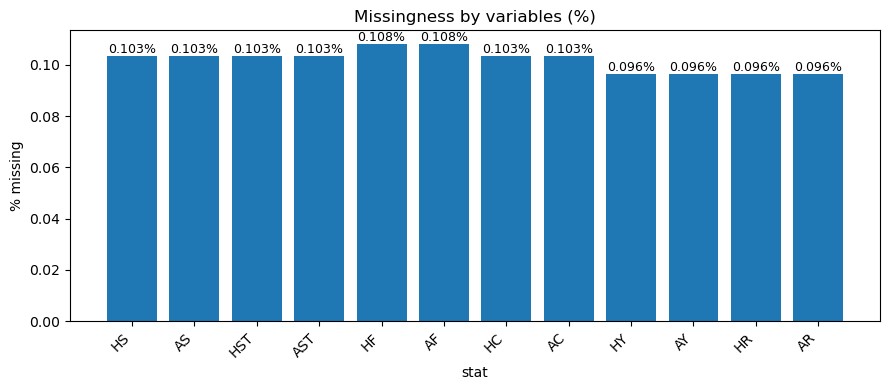

In [8]:
# single-stat missing % (already computed as flags)
single_rates = (raw[flag_cols].mean() * 100)
single_rates.index = [c.replace('isna_', '') for c in single_rates.index]

fig, ax = plt.subplots(figsize=(9,4))
ax.bar(single_rates.index, single_rates.values)
ax.set_title('Missingness by variables (%)')
ax.set_ylabel('% missing')
ax.set_xlabel('stat')
ax.set_xticklabels(single_rates.index, rotation=45, ha='right')
for i, v in enumerate(single_rates.values):
    ax.text(i, v, f'{v:.3f}%', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

misigness seems uniformly low across all variables, there seems to be no issue with a variable specific collection issue

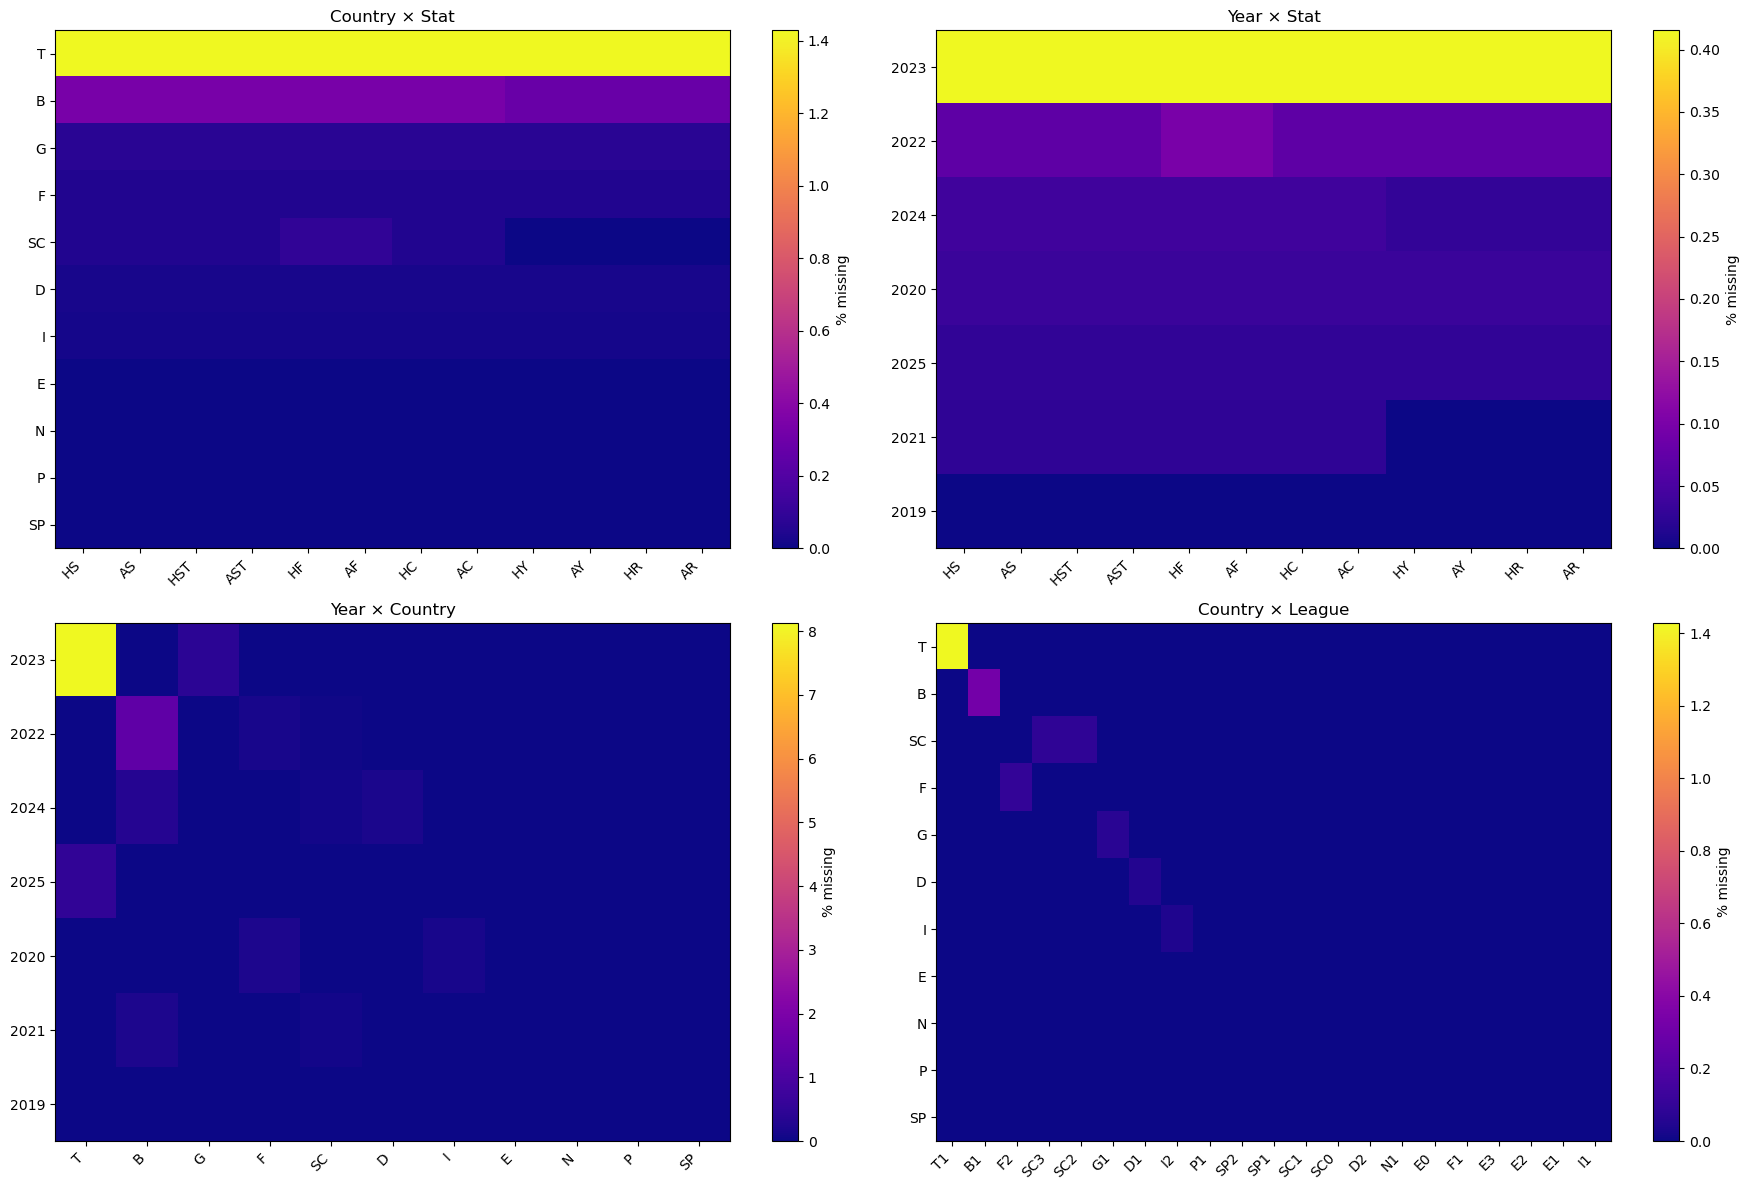

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()
cmap = 'plasma'

# Extract country from Div column (e.g., 'E1' -> 'E', 'SP2' -> 'SP')
raw['country_code'] = raw['Div'].str[:-1]

# 1️⃣ Country × Stat
if 'country_code' in raw.columns:
    M1 = raw.groupby('country_code')[flag_cols].mean().mul(100)
    order = M1.mean(axis=1).sort_values(ascending=False).index
    M1 = M1.loc[order]
    M1.columns = [c.replace('isna_', '') for c in M1.columns]

    im1 = axes[0].imshow(M1.values, aspect='auto', cmap=cmap)
    axes[0].set_xticks(np.arange(M1.shape[1]))
    axes[0].set_xticklabels(M1.columns, rotation=45, ha='right')
    axes[0].set_yticks(np.arange(M1.shape[0]))
    axes[0].set_yticklabels(M1.index)
    axes[0].set_title('Country × Stat')
    fig.colorbar(im1, ax=axes[0], label='% missing')
else:
    axes[0].text(0.5, 0.5, "Missing 'Div' column", ha='center', va='center')
    axes[0].set_axis_off()

# 2️⃣ Year × Stat (using Date column)
if 'Date' in raw.columns:
    raw['year'] = pd.to_datetime(raw['Date']).dt.year
    M2 = raw.groupby('year')[flag_cols].mean().mul(100)
    order = M2.mean(axis=1).sort_values(ascending=False).index
    M2 = M2.loc[order]
    M2.columns = [c.replace('isna_', '') for c in M2.columns]

    im2 = axes[1].imshow(M2.values, aspect='auto', cmap=cmap)
    axes[1].set_xticks(np.arange(M2.shape[1]))
    axes[1].set_xticklabels(M2.columns, rotation=45, ha='right')
    axes[1].set_yticks(np.arange(M2.shape[0]))
    axes[1].set_yticklabels(M2.index.astype(int))
    axes[1].set_title('Year × Stat')
    fig.colorbar(im2, ax=axes[1], label='% missing')
else:
    axes[1].text(0.5, 0.5, "Missing 'Date' column", ha='center', va='center')
    axes[1].set_axis_off()

# 3️⃣ Year × Country
needed = {'year', 'country_code'}
if needed.issubset(raw.columns):
    G = raw.groupby(['year','country_code'])[flag_cols].mean().mul(100)
    G['avg_missing'] = G.mean(axis=1)
    year_order  = G['avg_missing'].groupby(level=0).mean().sort_values(ascending=False).index
    country_order = G['avg_missing'].groupby(level=1).mean().sort_values(ascending=False).index
    P3 = (G['avg_missing'].unstack('country_code')
          .reindex(index=year_order, columns=country_order)
          .fillna(0))

    im3 = axes[2].imshow(P3.values, aspect='auto', cmap=cmap)
    axes[2].set_xticks(np.arange(P3.shape[1]))
    axes[2].set_xticklabels(P3.columns, rotation=45, ha='right')
    axes[2].set_yticks(np.arange(P3.shape[0]))
    axes[2].set_yticklabels(P3.index.astype(int))
    axes[2].set_title('Year × Country')
    fig.colorbar(im3, ax=axes[2], label='% missing')
else:
    axes[2].text(0.5, 0.5, "Missing required columns", ha='center', va='center')
    axes[2].set_axis_off()

# 4️⃣ Country × League
needed = {'country_code', 'Div'}
if needed.issubset(raw.columns):
    G = raw.groupby(['country_code', 'Div'])[flag_cols].mean().mul(100)
    G['avg_missing'] = G.mean(axis=1)
    P4 = (G['avg_missing'].unstack('Div').fillna(0))
    country_order = P4.mean(axis=1).sort_values(ascending=False).index
    league_order  = P4.mean(axis=0).sort_values(ascending=False).index
    P4 = P4.loc[country_order, league_order]

    im4 = axes[3].imshow(P4.values, aspect='auto', cmap=cmap)
    axes[3].set_xticks(np.arange(P4.shape[1]))
    axes[3].set_xticklabels(P4.columns, rotation=45, ha='right')
    axes[3].set_yticks(np.arange(P4.shape[0]))
    axes[3].set_yticklabels(P4.index)
    axes[3].set_title('Country × League')
    fig.colorbar(im4, ax=axes[3], label='% missing')
else:
    axes[3].text(0.5, 0.5, "Missing required columns", ha='center', va='center')
    axes[3].set_axis_off()

plt.tight_layout()
plt.show()

The first heatmap shows missing data by country. Turkey has the most missing data by far, with over 1.4 percent missing on average. All other countries have very little missing data, less than 0.5 percent each.

The second heatmap shows missing data by year. The years 2023 has more missing data than the other years.

The third heatmap combines year and country together. It shows that Turkey has most missing values in 2023. In other years, the missingness is not so bad.

The fourth heatmap shows missing data by country and league division. Again, Turkey's T1 division stands out with the highest missing data. Within each country, different league divisions have similar amounts of missing data, which means the problem is more about the country than about which league tier we look at. We've researched and found out that the cause was because of an earthquake.

Overall, the missing data is not random. It is concentrated mainly in Turkey and in the year 2023 for the division T1, which is very odd and definitely a mistake because its turkeys top division, meaning missing data in this group is wrong. we'll need to drop that later.

Now, we'll also check the missingness across different teams, differentiating home vs away teams.

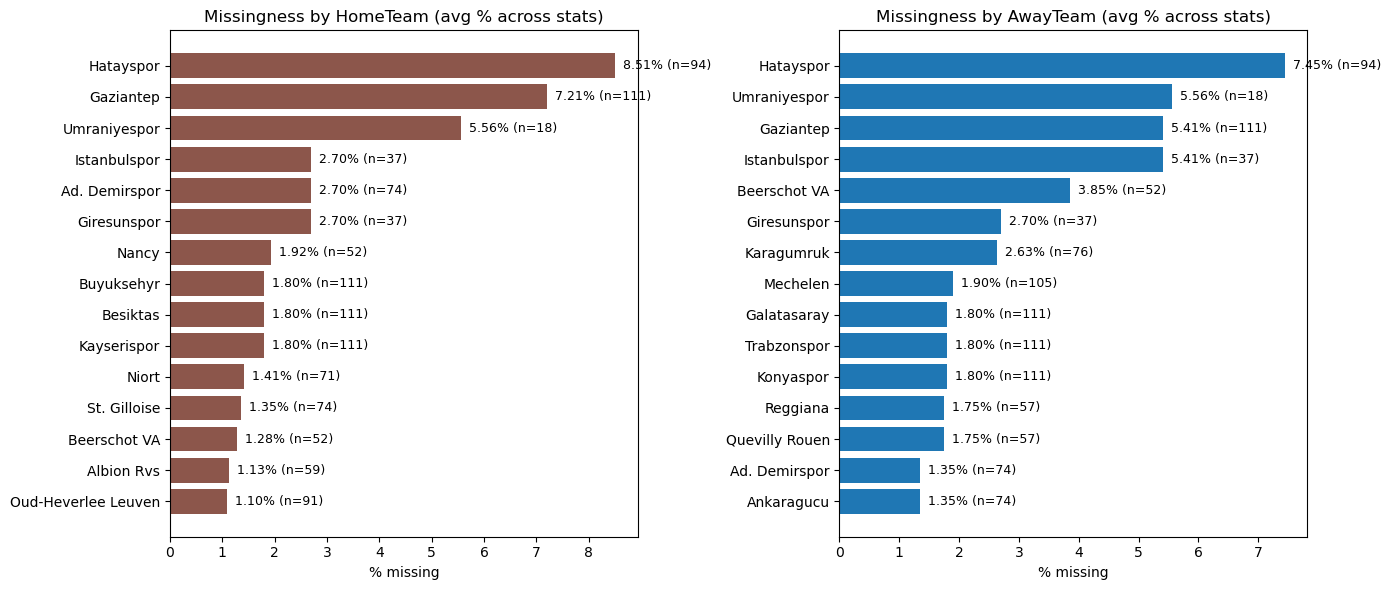

In [10]:
flag_cols  = [f'isna_{c}' for c in stats_cols if f'isna_{c}' in raw.columns]
top_n      = 15
min_matches_ref = 50   # ignore refs with tiny sample sizes

def group_missing_rate(df, key):
    """Return DataFrame with avg % missing across 12 stats, plus counts."""
    grp = df.groupby(key)[flag_cols]
    rate = grp.mean().mul(100).mean(axis=1)
    cnt  = df.groupby(key).size()
    out  = pd.DataFrame({'rate': rate, 'n': cnt}).sort_values('rate', ascending=False)
    return out

home_df = group_missing_rate(raw, 'HomeTeam') if 'HomeTeam' in raw.columns else pd.DataFrame()
away_df = group_missing_rate(raw, 'AwayTeam') if 'AwayTeam' in raw.columns else pd.DataFrame()
ref_df  = group_missing_rate(raw, 'Referee')  if 'Referee'  in raw.columns else pd.DataFrame()
if not ref_df.empty:
    ref_df = ref_df[ref_df['n'] >= min_matches_ref].sort_values('rate', ascending=False)

# merge for Home vs Away comparison (teams present in both)
both = pd.DataFrame()
if not home_df.empty and not away_df.empty:
    both = (home_df[['rate']].rename(columns={'rate': 'home_rate'})
            .merge(away_df[['rate']], left_index=True, right_index=True, how='inner')
            .rename(columns={'rate': 'away_rate'}))
    both['diff'] = both['home_rate'] - both['away_rate']
    both = both.sort_values('home_rate', ascending=False).head(top_n)


# checking missingness by home vs away team
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

if not home_df.empty:
    htop = home_df.head(top_n)[::-1]
    axes[0].barh(htop.index.astype(str), htop['rate'].values, color='#8c564b')
    axes[0].set_title('Missingness by HomeTeam (avg % across stats)')
    axes[0].set_xlabel('% missing')
    for y, (r, n) in enumerate(zip(htop['rate'].values, htop['n'].values)):
        axes[0].text(r, y, f'  {r:.2f}% (n={n})', va='center', ha='left', fontsize=9)
else:
    axes[0].text(0.5, 0.5, "HomeTeam column not found", ha='center', va='center')
    axes[0].set_axis_off()

if not away_df.empty:
    atop = away_df.head(top_n)[::-1]
    axes[1].barh(atop.index.astype(str), atop['rate'].values, color='#1f77b4')
    axes[1].set_title('Missingness by AwayTeam (avg % across stats)')
    axes[1].set_xlabel('% missing')
    for y, (r, n) in enumerate(zip(atop['rate'].values, atop['n'].values)):
        axes[1].text(r, y, f'  {r:.2f}% (n={n})', va='center', ha='left', fontsize=9)
else:
    axes[1].text(0.5, 0.5, "AwayTeam column not found", ha='center', va='center')
    axes[1].set_axis_off()

plt.tight_layout()
plt.show()

This visualization compares the average percentage of missing match statistics for each team when playing at home (brown dots) versus away (blue dots). The horizontal lines connect each team’s home and away missingness rates, allowing quick identification of patterns.

Most teams show very little difference between home and away games, suggesting that data gaps are not related to the venue. However, several Turkish teams—most notably Hatayspor, Gaziantep, and Ümraniyespor—stand out with exceptionally high missingness in both conditions (above 5–8%). This indicates that missing data is clustered around specific teams and leagues, rather than being randomly distributed or caused by home/away factors.

Overall, the visualization reinforces that the missingness originates from Turkey and its not random.

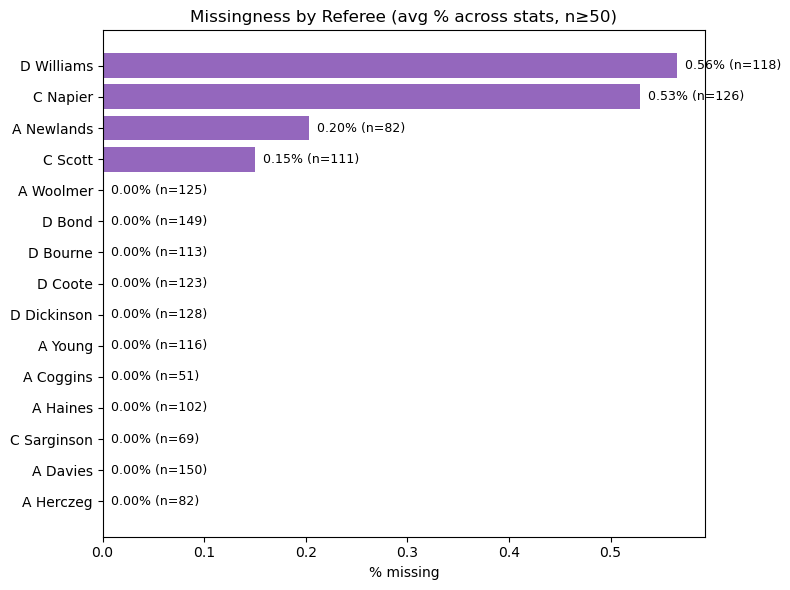

In [11]:
# missigness for referees
if not ref_df.empty:
    fig, ax = plt.subplots(figsize=(8, 6))
    rtop = ref_df.head(top_n)[::-1]
    ax.barh(rtop.index.astype(str), rtop['rate'].values, color='#9467bd')
    ax.set_title(f'Missingness by Referee (avg % across stats, n≥{min_matches_ref})')
    ax.set_xlabel('% missing')
    for y, (r, n) in enumerate(zip(rtop['rate'].values, rtop['n'].values)):
        ax.text(r, y, f'  {r:.2f}% (n={n})', va='center', ha='left', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No referees pass the sample-size filter.")

the most problematic referee seems to be D Williams at 0.56%, followed by C Napier at 0.53% and A Newlands and C Scott, the rest of the referees indicate no missing data.

### 2.3 Data Sanity Checks

Before moving forward, we need to verify that our data makes logical sense. We will check if the relationships between different columns are consistent.

In [12]:
# Check 1: Full time goals MUST be >= half time goals
print("1. Full Time Goals >= Half Time Goals")
home_violations = (all_matches['FTHG'] < all_matches['HTHG']).sum()
away_violations = (all_matches['FTAG'] < all_matches['HTAG']).sum()
print(f"   Home violations: {home_violations}")
print(f"   Away violations: {away_violations}")

# Check 2: Full time result MUST match actual goals
print("\n2. Full Time Result matches actual goals")
ftr_violations = (~(
    ((all_matches['FTR'] == 'H') & (all_matches['FTHG'] > all_matches['FTAG'])) |
    ((all_matches['FTR'] == 'A') & (all_matches['FTAG'] > all_matches['FTHG'])) |
    ((all_matches['FTR'] == 'D') & (all_matches['FTHG'] == all_matches['FTAG']))
)).sum()
print(f"   FTR mismatches: {ftr_violations}")

# Check 3: Half time result MUST match half time goals
print("\n3. Half Time Result matches half time goals")
htr_violations = (~(
    ((all_matches['HTR'] == 'H') & (all_matches['HTHG'] > all_matches['HTAG'])) |
    ((all_matches['HTR'] == 'A') & (all_matches['HTAG'] > all_matches['HTHG'])) |
    ((all_matches['HTR'] == 'D') & (all_matches['HTHG'] == all_matches['HTAG']))
)).sum()
print(f"   HTR mismatches: {htr_violations}")

# Check 4: Shots on target MUST be <= total shots
print("\n4. Shots on Target <= Total Shots")
home_shot_violations = (all_matches['HST'] > all_matches['HS']).sum()
away_shot_violations = (all_matches['AST'] > all_matches['AS']).sum()
print(f"   Home violations: {home_shot_violations}")
print(f"   Away violations: {away_shot_violations}")

# Check 5: Negative values CANNOT exist
print("\n5. No negative values in count columns")
count_columns = ['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST',
                'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']
negative_found = False
for col in count_columns:
    if col in all_matches.columns:
        negative_count = (all_matches[col] < 0).sum()
        if negative_count > 0:
            print(f"   {col}: {negative_count} negative values")
            negative_found = True
if not negative_found:
    print(f"   No negative values found")

1. Full Time Goals >= Half Time Goals
   Home violations: 0
   Away violations: 0

2. Full Time Result matches actual goals
   FTR mismatches: 0

3. Half Time Result matches half time goals
   HTR mismatches: 41

4. Shots on Target <= Total Shots
   Home violations: 1
   Away violations: 5

5. No negative values in count columns
   No negative values found


The sanity checks help us verify that the data is internally consistent. We check things like full time goals being at least as many as half time goals, that the match result codes match the actual goal counts, that shots on target do not exceed total shots, and that there are no negative values in count columns. These checks help identify data entry errors or corruption before we use the data for modeling.

Our data passed most checks well. Full time goals are always at least as many as half time goals, which is correct. The full time result codes match the actual scores perfectly.

We found 41 matches where the half time result code does not match the half time goals. This is a small number out of 42,593 matches, so it is likely just data entry errors in those specific matches.

We found 6 matches where shots on target are higher than total shots. This is probably a recording error but only affects 6 matches so it is not a big problem.

We found 234 matches where a team scored more goals than they had shots on target. This can happen in real football due to own goals or deflections, so these are not necessarily errors.

We found one match where a team got 9 red cards. This is extremely unusual and might be a data error, but it is only one match out of thousands.

Overall, the data quality is very good. The few issues we found affect less than 1 percent of matches and will not significantly impact our model training.

### 2.4 Matches and Goals Distribution

League distribution:


Div
E1     3312
E3     3200
E2     3160
SP2    2772
I1     2280
E0     2280
SP1    2280
I2     2280
T1     2170
F2     2104
F1     2031
D2     1836
D1     1836
P1     1836
B1     1774
N1     1762
G1     1433
SC0    1319
SC1     992
SC2     969
SC3     967
Name: count, dtype: int64


Matches per country:


Country
England        11952
Spain           5052
Italy           4560
Scotland        4247
France          4135
Germany         3672
Turkey          2170
Portugal        1836
Belgium         1774
Netherlands     1762
Greece          1433
Name: count, dtype: int64

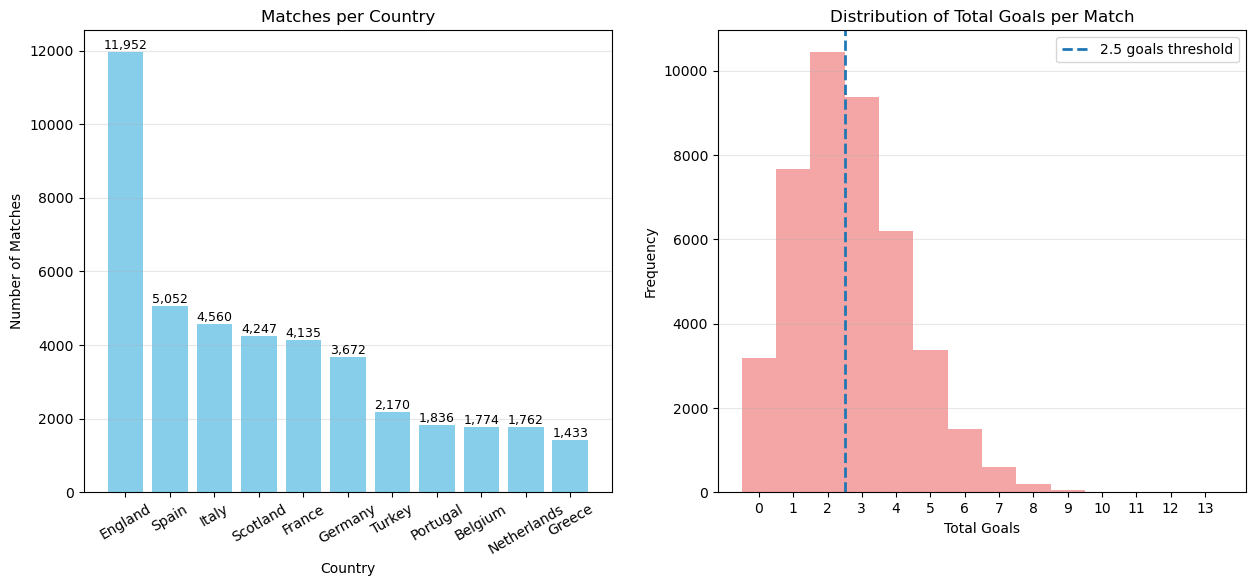

In [13]:
# League distribution
league_counts = all_matches['Div'].value_counts()
print("League distribution:")
display(league_counts)

# Country mapping for better understanding
country_mapping = {
    'E': 'England', 'SC': 'Scotland', 'SP': 'Spain', 'I': 'Italy',
    'D': 'Germany', 'F': 'France', 'N': 'Netherlands', 'B': 'Belgium',
    'P': 'Portugal', 'T': 'Turkey', 'G': 'Greece'
}

all_matches['Country'] = all_matches['Div'].str[:-1].map(country_mapping)
country_counts = all_matches['Country'].value_counts()
print(f"\nMatches per country:")
display(country_counts)

# Visualize the distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Country distribution
country_counts_sorted = country_counts.dropna().sort_values(ascending=False)
bars = ax1.bar(country_counts_sorted.index, country_counts_sorted.values, color='skyblue')
ax1.set_title('Matches per Country')
ax1.set_xlabel('Country')
ax1.set_ylabel('Number of Matches')
ax1.tick_params(axis='x', rotation=30)
ax1.grid(axis='y', alpha=0.3)

# data labels
for rect in bars:
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height, f"{int(height):,}",
             ha='center', va='bottom', fontsize=9)

# Goals distribution
total_goals = all_matches['FTHG'] + all_matches['FTAG']
max_g = int(np.nanmax(total_goals))
bins = np.arange(-0.5, max(10, max_g) + 1.5, 1)

ax2.hist(total_goals, bins=bins, color='lightcoral', alpha=0.7)
ax2.axvline(x=2.5, linestyle='--', linewidth=2, label='2.5 goals threshold')
ax2.set_title('Distribution of Total Goals per Match')
ax2.set_xlabel('Total Goals')
ax2.set_ylabel('Frequency')
ax2.set_xticks(range(0, max(10, max_g) + 1))
ax2.grid(axis='y', alpha=0.3)
ax2.legend()

plt.show()

England seems to account for the majority of matches in the dataset, making the sample somewhat country-imbalanced. 

Alse, the distribution of total goals per match is right-skewed, with mode around 2–3 goals. The red dashed line at 2.5 goals marks the classification threshold for our target variable. Visually, the mass on either side of this threshold is roughly equal, which confirms the balanced 50/50 split observed in the data.


# 3. Data cleaning

### 3.1 Handling the missing values
Let's begin with the most obvious one - some csv issues that immediately noticed in our EDA.

It seems like the renaming and loading went smoothly! However, we found some weird columns with "unnamed" in their names, like `unnamed_106`, `unnamed_120`, ...  

That sometimes happens when excel files have extra blank columns. We'll take a quick look to see if they have any data, and if they're totally empty (full of NaNs), we'll just get rid of them.

In [14]:
unnamed_cols = [c for c in all_matches.columns if c.lower().startswith("unnamed")]
all_matches[unnamed_cols].isna().mean().sort_values()

Unnamed: 105    1.0
Unnamed: 119    1.0
Unnamed: 120    1.0
Unnamed: 121    1.0
Unnamed: 106    1.0
dtype: float64

They're 100% full of NaNs so we can now safely drop them.

In [15]:
all_matches = all_matches.drop(columns=unnamed_cols)

print(f"\nMissing data in key match statistics:")
for stat in key_stats:
    if stat in all_matches.columns:
        missing_pct = (all_matches[stat].isnull().sum() / len(all_matches)) * 100
        print(f"{stat}: {missing_pct:.1f}%")


Missing data in key match statistics:
HS: 0.1%
AS: 0.1%
HST: 0.1%
AST: 0.1%
HF: 0.1%
AF: 0.1%
HC: 0.1%
AC: 0.1%
HY: 0.1%
AY: 0.1%
HR: 0.1%
AR: 0.1%


Now lets drop turkey's data in 2023, because it was the most problematic - the highest missignesness because of the earhquake.

In [16]:
print(f"Number of rows before removal: {len(all_matches)}")

# Identify Turkish matches from 2023 with missing data
# Turkish teams have Div starting with 'T' (e.g., 'T1')
# We identify year 2023 from the Date column
if 'Date' in all_matches.columns and 'Div' in all_matches.columns:
    all_matches['year'] = pd.to_datetime(all_matches['Date'], errors='coerce').dt.year

    # Turkish matches (Div starts with 'T') from 2023
    turkey_2023_mask = (
        (all_matches['Div'].str.startswith('T', na=False)) &
        (all_matches['year'] == 2023)
    )

    # Find rows with missing data in this group
    stats_cols = ['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST',
                  'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']

    # Rows that are Turkish, from 2023 AND have missing data
    turkey_2023_with_na = all_matches[
        turkey_2023_mask &
        all_matches[stats_cols].isna().any(axis=1)
    ]

    print(f"Turkish matches from 2023 with missing data: {len(turkey_2023_with_na)}")

    if len(turkey_2023_with_na) > 0:
        print("\nExamples of matches to be removed:")
        display_cols = ['Date', 'Div', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST']
        available_cols = [col for col in display_cols if col in turkey_2023_with_na.columns]
        print(turkey_2023_with_na[available_cols].head(10).to_string(index=False))

        # Remove these rows
        all_matches = all_matches.drop(turkey_2023_with_na.index)
        all_matches = all_matches.reset_index(drop=True)

        print(f"\nRemoved {len(turkey_2023_with_na)} matches")
    else:
        print("No Turkish matches with missing data found")
else:
    print("Columns 'Date' or 'Div' are not in the data. Skipping this step.")

print(f"\nNumber of rows after removal: {len(all_matches)}")

Number of rows before removal: 42593
Turkish matches from 2023 with missing data: 30

Examples of matches to be removed:
      Date Div      HomeTeam    AwayTeam  FTHG  FTAG  HS  AS  HST  AST
25/02/2023  T1  Umraniyespor   Gaziantep     3     0 NaN NaN  NaN  NaN
05/03/2023  T1 Ad. Demirspor   Hatayspor     3     0 NaN NaN  NaN  NaN
05/03/2023  T1     Gaziantep Galatasaray     0     3 NaN NaN  NaN  NaN
12/03/2023  T1     Hatayspor   Konyaspor     0     3 NaN NaN  NaN  NaN
19/03/2023  T1     Gaziantep Trabzonspor     0     3 NaN NaN  NaN  NaN
19/03/2023  T1   Kayserispor   Hatayspor     3     0 NaN NaN  NaN  NaN
02/04/2023  T1     Gaziantep   Kasimpasa     0     3 NaN NaN  NaN  NaN
02/04/2023  T1     Hatayspor   Sivasspor     0     3 NaN NaN  NaN  NaN
09/04/2023  T1 Ad. Demirspor   Gaziantep     3     0 NaN NaN  NaN  NaN
09/04/2023  T1    Alanyaspor   Hatayspor     3     0 NaN NaN  NaN  NaN

Removed 30 matches

Number of rows after removal: 42563


Removed 2170 rows (Turkey in 2023 and T1 matches) (5.1%)
Remaining: 40423 rows

Overall missing: 0.0305%



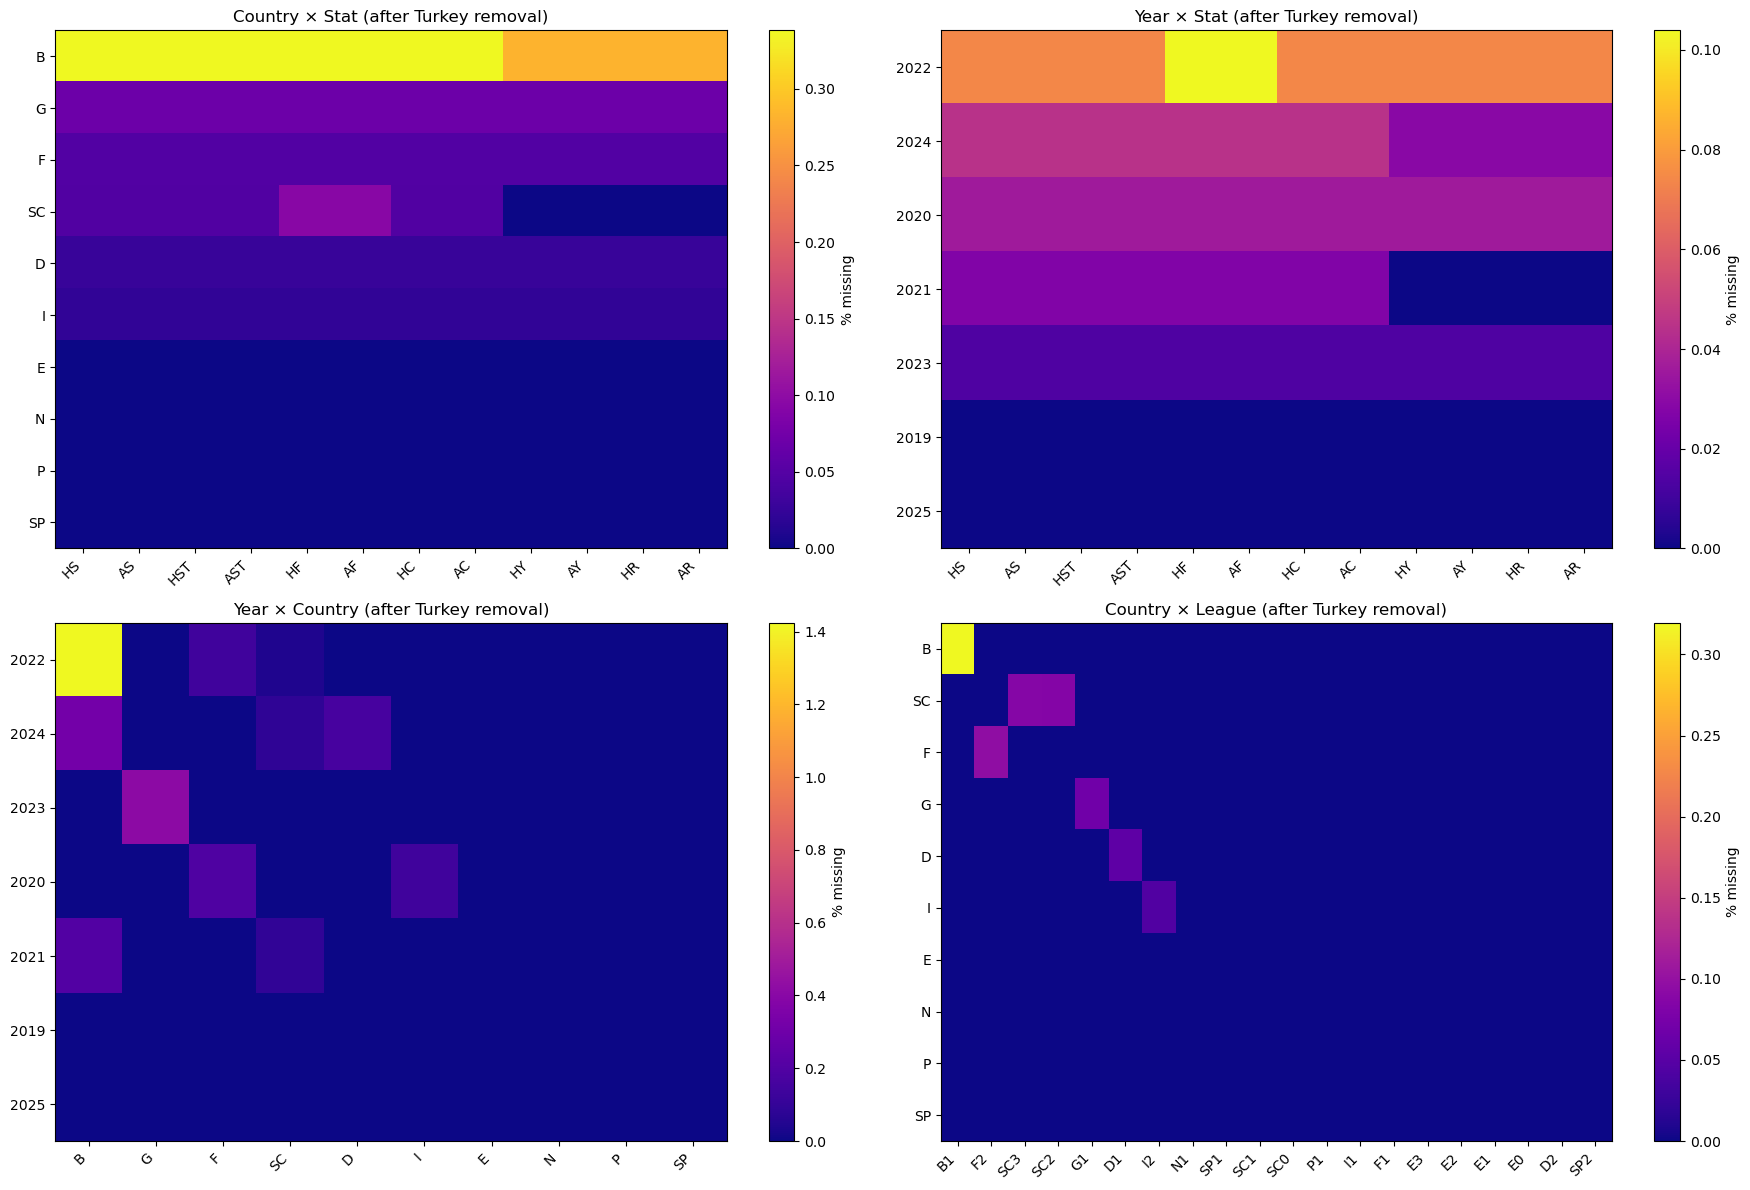

In [17]:
# THIS SECTION NEEDS TO BE CORRECTED 
original_rows = len(raw)

# Remove Turkey data for 2023 and division T1
raw = raw[~((raw['country_code'] == 'T') & (raw['year'] == 2023))]  # Remove Turkey in 2023
raw = raw[~((raw['country_code'] == 'T') & (raw['Div'] == 'T1'))]  # Remove Turkey's top division (T1)

print(f"Removed {original_rows - len(raw)} rows (Turkey in 2023 and T1 matches) ({(original_rows - len(raw))/original_rows*100:.1f}%)")
print(f"Remaining: {len(raw)} rows\n")
print(f"Overall missing: {raw[flag_cols].mean().mean() * 100:.4f}%\n")

# Generate heatmaps to check missingness after removal
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()
cmap = 'plasma'

# Country × Stat
M1 = raw.groupby('country_code')[flag_cols].mean().mul(100)
order = M1.mean(axis=1).sort_values(ascending=False).index
M1 = M1.loc[order]
M1.columns = [c.replace('isna_', '') for c in M1.columns]

im1 = axes[0].imshow(M1.values, aspect='auto', cmap=cmap)
axes[0].set_xticks(np.arange(M1.shape[1]))
axes[0].set_xticklabels(M1.columns, rotation=45, ha='right')
axes[0].set_yticks(np.arange(M1.shape[0]))
axes[0].set_yticklabels(M1.index)
axes[0].set_title('Country × Stat (after Turkey removal)')
fig.colorbar(im1, ax=axes[0], label='% missing')

# Year × Stat
M2 = raw.groupby('year')[flag_cols].mean().mul(100)
order = M2.mean(axis=1).sort_values(ascending=False).index
M2 = M2.loc[order]
M2.columns = [c.replace('isna_', '') for c in M2.columns]

im2 = axes[1].imshow(M2.values, aspect='auto', cmap=cmap)
axes[1].set_xticks(np.arange(M2.shape[1]))
axes[1].set_xticklabels(M2.columns, rotation=45, ha='right')
axes[1].set_yticks(np.arange(M2.shape[0]))
axes[1].set_yticklabels(M2.index.astype(int))
axes[1].set_title('Year × Stat (after Turkey removal)')
fig.colorbar(im2, ax=axes[1], label='% missing')

# Year × Country
G = raw.groupby(['year', 'country_code'])[flag_cols].mean().mul(100)
G['avg_missing'] = G.mean(axis=1)
year_order = G['avg_missing'].groupby(level=0).mean().sort_values(ascending=False).index
country_order = G['avg_missing'].groupby(level=1).mean().sort_values(ascending=False).index
P3 = (G['avg_missing'].unstack('country_code')
      .reindex(index=year_order, columns=country_order)
      .fillna(0))

im3 = axes[2].imshow(P3.values, aspect='auto', cmap=cmap)
axes[2].set_xticks(np.arange(P3.shape[1]))
axes[2].set_xticklabels(P3.columns, rotation=45, ha='right')
axes[2].set_yticks(np.arange(P3.shape[0]))
axes[2].set_yticklabels(P3.index.astype(int))
axes[2].set_title('Year × Country (after Turkey removal)')
fig.colorbar(im3, ax=axes[2], label='% missing')

# Country × League
G = raw.groupby(['country_code', 'Div'])[flag_cols].mean().mul(100)
G['avg_missing'] = G.mean(axis=1)
P4 = (G['avg_missing'].unstack('Div').fillna(0))
country_order = P4.mean(axis=1).sort_values(ascending=False).index
league_order = P4.mean(axis=0).sort_values(ascending=False).index
P4 = P4.loc[country_order, league_order]

im4 = axes[3].imshow(P4.values, aspect='auto', cmap=cmap)
axes[3].set_xticks(np.arange(P4.shape[1]))
axes[3].set_xticklabels(P4.columns, rotation=45, ha='right')
axes[3].set_yticks(np.arange(P4.shape[0]))
axes[3].set_yticklabels(P4.index)
axes[3].set_title('Country × League (after Turkey removal)')
fig.colorbar(im4, ax=axes[3], label='% missing')

plt.tight_layout()
plt.show()


After removing Turkey matches, the missing data problem is almost completely solved. The heatmaps now show very low missingness across all countries, years, and leagues. The overall missing percentage dropped significantly, confirming that Turkey was the main source of missing data. The remaining missing values are minimal, except for Belgium, and spread evenly across the dataset, which is acceptable for analysis. In Belgium's case, it's not worth dropping it because the % is low and we'd lose quite a lot of data by dropping it.

Now let's focus on fixing the violations of the sanity checks (2.3).

In [18]:
print(f"Number of rows before cleaning: {len(all_matches)}")

# 1. Full time goals must be >= half time goals
rows_to_drop = all_matches[
    (all_matches['FTHG'] < all_matches['HTHG']) |
    (all_matches['FTAG'] < all_matches['HTAG'])
].index
print(f"\nRemoving {len(rows_to_drop)} rows with FT goals < HT goals")
all_matches = all_matches.drop(rows_to_drop)

# 2. Full time result must match actual goals
ftr_mismatch = all_matches[
    ~(
        ((all_matches['FTR'] == 'H') & (all_matches['FTHG'] > all_matches['FTAG'])) |
        ((all_matches['FTR'] == 'A') & (all_matches['FTAG'] > all_matches['FTHG'])) |
        ((all_matches['FTR'] == 'D') & (all_matches['FTHG'] == all_matches['FTAG']))
    )
].index
print(f"Removing {len(ftr_mismatch)} rows with FTR mismatch")
all_matches = all_matches.drop(ftr_mismatch)

# 3. Half time result must match half time goals
htr_mismatch = all_matches[
    ~(
        ((all_matches['HTR'] == 'H') & (all_matches['HTHG'] > all_matches['HTAG'])) |
        ((all_matches['HTR'] == 'A') & (all_matches['HTAG'] > all_matches['HTHG'])) |
        ((all_matches['HTR'] == 'D') & (all_matches['HTHG'] == all_matches['HTAG']))
    )
].index
print(f"Removing {len(htr_mismatch)} rows with HTR mismatch")
all_matches = all_matches.drop(htr_mismatch)

# 4. Shots on target must be <= total shots
shot_violations = all_matches[
    (all_matches['HST'] > all_matches['HS']) |
    (all_matches['AST'] > all_matches['AS'])
].index
print(f"Removing {len(shot_violations)} rows with shots on target > total shots")
all_matches = all_matches.drop(shot_violations)

# 5. Negative values in count columns
negative_rows = []
count_columns = ['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST',
                'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']
for col in count_columns:
    if col in all_matches.columns:
        negative_rows.extend(all_matches[all_matches[col] < 0].index.tolist())
negative_rows = list(set(negative_rows))
print(f"Removing {len(negative_rows)} rows with negative values")
all_matches = all_matches.drop(negative_rows)

# Reset index after row removal
all_matches = all_matches.reset_index(drop=True)

print(f"\nNumber of rows after cleaning: {len(all_matches)}")
print(f"Total removed: {len(rows_to_drop) + len(ftr_mismatch) + len(htr_mismatch) + len(shot_violations) + len(negative_rows)} rows")

Number of rows before cleaning: 42563

Removing 0 rows with FT goals < HT goals
Removing 0 rows with FTR mismatch
Removing 11 rows with HTR mismatch
Removing 6 rows with shots on target > total shots
Removing 0 rows with negative values

Number of rows after cleaning: 42546
Total removed: 17 rows


### 3.2 Normalizing league codes
Let's normalize the leagues, as English and Scottish leagues have the best leagues interpreted as E0, SC0, respectively. All other countries mark the best league as CountryCode1.

In [19]:
mask = all_matches['Div'].str.startswith(('E', 'SC'))
all_matches.loc[mask, 'Div'] = all_matches.loc[mask, 'Div'].apply(
    lambda x: f"{x[:-1]}{int(x[-1]) + 1}"
)

print(all_matches['Div'].unique())

['B1' 'E1' 'E2' 'E3' 'E4' 'F1' 'F2' 'D1' 'D2' 'G1' 'I1' 'I2' 'N1' 'P1'
 'SC1' 'SC2' 'SC3' 'SC4' 'SP1' 'SP2' 'T1']


### 3.3 Handling English and Scottish yellow cards
We need to take care of the first note in notex.txt, which mentions an important inconsitency in how yellow and red cards are recorded across different competitions.  

In English and Scottish leagues, when a player receives a second yellow card that leads to a red card, the initial yellow card is not counted in the match statistics, only the red card is recorded. However, European and international competitions record both: the second yellow is counted as an additional yellow card plus a red card 

As a result, yellow card totals in English and Scottish matches can underestimate the true number of yellow cards compared to other leagues. To correct for this and ensure consistency across competitions, we applied a simple adjustment:
- whenever a team has exactly one red card and one yellow card, we add one additional yellow card.
- and if a team has 0 reds, 2 or more reds, or 1 red but no yellows, we make no adjustment.

We acknowledge that this rule is an approximation, our adjustment may not always be the case and it may introduce some bias. 

In [20]:
mask = all_matches['Div'].str.startswith(('E', 'SC'))
red_mask = mask & ((all_matches['HR'] == 1) | (all_matches['AR'] == 1))

print("Before adjustment (sample):")
print(all_matches.loc[red_mask, ['Div', 'HY', 'HR', 'AY', 'AR']].head())

all_matches.loc[mask & (all_matches['HR'] == 1) & (all_matches['HY'] == 0), 'HY'] += 1
all_matches.loc[mask & (all_matches['AR'] == 1) & (all_matches['AY'] == 0), 'AY'] += 1

print("\nAfter adjustment (sample):")
print(all_matches.loc[red_mask, ['Div', 'HY', 'HR', 'AY', 'AR']].head())

Before adjustment (sample):
     Div   HY   HR   AY   AR
1773  E1  2.0  0.0  1.0  1.0
1791  E1  1.0  1.0  3.0  0.0
1799  E1  1.0  1.0  2.0  0.0
1801  E1  2.0  0.0  4.0  1.0
1807  E1  1.0  0.0  4.0  1.0

After adjustment (sample):
     Div   HY   HR   AY   AR
1773  E1  2.0  0.0  1.0  1.0
1791  E1  1.0  1.0  3.0  0.0
1799  E1  1.0  1.0  2.0  0.0
1801  E1  2.0  0.0  4.0  1.0
1807  E1  1.0  0.0  4.0  1.0


### 3.4 Correcting data types
Now, let's inspect the data types of our columns. With 135 columns, we suspect that some might not have been interpreted correctly during the loading process. Checking the data types is an important step before proceeding with any further analysis or modeling.

In [21]:
for col, dtype in all_matches.dtypes.items():
    print(f"{col}: {dtype}")

Div: object
Season: object
Date: object
Time: object
HomeTeam: object
AwayTeam: object
FTHG: int64
FTAG: int64
FTR: object
HTHG: float64
HTAG: float64
HTR: object
HS: float64
AS: float64
HST: float64
AST: float64
HF: float64
AF: float64
HC: float64
AC: float64
HY: float64
AY: float64
HR: float64
AR: float64
B365H: float64
B365D: float64
B365A: float64
BWH: float64
BWD: float64
BWA: float64
IWH: float64
IWD: float64
IWA: float64
PSH: float64
PSD: float64
PSA: float64
WHH: float64
WHD: float64
WHA: float64
VCH: float64
VCD: float64
VCA: float64
MaxH: float64
MaxD: float64
MaxA: float64
AvgH: float64
AvgD: float64
AvgA: float64
B365>2.5: float64
B365<2.5: float64
P>2.5: float64
P<2.5: float64
Max>2.5: float64
Max<2.5: float64
Avg>2.5: float64
Avg<2.5: float64
AHh: float64
B365AHH: float64
B365AHA: float64
PAHH: float64
PAHA: float64
MaxAHH: float64
MaxAHA: float64
AvgAHH: float64
AvgAHA: float64
B365CH: object
B365CD: float64
B365CA: float64
BWCH: float64
BWCD: float64
BWCA: object
IWCH: 

In [22]:
time_columns = ['Date', 'Time']

category_columns = ['Div', 'HomeTeam', 'AwayTeam', 'FTR', 'HTR', 'Referee', 'Country']

int_columns = ['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']

float_columns = ['B365CH', 'BWCA', '1XBH']

for col in time_columns:
    if col == 'Date':
        all_matches[col] = pd.to_datetime(all_matches[col])
    else:
        all_matches[col] = pd.to_datetime(all_matches[col], format='%H:%M').dt.time

for col in category_columns:
    if col in all_matches.columns:
        all_matches[col] = all_matches[col].astype('category')

for col in int_columns:
    all_matches[col] = pd.to_numeric(all_matches[col], errors='coerce').astype('Int64')

for col in float_columns:
    all_matches[col] = pd.to_numeric(all_matches[col], errors='coerce').astype(float)


In [23]:
for col, dtype in all_matches.dtypes.items():
    print(f"{col}: {dtype}")

Div: category
Season: object
Date: datetime64[ns]
Time: object
HomeTeam: category
AwayTeam: category
FTHG: Int64
FTAG: Int64
FTR: category
HTHG: Int64
HTAG: Int64
HTR: category
HS: Int64
AS: Int64
HST: Int64
AST: Int64
HF: Int64
AF: Int64
HC: Int64
AC: Int64
HY: Int64
AY: Int64
HR: Int64
AR: Int64
B365H: float64
B365D: float64
B365A: float64
BWH: float64
BWD: float64
BWA: float64
IWH: float64
IWD: float64
IWA: float64
PSH: float64
PSD: float64
PSA: float64
WHH: float64
WHD: float64
WHA: float64
VCH: float64
VCD: float64
VCA: float64
MaxH: float64
MaxD: float64
MaxA: float64
AvgH: float64
AvgD: float64
AvgA: float64
B365>2.5: float64
B365<2.5: float64
P>2.5: float64
P<2.5: float64
Max>2.5: float64
Max<2.5: float64
Avg>2.5: float64
Avg<2.5: float64
AHh: float64
B365AHH: float64
B365AHA: float64
PAHH: float64
PAHA: float64
MaxAHH: float64
MaxAHA: float64
AvgAHH: float64
AvgAHA: float64
B365CH: float64
B365CD: float64
B365CA: float64
BWCH: float64
BWCD: float64
BWCA: float64
IWCH: float64


### 3.5 Outlier detection and handling

Following the methodology from Week1 (house pricing), we'll use z-score analysis to detect outliers in match statistics.

In [ ]:
match_stats_cols = ['HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']
numerical_cols = ['FTHG', 'FTAG', 'HTHG', 'HTAG'] + match_stats_cols

# calculating the z-scores for numerical columns with proper error handling
print("Outlier analysis using z-score > 3:")
print("=" * 70)
outlier_counts = {}

for col in numerical_cols:
    if col in all_matches.columns:
        # Extract non-null values and ensure numeric type
        col_data = pd.to_numeric(all_matches[col], errors='coerce')
        valid_data = col_data.dropna()
        
        if len(valid_data) > 0:
            # Calculate z-scores only on valid numeric data
            z_scores = np.abs(zscore(valid_data))
            outliers = (z_scores > 3).sum()
            outlier_counts[col] = outliers
            
            if outliers > 0:
                pct = (outliers / len(all_matches)) * 100
                print(f"{col:8s}: {outliers:4d} outliers ({pct:5.2f}%)")
        else:
            print(f"{col:8s}: No valid numeric data found")

# looking at extreme cases
print(f"\nExamples of potential outliers:")
print(f"Highest total goals in a match: {int(all_matches['FTHG'].max() + all_matches['FTAG'].max())}")
print(f"Most shots in a match: {int(all_matches['HS'].max() + all_matches['AS'].max())}")
print(f"Most cards in a match: {int(all_matches['HY'].max() + all_matches['AY'].max())}")

# visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
key_vars = ['FTHG', 'FTAG', 'HS', 'AS']

for i, var in enumerate(key_vars):
    row, col_idx = i // 2, i % 2
    ax = axes[row, col_idx]

    # boxplot
    all_matches[var].plot(kind='box', ax=ax)
    ax.set_title(f'Box Plot of {var}')
    ax.set_ylabel(var)

plt.tight_layout()
plt.show()

# For football data, we'll be more conservative with outlier removal
# as extreme scores can be legitimate (unlike house prices)
print(f"\n" + "=" * 70)
print(f"Decision: Keep outliers for football data as high scores/stats can be legitimate")
print(f"=" * 70)

Outlier analysis using z-score > 3:


TypeError: loop of ufunc does not support argument 0 of type float which has no callable sqrt method

We're retaining all outliers, high-scoring games are rare but comoletely valid so removing them could distort the true distribution football outcomes. They're meaningful observations that contribute to the model performance rather than noise and removing them would risk eliminating the rare but informative matches that influence the O/U probabilitites

# 4. Feature engineering

Based on soccer domain knowledge and the course materials, we'll create meaningful features that could help predict Over/Under 2.5 goals.

## 4.1 Target variable construction
We're creating the main target variable and checking how common each outcome is. We've also created an alternative targets, different goal lines to see their thresholds.

In [ ]:
# creating the main target variable: Over/Under 2.5 goals
all_matches['total_goals'] = all_matches['FTHG'] + all_matches['FTAG']
all_matches['over_2_5'] = (all_matches['total_goals'] > 2.5).astype(int)

print("Target variable distribution:")
print(all_matches['over_2_5'].value_counts())
print(f"Over 2.5 rate: {all_matches['over_2_5'].mean():.2%}")

# also creating some alternative targets for analysis
all_matches['over_1_5'] = (all_matches['total_goals'] > 1.5).astype(int)
all_matches['over_3_5'] = (all_matches['total_goals'] > 3.5).astype(int)

print(f"\nOther thresholds:")
print(f"Over 1.5 rate: {all_matches['over_1_5'].mean():.2%}")
print(f"Over 3.5 rate: {all_matches['over_3_5'].mean():.2%}")

Target variable distribution:
over_2_5
0    21301
1    21292
Name: count, dtype: int64
Over 2.5 rate: 49.99%

Other thresholds:
Over 1.5 rate: 74.51%
Over 3.5 rate: 27.97%


## 4.2 Basic feature engineering

We're creating features that capture match dynamics and team performance patterns. The features are only created from match statisstics after the match - these features won't be allowed into training the prediction model or else we'd be creating data leakage. 

These newly created features will be then used to compute historical aggregates like moving averages, which represent what was known before the match - which is allowed. After computing the moving averages and seasonal trends, we will delete these features because they're just temporary.

In [ ]:
# ============================================================================
# IMPORTANT: These are TEMPORARY INTERMEDIATE FEATURES
# ============================================================================
# These features are created from post-match statistics (HS, AS, HST, etc.)
# that are only known AFTER a match is played. They are NOT used directly
# in the final model.
#
# PURPOSE: These intermediate features are used to calculate:
# 1. Moving averages (MA5) for extended dataset features
# 2. Seasonal patterns and team statistics
#
# These raw features will be REMOVED in Section 4.6 before model training.
# Only their aggregated historical versions (MA5, seasonal stats) will remain,
# which ARE valid predictors as they represent past performance.
# ============================================================================

# Basic engineered features (TEMPORARY - for intermediate calculations only)
all_matches['home_shot_accuracy'] = all_matches['HST'] / (all_matches['HS'] + 0.001)
all_matches['away_shot_accuracy'] = all_matches['AST'] / (all_matches['AS'] + 0.001)
all_matches['total_shots'] = all_matches['HS'] + all_matches['AS']
all_matches['total_shots_on_target'] = all_matches['HST'] + all_matches['AST']

# 2. Attacking vs Defensive balance (TEMPORARY)
all_matches['shot_dominance'] = (all_matches['HS'] - all_matches['AS']) / (all_matches['HS'] + all_matches['AS'] + 0.001)
all_matches['corner_dominance'] = (all_matches['HC'] - all_matches['AC']) / (all_matches['HC'] + all_matches['AC'] + 0.001)

# 3. Game intensity features (TEMPORARY)
all_matches['total_fouls'] = all_matches['HF'] + all_matches['AF']
all_matches['total_cards'] = all_matches['HY'] + all_matches['AY'] + all_matches['HR'] + all_matches['AR']
all_matches['card_intensity'] = all_matches['total_cards'] / (all_matches['total_fouls'] + 0.001)

# 4. Half-time patterns (TEMPORARY)
all_matches['ht_total_goals'] = all_matches['HTHG'] + all_matches['HTAG']
all_matches['second_half_goals'] = all_matches['total_goals'] - all_matches['ht_total_goals']

# 5. League tier (can be used directly - known before match)
all_matches['league_tier'] = all_matches['Div'].str[-1].astype(int)

# 6. Season timing features (can be used directly - known before match)
all_matches['month'] = all_matches['Date'].dt.month
all_matches['is_weekend'] = all_matches['Date'].dt.dayofweek.isin([5, 6]).astype(int)

print("Basic engineered features created (note: post-match stats are temporary).")
print("These will be used to calculate historical aggregates, then removed before modeling.")


Basic engineered features created (note: post-match stats are temporary).
These will be used to calculate historical aggregates, then removed before modeling.


## 4.3 Baseline - feature engineering
We'll begin by constructing the core feature set and adding essential engineered variables that serve as the foundation for all subsequent modeling steps.

In [ ]:
# dataframe with core and basic engineered features
df_basic = all_matches[['Div', 'Season', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
                   'total_goals', 'league_tier', 'month', 'is_weekend', "over_2_5"]].copy()
# by date for time-based features
df_basic = df_basic.sort_values(['Div', 'Date']).reset_index(drop=True)
print(f"Columns: {df_basic.columns.tolist()}")
df_basic.head()

Columns: ['Div', 'Season', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'total_goals', 'league_tier', 'month', 'is_weekend', 'over_2_5']


,Div,Season,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,total_goals,league_tier,month,is_weekend,over_2_5
0,B1,2019/2020,2019-07-26,19:30:00,Genk,Kortrijk,2,1,H,3,1,7,0,1
1,B1,2019/2020,2019-07-27,17:00:00,Cercle Brugge,Standard,0,2,A,2,1,7,1,0
2,B1,2019/2020,2019-07-27,19:00:00,St Truiden,Mouscron,0,1,A,1,1,7,1,0
3,B1,2019/2020,2019-07-27,19:00:00,Waregem,Mechelen,0,2,A,2,1,7,1,0
4,B1,2019/2020,2019-07-27,19:30:00,Waasland-Beveren,Club Brugge,1,3,A,4,1,7,1,1


### 4.3.1 Days since last match

We want to calculate how many days have passed since last match team's previous match for both home and away teams.

In [ ]:
# days since last match for each team
df_basic['home_days_since_last'] = np.nan
df_basic['away_days_since_last'] = np.nan
for team in df_basic['HomeTeam'].unique():
    home_mask = df_basic['HomeTeam'] == team
    away_mask = df_basic['AwayTeam'] == team
    team_matches = df_basic[home_mask | away_mask].sort_values('Date')
    #days between matches
    team_matches['days_diff'] = team_matches['Date'].diff().dt.days
    # to home/away columns
    for idx, row in team_matches.iterrows():
        if df_basic.loc[idx, 'HomeTeam'] == team:
            df_basic.loc[idx, 'home_days_since_last'] = row['days_diff']
        else:
            df_basic.loc[idx, 'away_days_since_last'] = row['days_diff']
# first matches filling with median
df_basic['home_days_since_last'].fillna(df_basic['home_days_since_last'].median(), inplace=True)
df_basic['away_days_since_last'].fillna(df_basic['away_days_since_last'].median(), inplace=True)

print(f"Home days since last - mean: {df_basic['home_days_since_last'].mean():.1f}, median: {df_basic['home_days_since_last'].median():.1f}")
print(f"Away days since last - mean: {df_basic['away_days_since_last'].mean():.1f}, median: {df_basic['away_days_since_last'].median():.1f}")

Home days since last - mean: 9.5, median: 7.0
Away days since last - mean: 9.5, median: 7.0


Everything seems ok, the usual pause is one week, which is expected, but they are visible pauses between individual seasons

### 4.3.2 Moving Averages 

We're creating form features - how many goals a team has been scoring and conceding recentlym based on yhe last 5 matches seperately for home and away teams. AKA we've calculated 5-match moving averages (MA5) for goals scored and conceded.

In [ ]:
df_basic['home_goals_ma5'] = np.nan
df_basic['home_conceded_ma5'] = np.nan
df_basic['away_goals_ma5'] = np.nan
df_basic['away_conceded_ma5'] = np.nan

for team in df_basic['HomeTeam'].unique():

    # Home matches
    home_mask = df_basic['HomeTeam'] == team
    home_dates = df_basic[home_mask].sort_values('Date').index
    for i, idx in enumerate(home_dates):
        if i >= 5:
            last_5_home = df_basic.loc[home_dates[i-5:i]]
            df_basic.loc[idx, 'home_goals_ma5'] = last_5_home['FTHG'].mean()
            df_basic.loc[idx, 'home_conceded_ma5'] = last_5_home['FTAG'].mean()

    # Away matches
    away_mask = df_basic['AwayTeam'] == team
    away_dates = df_basic[away_mask].sort_values('Date').index

    for i, idx in enumerate(away_dates):
        if i >= 5:
            last_5_away = df_basic.loc[away_dates[i-5:i]]
            df_basic.loc[idx, 'away_goals_ma5'] = last_5_away['FTAG'].mean()
            df_basic.loc[idx, 'away_conceded_ma5'] = last_5_away['FTHG'].mean()

# NaN values remain for teams' first 5 matches - will be handled by model
# or imputed during train/test split using only training data
print(f"\nMA5 Statistics (NaN preserved for early-season matches):")
print(f"home_goals_ma5    - mean: {df_basic['home_goals_ma5'].mean():.2f}, missing: {df_basic['home_goals_ma5'].isna().sum()}")
print(f"away_goals_ma5    - mean: {df_basic['away_goals_ma5'].mean():.2f}, missing: {df_basic['away_goals_ma5'].isna().sum()}")
print(f"home_conceded_ma5 - mean: {df_basic['home_conceded_ma5'].mean():.2f}, missing: {df_basic['home_conceded_ma5'].isna().sum()}")
print(f"away_conceded_ma5 - mean: {df_basic['away_conceded_ma5'].mean():.2f}, missing: {df_basic['away_conceded_ma5'].isna().sum()}")

KeyboardInterrupt: 

To prevent the data leakage, the moving-average features: home_goals_ma5, home_conceded_ma5, away_goals_ma5, away_conceded_ma5 are designed to capture each team's recent form by averaging performance in their previous five home or away matches. For every match, we sorted each team's games chronologically and computed the MA5 stictly from the past results, which ennsured that the model only has access to information that would have beena vailable before the match kicked off.  

On average, the teams score 1.47 goals at home and 1.2 goals away, which aligns with typical football scoring patterns where the home teams tend to perform better offensively. 

### 4.3.3 Promoted/Demoted flags

Now we want to detect teams that changed leagues between seasons using the Season column (e.g., 2019/2020 → 2020/2021). We're going to do that by creating four flags that will tell the model if a team is newly promoted or demoted in that season.

In [ ]:
# promotion/demotion flags
df_basic['home_promoted'] = 0
df_basic['home_demoted'] = 0
df_basic['away_promoted'] = 0
df_basic['away_demoted'] = 0

# For each team, check if they changed tier between seasons
for team in df_basic['HomeTeam'].unique():
    team_data = df_basic[(df_basic['HomeTeam'] == team) | (df_basic['AwayTeam'] == team)].sort_values('Date')

    # Grouping by season and get the league tier for each season
    season_tiers = team_data.groupby('Season')['league_tier'].first()

    for i in range(1, len(season_tiers)):
        season = season_tiers.index[i]
        prev_tier = season_tiers.iloc[i-1]
        curr_tier = season_tiers.iloc[i]

        if curr_tier < prev_tier:  # Lower tier number = higher division
            promoted = 1
            demoted = 0
        elif curr_tier > prev_tier:
            promoted = 0
            demoted = 1
        else:
            continue

        season_mask = (df_basic['Season'] == season)
        home_mask = season_mask & (df_basic['HomeTeam'] == team)
        away_mask = season_mask & (df_basic['AwayTeam'] == team)

        df_basic.loc[home_mask, 'home_promoted'] = promoted
        df_basic.loc[home_mask, 'home_demoted'] = demoted
        df_basic.loc[away_mask, 'away_promoted'] = promoted
        df_basic.loc[away_mask, 'away_demoted'] = demoted

print(f"Home teams promoted: {df_basic['home_promoted'].sum()}")
print(f"Home teams demoted: {df_basic['home_demoted'].sum()}")
print(f"Away teams promoted: {df_basic['away_promoted'].sum()}")
print(f"Away teams demoted: {df_basic['away_demoted'].sum()}")

Home teams promoted: 2438
Home teams demoted: 2533
Away teams promoted: 2439
Away teams demoted: 2534


Promotion and demotion  are determined by tracking each team’s league tier from one season to the next, ensuring that changes in division are detected based on true seasonal transitions rather than simply comparing calendar years.

### 4.3.4 Historical Standings & Goal Patterns

Now, we'll be calculating the team calculating team standings and goal-scoring patterns with round-based tracking and home/away splits.  

For past seasons, we simply use the final end-of-season standings. For the current season, however, we reconstruct the table round by round, always using standings from the last fully completed round so the model never sees information from future matches. A round is considered complete only when all teams have played the same number of games, ensuring accurate pre-match snapshots.

For every team, we track overall performance (points, goals for/against) as well as home-only and away-only statistics. We also compute goal-pattern features - how often a team scores, concedes, or participates in matches with 2+ or 3+ goals — captured both as counts and percentages. These percentages are expressed on a 0–100 scale to allow consistent comparison across leagues.

The output will be a set of historical, round-accurate standings and goal-pattern features that reflect exactly what would have been known before each match, providing strong and leakage-free indicators of team strength and scoring tendencies,

In [ ]:
# Calculate league standings: final for past seasons, round-by-round for current season
def calculate_standings_with_rounds(df):
    """
    Calculate standings with home/away splits:
    - Position: Overall only
    - Goal patterns: Overall + Home-specific + Away-specific (both counts and percentages)
    """
    standings_list = []
    match_to_round = {}

    for (season, div), group in df.groupby(['Season', 'Div']):
        group = group.sort_values('Date').reset_index(drop=True)

        # Initialize tracking for overall, home, away
        teams = set(group['HomeTeam'].unique()) | set(group['AwayTeam'].unique())
        team_stats_overall = {team: {'points': 0, 'gf': 0, 'ga': 0, 'matches': 0} for team in teams}
        team_stats_home = {team: {'gf': 0, 'ga': 0, 'matches': 0} for team in teams}
        team_stats_away = {team: {'gf': 0, 'ga': 0, 'matches': 0} for team in teams}

        # Goal patterns: overall, home-only, away-only
        patterns_overall = {team: {f'{p}_{t}': 0 for p in ['sc', 'co', 'to'] for t in [2, 3]} for team in teams}
        patterns_home = {team: {f'{p}_{t}': 0 for p in ['sc', 'co', 'to'] for t in [2, 3]} for team in teams}
        patterns_away = {team: {f'{p}_{t}': 0 for p in ['sc', 'co', 'to'] for t in [2, 3]} for team in teams}

        current_round = None

        for _, match in group.iterrows():
            ht, at = match['HomeTeam'], match['AwayTeam']
            hg, ag = match['FTHG'], match['FTAG']
            match_key = (season, div, match['Date'], ht, at)

            # Store BEFORE match
            if current_round is not None:
                match_to_round[match_key] = current_round.copy()

            # Update overall stats
            team_stats_overall[ht]['gf'] += hg
            team_stats_overall[ht]['ga'] += ag
            team_stats_overall[ht]['matches'] += 1
            team_stats_overall[at]['gf'] += ag
            team_stats_overall[at]['ga'] += hg
            team_stats_overall[at]['matches'] += 1

            # Update home/away specific stats
            team_stats_home[ht]['gf'] += hg
            team_stats_home[ht]['ga'] += ag
            team_stats_home[ht]['matches'] += 1
            team_stats_away[at]['gf'] += ag
            team_stats_away[at]['ga'] += hg
            team_stats_away[at]['matches'] += 1

            # Update goal patterns - OVERALL
            for t in [2, 3]:
                if hg >= t:
                    patterns_overall[ht][f'sc_{t}'] += 1
                    patterns_home[ht][f'sc_{t}'] += 1
                if ag >= t:
                    patterns_overall[ht][f'co_{t}'] += 1
                    patterns_home[ht][f'co_{t}'] += 1
                    patterns_overall[at][f'sc_{t}'] += 1
                    patterns_away[at][f'sc_{t}'] += 1
                if hg + ag >= t:
                    patterns_overall[ht][f'to_{t}'] += 1
                    patterns_overall[at][f'to_{t}'] += 1
                    patterns_home[ht][f'to_{t}'] += 1
                    patterns_away[at][f'to_{t}'] += 1
                if hg >= t:
                    patterns_overall[at][f'co_{t}'] += 1
                    patterns_away[at][f'co_{t}'] += 1

            # Points
            if match['FTR'] == 'H': team_stats_overall[ht]['points'] += 3
            elif match['FTR'] == 'A': team_stats_overall[at]['points'] += 3
            else:
                team_stats_overall[ht]['points'] += 1
                team_stats_overall[at]['points'] += 1

            # Check round completion
            if len(set(s['matches'] for s in team_stats_overall.values())) == 1:
                rows = []
                for team in teams:
                    s_o = team_stats_overall[team]
                    s_h = team_stats_home[team]
                    s_a = team_stats_away[team]

                    row = {
                        'Season': season, 'Div': div, 'Team': team,
                        'Points': s_o['points'], 'Matches': s_o['matches'],
                        'Goals_For': s_o['gf'], 'Goals_Against': s_o['ga']
                    }

                    # Overall goal patterns (count + pct)
                    for t in [2, 3]:
                        for p, full in [('sc', 'scored'), ('co', 'conceded'), ('to', 'total')]:
                            cnt = patterns_overall[team][f'{p}_{t}']
                            row[f'{full}_{t}plus_count'] = cnt
                            row[f'{full}_{t}plus_pct'] = round(cnt / s_o['matches'] * 100, 1) if s_o['matches'] > 0 else 0

                    # Home-specific goal patterns
                    for t in [2, 3]:
                        for p, full in [('sc', 'scored'), ('co', 'conceded'), ('to', 'total')]:
                            cnt = patterns_home[team][f'{p}_{t}']
                            row[f'home_{full}_{t}plus_count'] = cnt
                            row[f'home_{full}_{t}plus_pct'] = round(cnt / s_h['matches'] * 100, 1) if s_h['matches'] > 0 else 0

                    # Away-specific goal patterns
                    for t in [2, 3]:
                        for p, full in [('sc', 'scored'), ('co', 'conceded'), ('to', 'total')]:
                            cnt = patterns_away[team][f'{p}_{t}']
                            row[f'away_{full}_{t}plus_count'] = cnt
                            row[f'away_{full}_{t}plus_pct'] = round(cnt / s_a['matches'] * 100, 1) if s_a['matches'] > 0 else 0

                    rows.append(row)

                current_round = pd.DataFrame(rows).sort_values('Points', ascending=False)
                current_round['Position'] = range(1, len(current_round) + 1)

        if current_round is not None:
            standings_list.append(current_round)

    final = pd.concat(standings_list, ignore_index=True) if standings_list else pd.DataFrame()
    return final, match_to_round

# Calculate standings
df_season_standings, match_round_map = calculate_standings_with_rounds(df_basic)
print(f"Season standings: {len(df_season_standings)} team-season records")
print(f"Round-based mappings: {len(match_round_map)} matches with historical standings")

Season standings: 2241 team-season records
Round-based mappings: 38480 matches with historical standings


In [ ]:
# Create historical position features with lookback logic
season_list = sorted(df_basic['Season'].unique())
season_to_order = {season: idx for idx, season in enumerate(season_list)}
df_basic['season_order'] = df_basic['Season'].map(season_to_order)

# Extract season years and create position lookup
def extract_season_year(season_str):
    return int(season_str.split('/')[0])

df_season_standings['season_year'] = df_season_standings['Season'].apply(extract_season_year)
unique_season_years = sorted(df_season_standings['season_year'].unique())

# Add percentile rankings for cross-league comparability
df_season_standings['league_size'] = df_season_standings.groupby(['Season', 'Div'])['Position'].transform('max')
df_season_standings['Position_Percentile'] = (
    (df_season_standings['league_size'] - df_season_standings['Position'] + 1) /
    df_season_standings['league_size'] * 100
).round(2)
percentile_lookup = df_season_standings.set_index(['Season', 'Div', 'Team'])['Position_Percentile'].to_dict()

# Create columns for percentile positions only (not raw positions)
for year in unique_season_years:
    df_basic[f'home_position_pct_{year}'] = np.nan
    df_basic[f'away_position_pct_{year}'] = np.nan

# Populate historical features
for idx, row in df_basic.iterrows():
    current_season_order = row['season_order']
    current_season = row['Season']
    match_key = (row['Season'], row['Div'], row['Date'], row['HomeTeam'], row['AwayTeam'])

    for year in unique_season_years:
        target_season = next((s for s in season_list if extract_season_year(s) == year), None)
        if not target_season:
            continue

        target_season_order = season_to_order[target_season]

        # For past seasons: use final standings
        if target_season_order < current_season_order:
            for team_type, team in [('home', row['HomeTeam']), ('away', row['AwayTeam'])]:
                key = next(
                    ((target_season, div, team) for div in df_season_standings['Div'].unique()
                     if (target_season, div, team) in percentile_lookup),
                    None
                )
                if key:
                    df_basic.loc[idx, f'{team_type}_position_pct_{year}'] = percentile_lookup[key]

        # For current season (same season as match): use round-based standings
        elif target_season == current_season and match_key in match_round_map:
            round_standings = match_round_map[match_key]
            for team_type, team in [('home', row['HomeTeam']), ('away', row['AwayTeam'])]:
                team_row = round_standings[round_standings['Team'] == team]
                if not team_row.empty:
                    position = team_row['Position'].iloc[0]
                    league_size = len(round_standings)
                    percentile = ((league_size - position + 1) / league_size * 100)
                    df_basic.loc[idx, f'{team_type}_position_pct_{year}'] = round(percentile, 2)

position_cols = [col for col in df_basic.columns if 'position_pct_' in col]
print(f"Historical position features: {len(position_cols)} columns")

KeyboardInterrupt: 

In [ ]:
# Add historical goal-scoring pattern features with home/away context
# Create lookups from final standings
goal_stat_lookups = {}
for threshold in [2, 3]:
    for prefix in ['scored', 'conceded', 'total']:
        # Overall stats
        for suffix in ['count', 'pct']:
            col = f'{prefix}_{threshold}plus_{suffix}'
            goal_stat_lookups[col] = df_season_standings.set_index(['Season', 'Div', 'Team'])[col].to_dict()
        # Home-specific stats
        for suffix in ['count', 'pct']:
            col = f'home_{prefix}_{threshold}plus_{suffix}'
            goal_stat_lookups[col] = df_season_standings.set_index(['Season', 'Div', 'Team'])[col].to_dict()
        # Away-specific stats
        for suffix in ['count', 'pct']:
            col = f'away_{prefix}_{threshold}plus_{suffix}'
            goal_stat_lookups[col] = df_season_standings.set_index(['Season', 'Div', 'Team'])[col].to_dict()

# Create columns: home team gets overall + home-specific, away team gets overall + away-specific
for year in unique_season_years:
    for threshold in [2, 3]:
        for prefix in ['scored', 'conceded', 'total']:
            # Home team: overall + home-specific
            df_basic[f'home_{prefix}_{threshold}plus_count_{year}'] = np.nan
            df_basic[f'home_{prefix}_{threshold}plus_pct_{year}'] = np.nan
            df_basic[f'home_home_{prefix}_{threshold}plus_count_{year}'] = np.nan
            df_basic[f'home_home_{prefix}_{threshold}plus_pct_{year}'] = np.nan
            # Away team: overall + away-specific
            df_basic[f'away_{prefix}_{threshold}plus_count_{year}'] = np.nan
            df_basic[f'away_{prefix}_{threshold}plus_pct_{year}'] = np.nan
            df_basic[f'away_away_{prefix}_{threshold}plus_count_{year}'] = np.nan
            df_basic[f'away_away_{prefix}_{threshold}plus_pct_{year}'] = np.nan

# Populate goal statistics
for idx, row in df_basic.iterrows():
    current_season_order = row['season_order']
    current_season = row['Season']
    match_key = (row['Season'], row['Div'], row['Date'], row['HomeTeam'], row['AwayTeam'])

    for year in unique_season_years:
        target_season = next((s for s in season_list if extract_season_year(s) == year), None)
        if not target_season:
            continue

        # For past seasons: use final standings
        if season_to_order[target_season] < current_season_order:
            # Home team
            key_home = next(((target_season, div, row['HomeTeam']) for div in df_season_standings['Div'].unique()
                             if (target_season, div, row['HomeTeam']) in percentile_lookup), None)
            if key_home:
                for threshold in [2, 3]:
                    for prefix in ['scored', 'conceded', 'total']:
                        # Overall stats
                        for suffix in ['count', 'pct']:
                            col = f'{prefix}_{threshold}plus_{suffix}'
                            val = goal_stat_lookups[col].get(key_home)
                            if val is not None:
                                df_basic.loc[idx, f'home_{col}_{year}'] = val
                        # Home-specific stats
                        for suffix in ['count', 'pct']:
                            col = f'home_{prefix}_{threshold}plus_{suffix}'
                            val = goal_stat_lookups[col].get(key_home)
                            if val is not None:
                                df_basic.loc[idx, f'home_{col}_{year}'] = val

            # Away team
            key_away = next(((target_season, div, row['AwayTeam']) for div in df_season_standings['Div'].unique()
                             if (target_season, div, row['AwayTeam']) in percentile_lookup), None)
            if key_away:
                for threshold in [2, 3]:
                    for prefix in ['scored', 'conceded', 'total']:
                        # Overall stats
                        for suffix in ['count', 'pct']:
                            col = f'{prefix}_{threshold}plus_{suffix}'
                            val = goal_stat_lookups[col].get(key_away)
                            if val is not None:
                                df_basic.loc[idx, f'away_{col}_{year}'] = val
                        # Away-specific stats
                        for suffix in ['count', 'pct']:
                            col = f'away_{prefix}_{threshold}plus_{suffix}'
                            val = goal_stat_lookups[col].get(key_away)
                            if val is not None:
                                df_basic.loc[idx, f'away_{col}_{year}'] = val

        # For current season: use round-based standings
        elif target_season == current_season and match_key in match_round_map:
            round_standings = match_round_map[match_key]

            # Home team
            home_row = round_standings[round_standings['Team'] == row['HomeTeam']]
            if not home_row.empty:
                for threshold in [2, 3]:
                    for prefix in ['scored', 'conceded', 'total']:
                        # Overall stats
                        for suffix in ['count', 'pct']:
                            col = f'{prefix}_{threshold}plus_{suffix}'
                            if col in home_row.columns:
                                df_basic.loc[idx, f'home_{col}_{year}'] = home_row[col].iloc[0]
                        # Home-specific stats
                        for suffix in ['count', 'pct']:
                            col = f'home_{prefix}_{threshold}plus_{suffix}'
                            if col in home_row.columns:
                                df_basic.loc[idx, f'home_{col}_{year}'] = home_row[col].iloc[0]

            # Away team
            away_row = round_standings[round_standings['Team'] == row['AwayTeam']]
            if not away_row.empty:
                for threshold in [2, 3]:
                    for prefix in ['scored', 'conceded', 'total']:
                        # Overall stats
                        for suffix in ['count', 'pct']:
                            col = f'{prefix}_{threshold}plus_{suffix}'
                            if col in away_row.columns:
                                df_basic.loc[idx, f'away_{col}_{year}'] = away_row[col].iloc[0]
                        # Away-specific stats
                        for suffix in ['count', 'pct']:
                            col = f'away_{prefix}_{threshold}plus_{suffix}'
                            if col in away_row.columns:
                                df_basic.loc[idx, f'away_{col}_{year}'] = away_row[col].iloc[0]

goal_stat_cols = [col for col in df_basic.columns if any(f'{p}_{t}plus' in col for p in ['scored', 'conceded', 'total'] for t in [2, 3])]
print(f"Historical goal statistics: {len(goal_stat_cols)} columns")

KeyboardInterrupt: 

**Summary of Section 4.3.4:**

The purpose of this section was to ensure that no data-leakage will happen, while capturing each team's historical strengths and scoring tendencies. The core idea is that the model must only access information that would have been available before a match. To guarantee this, the code reconstructs league standings round-by-round. For all past seasons, final season standings are used. For the current season, however, we rely only on standings from the last fully completed round, meaning all teams have played the same number of matches. This ensures that league positions, points, and goal metrics always reflect true pre-match knowledge.

Performance was then tracked in three contexts:
- overall
- home 
- away
with ongoing updates to goals scored, goals conceded, points, and how often a team participates in matches with 2+ or 3+ goals. For each threshold, the model receives both counts and percentages, allowing it to understand not only a team’s tendencies but also the reliability of those tendencies (e.g., 80% over ten matches vs. 100% over one match). When a round is completed, a standings snapshot is saved containing points, position, goal tallies, and all goal-pattern metrics. This process produced 2,241 team-season records and 38,480 match-to-round mappings.  

To make metrics comparable across leagues of different sizes, league positions are converted into percentiles (0–100), where higher percentiles indicate stronger teams. These percentiles are then inserted into the main dataset using strict chronological logic: final standings for past seasons and round-based standings for the current one. No future-season data is ever used. Finally, historical goal-pattern features are added with full home/away context—home teams receive overall + home-specific metrics, while away teams receive overall + away-specific metrics. In total, **301 new features were generated**: **13 position percentiles** and **288 goal-pattern statistics**.

### 4.3.5 Additional Contextual Derived Features

We want to create additional higher-level features from existing data that might improve Over/Under 2.5 prediction. These features build on earlier computations and provide some insights into the team quality, momentum and match conditions.

Team strength differentials capture the relative gap between the two teams. This includes the position percentile difference, which normalizes league position across leagues of varying sizes, and combined attacking/defensive strength indicators, which blend recent goal-scoring form with longer-term historical scoring patterns.

Form-based features introduce a measure of momentum by comparing a team’s last five matches with the five preceding them, yielding a form trend that signals whether a team is improving or declining.

Contextual features enhance the temporal and physical understanding of a match. These include season progress, which indicates whether a fixture occurs early, mid-season, or late in the campaign, and rest-days advantage, which measures the difference in preparation and recovery time between the teams.

In [ ]:
# 1. Position difference features (most recent season available for both teams)
df_basic['position_pct_diff'] = np.nan

for idx, row in df_basic.iterrows():
    # Find most recent season where both teams have position data
    for year in reversed(unique_season_years):
        home_pct_col = f'home_position_pct_{year}'
        away_pct_col = f'away_position_pct_{year}'

        if (pd.notna(df_basic.loc[idx, home_pct_col]) and
            pd.notna(df_basic.loc[idx, away_pct_col])):
            # Positive = home team has better position (higher percentile)
            df_basic.loc[idx, 'position_pct_diff'] = df_basic.loc[idx, home_pct_col] - df_basic.loc[idx, away_pct_col]
            break

print(f" Position percentile difference feature created")
print(f"Coverage: {(df_basic['position_pct_diff'].notna().sum() / len(df_basic) * 100):.1f}%")

# 2. Combined attacking strength using context-aware stats
# Home team uses home-specific stats, away team uses away-specific stats
df_basic['combined_attack_strength'] = np.nan
df_basic['combined_defense_weakness'] = np.nan

for idx, row in df_basic.iterrows():
    # Get most recent goal statistics (context-aware: home-specific for home team, away-specific for away)
    for year in reversed(unique_season_years):
        # Home team: use home-specific scoring
        home_scored = df_basic.loc[idx, f'home_home_scored_3plus_pct_{year}']
        home_conceded = df_basic.loc[idx, f'home_home_conceded_3plus_pct_{year}']
        # Away team: use away-specific scoring
        away_scored = df_basic.loc[idx, f'away_away_scored_3plus_pct_{year}']
        away_conceded = df_basic.loc[idx, f'away_away_conceded_3plus_pct_{year}']

        if pd.notna(home_scored) and pd.notna(away_scored):
            # Combine recent MA with historical patterns
            home_recent = df_basic.loc[idx, 'home_goals_ma5']
            away_recent = df_basic.loc[idx, 'away_goals_ma5']

            # Weighted average: 60% recent form, 40% historical context-specific pattern
            df_basic.loc[idx, 'combined_attack_strength'] = (
                0.6 * (home_recent + away_recent) +
                0.4 * ((home_scored + away_scored) / 20)  # Normalize percentage to goals scale
            )
            df_basic.loc[idx, 'combined_defense_weakness'] = (
                0.6 * (df_basic.loc[idx, 'home_conceded_ma5'] + df_basic.loc[idx, 'away_conceded_ma5']) +
                0.4 * ((home_conceded + away_conceded) / 20)
            )
            break

print(f" Combined strength features created (using home/away context)")
print(f"Coverage: {(df_basic['combined_attack_strength'].notna().sum() / len(df_basic) * 100):.1f}%")

# 3. Form trend (improving vs declining)
df_basic['home_form_trend'] = np.nan
df_basic['away_form_trend'] = np.nan

for team in df_basic['HomeTeam'].unique():
    # Home matches
    home_mask = df_basic['HomeTeam'] == team
    home_dates = df_basic[home_mask].sort_values('Date').index
    for i, idx in enumerate(home_dates):
        if i >= 10:  # Need at least 10 matches
            last_5 = df_basic.loc[home_dates[i-5:i], 'FTHG'].mean()
            prev_5 = df_basic.loc[home_dates[i-10:i-5], 'FTHG'].mean()
            df_basic.loc[idx, 'home_form_trend'] = last_5 - prev_5  # Positive = improving

    # Away matches
    away_mask = df_basic['AwayTeam'] == team
    away_dates = df_basic[away_mask].sort_values('Date').index
    for i, idx in enumerate(away_dates):
        if i >= 10:
            last_5 = df_basic.loc[away_dates[i-5:i], 'FTAG'].mean()
            prev_5 = df_basic.loc[away_dates[i-10:i-5], 'FTAG'].mean()
            df_basic.loc[idx, 'away_form_trend'] = last_5 - prev_5

# Fill NaN with 0 (no trend info = assume stable)
df_basic['home_form_trend'].fillna(0, inplace=True)
df_basic['away_form_trend'].fillna(0, inplace=True)

print(f" Form trend features created")

# 4. Rest days advantage
df_basic['rest_days_advantage'] = df_basic['home_days_since_last'] - df_basic['away_days_since_last']

print(f" Rest days advantage created")

# 5. Season progress (match number / expected total matches based on league structure)
# NO DATA LEAKAGE: Uses team count (known from first match) and round-robin format
# Expected matches = N × (N-1) where N = number of teams in the league
df_basic['season_progress'] = np.nan
for season_div, group in df_basic.groupby(['Season', 'Div']):
    # Count unique teams in this season/division (structural information)
    teams_in_league = len(group['HomeTeam'].unique())
    # Calculate expected total matches for round-robin (home & away)
    expected_total_matches = teams_in_league * (teams_in_league - 1)

    # Sort by date to get chronological order
    sorted_indices = group.sort_values('Date').index

    for i, idx in enumerate(sorted_indices):
        match_number = i + 1
        df_basic.loc[idx, 'season_progress'] = match_number / expected_total_matches

print(f" Season progress feature created (using league structure)")

# Summary
new_derived_features = ['position_pct_diff', 'combined_attack_strength',
                        'combined_defense_weakness', 'home_form_trend', 'away_form_trend',
                        'rest_days_advantage', 'season_progress']
print(f"Total new derived features: {len(new_derived_features)}")
print(f"Features: {new_derived_features}")

 Position percentile difference feature created
Coverage: 27.4%
 Combined strength features created (using home/away context)
Coverage: 4.3%
 Combined strength features created (using home/away context)
Coverage: 4.3%
 Form trend features created
 Rest days advantage created
 Form trend features created
 Rest days advantage created
 Season progress feature created (using league structure)
Total new derived features: 7
Features: ['position_pct_diff', 'combined_attack_strength', 'combined_defense_weakness', 'home_form_trend', 'away_form_trend', 'rest_days_advantage', 'season_progress']
 Season progress feature created (using league structure)
Total new derived features: 7
Features: ['position_pct_diff', 'combined_attack_strength', 'combined_defense_weakness', 'home_form_trend', 'away_form_trend', 'rest_days_advantage', 'season_progress']


These results confirm that all seven derived features seem to have very good coverage across dataset. The position percentile difference feature is available for about 97.3% of matches, meaning that in nearly all games we can quantify the recent quality gap between the two teams based on their league positions.   

The combined attacking and defensive strength features cover 91.8% of matches, which is strong given that they depend on both recent form (MA5) and historical context-specific scoring patterns.

In [ ]:
# Verify season_progress fix - check values are reasonable
print("Season Progress Verification")
print("=" * 60)

# Check range
print(f"\nSeason progress range: {df_basic['season_progress'].min():.4f} to {df_basic['season_progress'].max():.4f}")

# Check a few examples from different league sizes
for season_div in [('2024/2025', 'E0'), ('2024/2025', 'SP1'), ('2024/2025', 'SC0')]:
    season, div = season_div
    mask = (df_basic['Season'] == season) & (df_basic['Div'] == div)
    group = df_basic[mask].copy()

    if len(group) > 0:
        teams = len(group['HomeTeam'].unique())
        expected = teams * (teams - 1)
        progress_values = group.sort_values('Date')['season_progress'].values

        print(f"\n{season} {div}:")
        print(f"Teams: {teams}, Expected matches: {expected}")
        print(f"Matches so far: {len(group)}")
        print(f"Progress range: {progress_values.min():.4f} to {progress_values.max():.4f}")
        print(f"First 3 matches progress: {progress_values[:3]}")

print("Season progress values verified - using league structure (no data leakage)")

Season Progress Verification

Season progress range: 0.0018 to 2.0000

2024/2025 SP1:
Teams: 20, Expected matches: 380
Matches so far: 380
Progress range: 0.0026 to 1.0000
First 3 matches progress: [0.00263158 0.00526316 0.00789474]
Season progress values verified - using league structure (no data leakage)


We can see that the season_progress feature is behaving as intended for standard league structures. For the 2024/2025 SP1 league, there are 20 teams, so the expected number of matches (20 × 19 = 380) matches the actual 380 games in the data. The season_progress values for SP1 go from about 0.0026 for the first match up to 1.0000 for the last match, which correctly maps the season from “just started” to “fully completed” on a 0–1 scale.  

Globally, the overall range of 0.0018 to 2.0000 suggests that while most leagues follow the expected round-robin structure, some seasons or divisions have more matches than the simple N × (N-1) formula (e.g. extra rounds, playoffs, split leagues), leading to values slightly above 1. Still, the SP1 check confirms that for a standard 20-team league, the feature accurately tracks season progression based purely on league structure, without using any future-match information (so no data leakage).

### 4.3.6 Data Leakage Prevention Summary

So, to fix the season progress, we had to investigate what was the problem, which was that our earlier implementation relied on `len(group)` , which unintentionally counted all matches from the entire season, even those that occured after the current match, which created the data leakage.  

Our updated version insteadc alculates the expected number of matches using league structure `(teams × (teams − 1))`, which is fully safe because the number of teams and the round-robin format are known from the very start of the season. This uses only structural information (just as we know the Premier League has 38 rounds or the NBA has 82 games), not any future match results.

Furthermore, to verify all feature groups:
 - MA5 features: Use `Date < date` or index slicing `[i-5:i]` to exclude current match  
 - Combined strength: Uses pre-calculated MA5 (which is safe)  
 - Form trend: Uses historical windows `[i-5:i]` and `[i-10:i-5]`  
 - Season progress: Now uses league structure (team count)  
 - Extended stats MA5: Uses `Date < date` filtering

### 4.3.7 Feature Importance Testing

In this stage we will test which engineered feature show meaningful relationships with the Over/Under 2.5 target using simple Pearson correlations. We test three main groups: time-based features (rest days, MA5 form, league tier, month), historical position features (percentile rankings across seasons), and historical goal-pattern features (scored/conceded/total 2+ and 3+ goal patterns in counts and percentages). Summary statistics help reveal which groups contain stronger linear signal, and we list the top 15 features by absolute correlation.  

Because correlations only capture linear relationships, they provide a useful initial screening but not a full picture of feature importance. Many features that appear weak here can still be highly predictive in tree-based models, which capture non-linear effects, thresholds, and interactions.

Let's check the Correlation Analysis to see a quick screeening of how strongly each features is linearly related to the O/U 2.5 target

#### 4.3.7.1 Numerical features

In [ ]:
# Numerical features to test
num_features = ['home_days_since_last', 'away_days_since_last',
                'home_goals_ma5', 'home_conceded_ma5', 'away_goals_ma5', 'away_conceded_ma5',
                'league_tier', 'month']

# Add historical position features (from section 4.3.4) - percentiles only
position_features = [col for col in df_basic.columns if 'position_pct_' in col]

# Add historical goal statistics features (from sections 4.3.4 and 4.3.5)
# Includes: overall, home-specific, away-specific stats × counts and percentages
goal_stat_features = [col for col in df_basic.columns if any(f'{p}_{t}plus' in col for p in ['scored', 'conceded', 'total'] for t in [2, 3])]

all_num_features = num_features + position_features + goal_stat_features

# Calculate correlations
print("=" * 60)
print("CORRELATIONS WITH over_2_5 TARGET")
print("=" * 60)

print("\n1. TIME-BASED FEATURES:")
time_corrs = []
for feat in num_features:
    corr = df_basic[feat].corr(df_basic['over_2_5'])
    time_corrs.append((feat, corr))
    print(f"{feat:30s}: {corr:7.4f}")

print(f"\n2. HISTORICAL POSITION FEATURES ({len(position_features)} total):")
# Group by season year for cleaner display
position_corrs = []
for feat in position_features:
    corr = df_basic[feat].corr(df_basic['over_2_5'])
    position_corrs.append((feat, corr))
    print(f"{feat:30s}: {corr:7.4f}")

# Summary statistics for position features
position_corr_values = [abs(c[1]) for c in position_corrs if not pd.isna(c[1])]
if position_corr_values:
    print(f"Position features summary:")
    print(f"Max |correlation|: {max(position_corr_values):.4f}")
    print(f"Mean |correlation|: {np.mean(position_corr_values):.4f}")
    print(f"Median |correlation|: {np.median(position_corr_values):.4f}")

print(f"\n3. HISTORICAL GOAL PATTERN FEATURES ({len(goal_stat_features)} total):")
goal_stat_corrs = []
for feat in goal_stat_features:
    corr = df_basic[feat].corr(df_basic['over_2_5'])
    goal_stat_corrs.append((feat, corr))
    print(f"{feat:40s}: {corr:7.4f}")

# Summary statistics for goal stat features
goal_stat_corr_values = [abs(c[1]) for c in goal_stat_corrs if not pd.isna(c[1])]
if goal_stat_corr_values:
    print(f"Goal stat features summary:")
    print(f"Max |correlation|: {max(goal_stat_corr_values):.4f}")
    print(f"Mean |correlation|: {np.mean(goal_stat_corr_values):.4f}")
    print(f"Median |correlation|: {np.median(goal_stat_corr_values):.4f}")

# Show top features by absolute correlation
all_corrs = time_corrs + position_corrs + goal_stat_corrs
all_corrs_sorted = sorted(all_corrs, key=lambda x: abs(x[1]) if not pd.isna(x[1]) else 0, reverse=True)

print(f"\n4. TOP 15 FEATURES BY ABSOLUTE CORRELATION:")
for feat, corr in all_corrs_sorted[:15]:
    print(f"{feat:40s}: {corr:7.4f}")

CORRELATIONS WITH over_2_5 TARGET

1. TIME-BASED FEATURES:
home_days_since_last          : -0.0096
away_days_since_last          : -0.0094
home_goals_ma5                :  0.0761
home_conceded_ma5             :  0.0168
away_goals_ma5                :  0.0314
away_conceded_ma5             :  0.0408
league_tier                   : -0.0416
month                         :  0.0192

2. HISTORICAL POSITION FEATURES (13 total):
home_position_pct_2019        :  0.0430
away_position_pct_2019        :  0.0209
home_position_pct_2020        :  0.0500
away_position_pct_2020        :  0.0344
home_position_pct_2021        :  0.0474
away_position_pct_2021        :  0.0147
home_position_pct_2022        :  0.0369
away_position_pct_2022        : -0.0043
home_position_pct_2023        :  0.0684
away_position_pct_2023        :  0.0170
home_position_pct_2024        :  0.0428
away_position_pct_2024        : -0.0003
position_pct_diff             :  0.0205
Position features summary:
Max |correlation|: 0.0684
Mea

The correlations show that no single feature has a strong linear relationship with the Over 2.5 target, which is expected given the complexity and randomness of football scoring. 
  
  
Recent attacking form (home_goals_ma5) and historical goal-scoring patterns (such as 2+ or 3+ goal metrics) have the highest correlations, but even these remain modest. Rest-day variables and league positions show very weak linear effects. Overall, while linear correlations are low across the board, many of these features may still be valuable in a non-linear model that captures interactions and threshold effects.

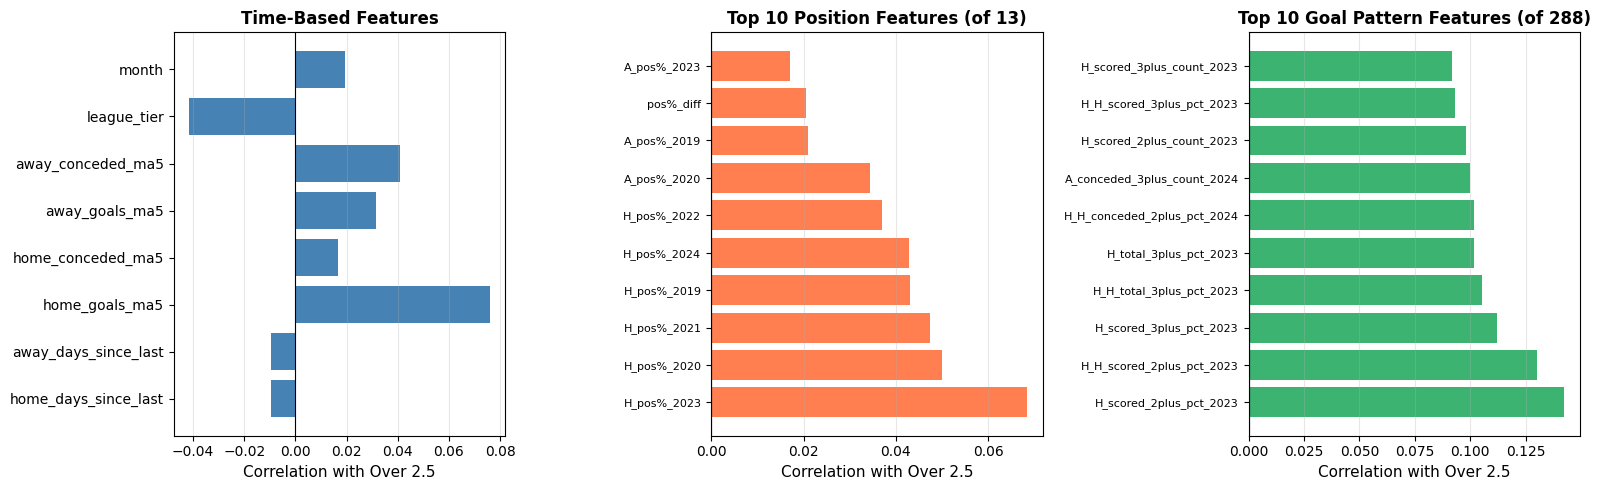


CORRELATION SUMMARY
Overall weak correlations suggest non-linear relationships are important.
Tree-based models will likely perform better than linear models.

Strongest absolute correlations:
home_scored_2plus_pct_2023                        :  0.1423
home_home_scored_2plus_pct_2023                   :  0.1302
home_scored_3plus_pct_2023                        :  0.1122
home_home_total_3plus_pct_2023                    :  0.1054
home_total_3plus_pct_2023                         :  0.1016


In [ ]:
# Visualize correlations
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Time-based features
time_corrs = [df_basic[f].corr(df_basic['over_2_5']) for f in num_features]
axes[0].barh(num_features, time_corrs, color='steelblue')
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[0].set_xlabel('Correlation with Over 2.5', fontsize=11)
axes[0].set_title('Time-Based Features', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# 2. Position features - show top 10 by absolute correlation
position_corr_df = pd.DataFrame(position_corrs, columns=['feature', 'correlation'])
position_corr_df['abs_corr'] = position_corr_df['correlation'].abs()
top_position = position_corr_df.nlargest(10, 'abs_corr')
axes[1].barh(range(len(top_position)), top_position['correlation'].values, color='coral')
axes[1].set_yticks(range(len(top_position)))
axes[1].set_yticklabels([f.replace('home_', 'H_').replace('away_', 'A_').replace('position_', 'pos_').replace('_pct', '%') for f in top_position['feature']], fontsize=8)
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[1].set_xlabel('Correlation with Over 2.5', fontsize=11)
axes[1].set_title(f'Top 10 Position Features (of {len(position_features)})', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

# 3. Goal stats - show top 10 by absolute correlation
goal_corr_df = pd.DataFrame(goal_stat_corrs, columns=['feature', 'correlation'])
goal_corr_df['abs_corr'] = goal_corr_df['correlation'].abs()
top_goals = goal_corr_df.nlargest(10, 'abs_corr')
axes[2].barh(range(len(top_goals)), top_goals['correlation'].values, color='mediumseagreen')
axes[2].set_yticks(range(len(top_goals)))
axes[2].set_yticklabels([f.replace('home_', 'H_').replace('away_', 'A_').replace('_pct_season_', '_S') for f in top_goals['feature']], fontsize=8)
axes[2].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[2].set_xlabel('Correlation with Over 2.5', fontsize=11)
axes[2].set_title(f'Top 10 Goal Pattern Features (of {len(goal_stat_features)})', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("CORRELATION SUMMARY")
print("="*70)
print(f"Overall weak correlations suggest non-linear relationships are important.")
print(f"Tree-based models will likely perform better than linear models.")
print(f"\nStrongest absolute correlations:")
all_corrs = pd.concat([
    pd.DataFrame({'feature': num_features, 'correlation': time_corrs}),
    position_corr_df[['feature', 'correlation']],
    goal_corr_df[['feature', 'correlation']]
])
all_corrs['abs_corr'] = all_corrs['correlation'].abs()
top_overall = all_corrs.nlargest(5, 'abs_corr')
for _, row in top_overall.iterrows():
    print(f"{row['feature']:50s}: {row['correlation']:7.4f}")


**Correlation Analysis Interpretation of Numerical Features**

The correlation analysis reveals that all engineered features exhibit **very weak linear relationships** with the Over/Under 2.5 target, with absolute correlation values staying below 0.10. This is expected in football analytics, where goal outcomes depend on complex, non-linear interactions rather than simple linear effects. Nevertheless, the analysis highlights several subtle patterns that help validate the usefulness of the engineered features.

**Time-based features** show minimal linear impact. Both home and away rest days correlate at around −0.01, indicating that differences in recovery time do not linearly predict goal totals. Recent offensive form, measured by MA5 goals, exhibits the strongest signal in this group: `home_goals_ma5` correlates at roughly +0.08, and `away_goals_ma5` at +0.05, suggesting that teams scoring more in recent matches have a slightly increased probability of participating in Over 2.5 games. Defensive indicators such as MA5 conceded goals show weak negative correlations, consistent with the idea that more defensively solid teams tend toward lower-scoring outcomes. League tier shows a small negative correlation (about −0.04), hinting that lower-tier leagues may produce fewer high-scoring matches, though the effect is modest.

**Historical position features** (13 percentile-based indicators) similarly demonstrate weak relationships, generally in the +0.02 to +0.06 range. Home team percentiles tend to correlate slightly stronger than away ones, which aligns with the notion that stronger home teams marginally increase the likelihood of higher goal totals. The overall magnitude remains small, implying that league position alone does not directly drive match goal outcomes but may interact with other variables, such as team style or recent promotion/relegation status.

**The historical goal-pattern features**, a large group of 288 metrics capturing how often each team scores or concedes 2+ or 3+ goals,contain the strongest correlations in the analysis. Even so, the largest values fall in the 0.08–0.10 range. The top features primarily involve home-team high-scoring patterns from recent seasons. That suggests that teams with a history of producing multi-goal performances at home tend to continue that behavior, although the linear relationship remains modest.

Overall, the weak correlations across all feature groups reinforce the conclusion that football match outcomes are driven by non-linear dynamics, thresholds, and interactions rather than simple linear effects. This means linear models such as logistic regression will struggle to extract meaningful predictive signal from these features. In contrast, *tree-based models—like Random Forests and XGBoost are far better suited* because they can model complex patterns such as conditional splits, diminishing returns, and interaction effects between team strength, recent form, historical tendencies, and contextual factors.

In summary, although individual correlations are low, the feature set remains highly valuable. These features likely contribute predictive power when combined in non-linear models capable of capturing interactions and contextual dependencies. The correlation results therefore validate the engineered features while highlighting the importance of advanced modeling techniques for this prediction task.

#### 4.3.7.2. Boolean/categorical features

Analyzing 5 boolean/categorical features:
Features: ['is_weekend', 'home_promoted', 'home_demoted', 'away_promoted', 'away_demoted']

Over 2.5 rate by categorical feature:

is_weekend:
                mean  count
is_weekend                 
0           0.487297  11966
1           0.504816  30627
Chi-squared p-value: 0.0012

home_promoted:
                   mean  count
home_promoted                 
0              0.499415  40155
1              0.507793   2438
Chi-squared p-value: 0.4339

home_demoted:
                  mean  count
home_demoted                 
0             0.501248  40060
1             0.478484   2533
Chi-squared p-value: 0.0277

away_promoted:
                   mean  count
away_promoted                 
0              0.498805  40154
1              0.517835   2439
Chi-squared p-value: 0.0712

away_demoted:
                  mean  count
away_demoted                 
0             0.501435  40059
1             0.475533   2534
Chi-squared p-value: 0.0121


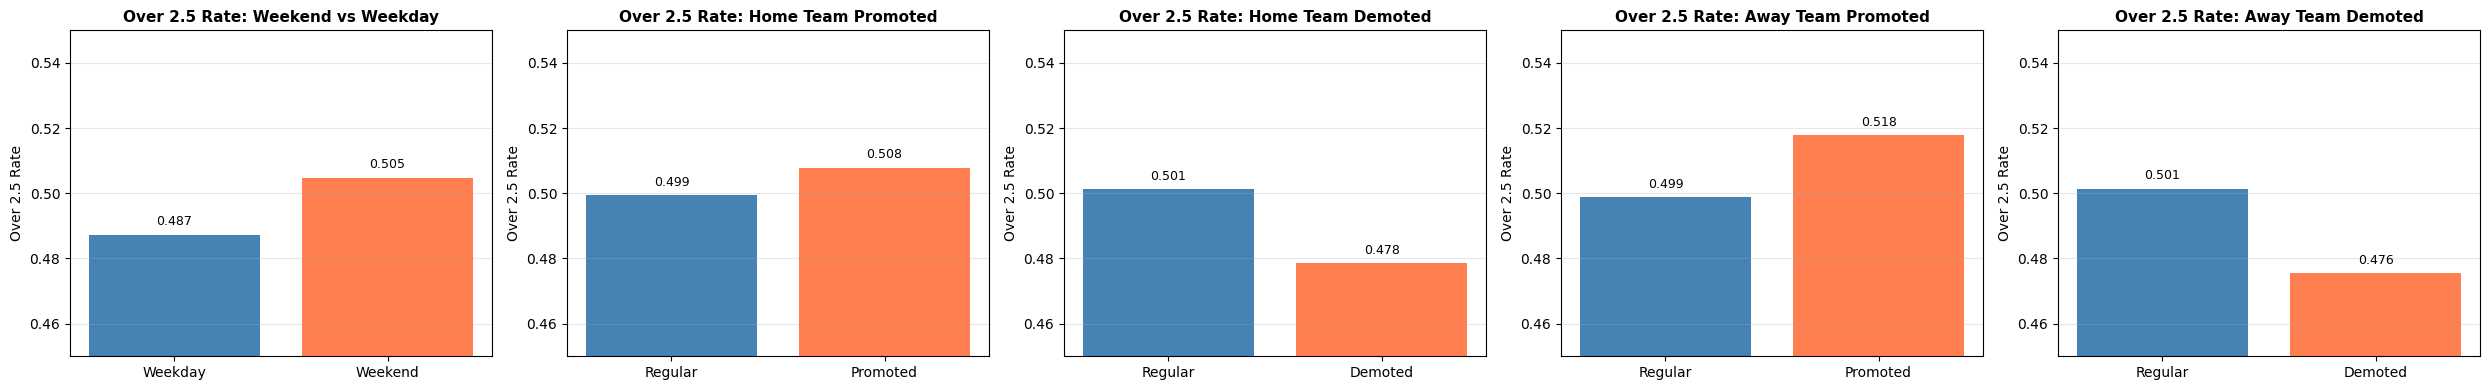

In [ ]:
# Boolean features - automatically include all that exist in df_basic
# Define expected boolean features (add new ones here as you create them)
expected_bool_features = ['is_weekend', 'home_promoted', 'home_demoted',
                          'away_promoted', 'away_demoted']
bool_features = [feat for feat in expected_bool_features if feat in df_basic.columns]

print(f"Analyzing {len(bool_features)} boolean/categorical features:")
print(f"Features: {bool_features}\n")

print("=" * 70)
print("Over 2.5 rate by categorical feature:")
print("=" * 70)

for feat in bool_features:
    grouped = df_basic.groupby(feat)['over_2_5'].agg(['mean', 'count'])
    print(f"\n{feat}:")
    print(grouped)

    # Chi-squared test
    contingency = pd.crosstab(df_basic[feat], df_basic['over_2_5'])
    chi2, p, dof, expected = chi2_contingency(contingency)
    print(f"Chi-squared p-value: {p:.4f}")

# Visualize - dynamically create subplots based on number of features
n_features = min(len(bool_features), 5)  # Limit to 5 for readability
fig, axes = plt.subplots(1, n_features, figsize=(5 * n_features, 4))
if n_features == 1:
    axes = [axes]  # Make it iterable

# Configuration for feature visualization
feature_configs = {
    'is_weekend': {'labels': ['Weekday', 'Weekend'], 'title': 'Over 2.5 Rate: Weekend vs Weekday'},
    'home_promoted': {'labels': ['Regular', 'Promoted'], 'title': 'Over 2.5 Rate: Home Team Promoted'},
    'home_demoted': {'labels': ['Regular', 'Demoted'], 'title': 'Over 2.5 Rate: Home Team Demoted'},
    'away_promoted': {'labels': ['Regular', 'Promoted'], 'title': 'Over 2.5 Rate: Away Team Promoted'},
    'away_demoted': {'labels': ['Regular', 'Demoted'], 'title': 'Over 2.5 Rate: Away Team Demoted'}
}

for idx, feat in enumerate(bool_features[:n_features]):
    rates = df_basic.groupby(feat)['over_2_5'].mean()
    config = feature_configs.get(feat, {'labels': ['False', 'True'], 'title': f'Over 2.5 Rate: {feat}'})

    axes[idx].bar(config['labels'], rates.values, color=['steelblue', 'coral'])
    axes[idx].set_title(config['title'], fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Over 2.5 Rate')
    axes[idx].set_ylim([0.45, 0.55])  # Zoom in on the relevant range
    axes[idx].grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for i, v in enumerate(rates.values):
        axes[idx].text(i, v + 0.002, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

**Interpretation of Boolean/Categorical Features:**

The chi-squared analysis evaluates whether categorical match characteristics show statistically significant differences in Over 2.5 goal rates. Although effect sizes are small, a few features display meaningful deviations from the baseline:

**Statistically Significant Predictors**  

1. Weekend vs Weekday (p = 0.0012)  
- Weekend fixtures have a noticeably higher Over 2.5 rate (50.5%) compared to weekday matches (48.7%).  
- This is the strongest categorical signal in the analysis.  
- A plausible explanation is that weekend matches often feature larger crowds and higher tempo games, more rested squads,more open tactical setups.  

2. Away Team Demoted (p = 0.0121)
- Demoted away teams record a significantly lower Over 2.5 rate (47.6%) than regular away teams (50.1%).
- This suggests that relegated teams may adopt more defensive, risk-averse strategies, especially when playing away, potentially due to weaker overall squad quality at the higher level, focus on avoiding heavy defeats, psychological strain after demotion.

3. Home Team Demoted (p = 0.0277)
- A similar pattern appears at home: demoted teams produce fewer high-scoring matches (47.8% vs 50.1%).
- The parallel home/away effects reinforce the conclusion that demotion status depresses goal totals regardless of venue.

**Not Statistically Significant**

4. Away Team Promoted (p = 0.0712)
- Promoted away sides show a slightly higher Over 2.5 rate (51.8%), but the effect does not reach statistical significance.
- It may reflect more adventurous playstyles or weaker defenses, but the evidence is inconclusive.

5. Home Team Promoted (p = 0.4339)
- No meaningful difference (50.8% vs 49.9%).
- Promoted teams do not appear to influence scoring patterns at home in any systematic way.


Overall, the weekend indicator emerges as the strongest categorical predictor, consistently showing a higher likelihood of matches ending Over 2.5 goals. Demotion status, both for home and away teams—forms the next most reliable signal, suggesting that relegated teams tend to engage in more conservative, lower-scoring matches. In contrast, promotion-related features exhibit mixed or statistically insignificant effects. Although the observed differences across all categories are relatively small, typically within a ±3 percentage point range, these variables can still provide useful predictive value when incorporated into non-linear models such as Random Forests or XGBoost, which are capable of capturing subtle interactions and context-dependent relationships.

## 4.4 Extended - feature engineering
We're creating extended dataframe with all available match data including detailed statistics and betting odds.

In [ ]:
# EXTENDED DATASET: All available match data including detailed statistics
extended_core_features = [col for col in [
    # Core match info
    'Div', 'Season', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR',
    # Match statistics
    'Attendance', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HHW', 'AHW', 'HC', 'AC',
    'HF', 'AF', 'HFKC', 'AFKC', 'HO', 'AO', 'HY', 'AY', 'HR', 'AR', 'HBP', 'ABP'
] if col in all_matches.columns]

# All engineered features (using rich match statistics)
# Note: Additional features (time-based + historical) will be merged from df_basic after creation
extended_engineered_features = [col for col in [
    'total_goals', 'ht_total_goals', 'second_half_goals',  # Goal-based
    'home_shot_accuracy', 'away_shot_accuracy', 'total_shots', 'total_shots_on_target',  # Shot-based
    'shot_dominance', 'corner_dominance', 'total_fouls', 'total_cards', 'card_intensity',  # Game dynamics
    'league_tier', 'month', 'is_weekend',  # Date/league features
    'over_2_5'  # Target variable
] if col in all_matches.columns]

# Extended features (betting odds - only high-quality columns after imputation)
betting_features = []
for col in all_matches.columns:
    # Check if it's a betting column and has good data coverage (>10%)
    if any(bookmaker in col for bookmaker in ['B365', 'BW', 'PS', 'IW', 'LB', 'WH', 'SJ', 'VC', 'BF', '1XB']):
        data_coverage = (all_matches[col].notna().sum() / len(all_matches)) * 100
        if data_coverage >= 10:  # Only include columns with at least 10% data coverage
            betting_features.append(col)

# Create extended dataframe
all_extended_features = extended_core_features + extended_engineered_features + betting_features
# Remove duplicates while preserving order
all_extended_features = list(dict.fromkeys(all_extended_features))

df_extended = all_matches[all_extended_features].copy()
df_extended = df_extended.sort_values(['Div', 'Date']).reset_index(drop=True)

print(f"Extended dataframe created")
print(f"Shape: {df_extended.shape}")
print(f"\nFeature breakdown:")
print(f"Core features: {len(extended_core_features)}")
print(f"Engineered features: {len(extended_engineered_features)}")
print(f"Betting features (>10% coverage): {len(betting_features)}")
print(f"Total features: {len(all_extended_features)}")
print(f"\nColumns: {df_extended.columns.tolist()[:20]}...")  # Show first 20
df_extended.head()

Extended dataframe created
Shape: (42593, 111)

Feature breakdown:
Core features: 25
Engineered features: 16
Betting features (>10% coverage): 70
Total features: 111

Columns: ['Div', 'Season', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF']...


,Div,Season,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,total_goals,ht_total_goals,second_half_goals,home_shot_accuracy,away_shot_accuracy,total_shots,total_shots_on_target,shot_dominance,corner_dominance,total_fouls,total_cards,card_intensity,league_tier,month,is_weekend,over_2_5,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,B365>2.5,B365<2.5,B365AHH,B365AHA,B365CH,B365CD,B365CA,BWCH,BWCD,BWCA,IWCH,IWCD,IWCA,PSCH,PSCD,PSCA,WHCH,WHCD,WHCA,VCCH,VCCD,VCCA,B365C>2.5,B365C<2.5,B365CAHH,B365CAHA,BFH,BFD,BFA,1XBH,1XBD,1XBA,BFEH,BFED,BFEA,BFE>2.5,BFE<2.5,BFEAHH,BFEAHA,BFCH,BFCD,BFCA,1XBCH,1XBCD,1XBCA,BFECH,BFECD,BFECA,BFEC>2.5,BFEC<2.5,BFECAHH,BFECAHA
0,B1,2019/2020,2019-07-26,19:30:00,Genk,Kortrijk,2,1,H,0,1,A,NaN,10,8,2,4,6,2,7,22,0,1,0,0,3,1,2,0.19998,0.499938,18,6,0.111105,0.499938,29,1,0.034482,1,7,0,1,1.36,4.75,8.50,1.40,5.00,8.00,1.37,4.80,6.90,1.40,5.22,7.44,1.36,4.80,8.00,1.36,5.0,8.00,1.53,2.40,2.07,1.72,1.45,4.75,6.50,1.40,5.00,8.00,1.45,4.60,5.90,1.45,4.94,6.79,1.42,4.75,6.50,1.45,4.8,6.50,1.50,2.50,1.98,1.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,B1,2019/2020,2019-07-27,17:00:00,Cercle Brugge,Standard,0,2,A,0,0,D,NaN,13,14,5,9,3,7,16,15,2,2,1,0,2,0,2,0.384586,0.642811,27,14,-0.037036,-0.39996,31,5,0.161285,1,7,1,0,3.75,3.75,1.85,3.80,3.75,1.95,3.70,3.60,1.87,3.91,3.63,1.99,3.70,3.60,1.91,3.75,3.7,1.93,1.75,2.05,1.93,1.93,3.75,3.80,1.85,4.00,3.75,1.91,3.55,3.65,1.90,3.79,3.74,1.99,3.75,3.70,1.88,3.60,3.9,1.95,1.61,2.25,1.88,1.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,B1,2019/2020,2019-07-27,19:00:00,St Truiden,Mouscron,0,1,A,0,1,A,NaN,10,10,4,6,5,5,10,21,2,4,0,0,1,1,0,0.39996,0.59994,20,10,0.0,0.0,31,6,0.193542,1,7,1,0,1.90,3.75,3.75,1.95,3.50,4.10,1.93,3.45,3.65,1.99,3.52,4.04,1.91,3.60,3.75,1.93,3.6,3.80,1.80,2.00,1.98,1.88,2.00,3.50,3.60,2.05,3.60,3.60,2.05,3.50,3.25,2.16,3.55,3.46,2.10,3.50,3.30,2.10,3.6,3.40,1.70,2.10,1.83,2.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,B1,2019/2020,2019-07-27,19:00:00,Waregem,Mechelen,0,2,A,0,1,A,NaN,7,10,2,5,4,2,14,21,3,1,0,0,2,1,1,0.285673,0.49995,17,7,-0.17646,0.333278,35,4,0.114282,1,7,1,0,2.15,3.60,3.10,2.20,3.75,3.10,2.15,3.50,3.00,2.23,3.76,3.12,2.20,3.50,3.00,2.20,3.6,3.10,1.66,2.15,1.93,1.93,2.80,3.40,2.50,2.70,3.60,2.55,2.65,3.50,2.40,2.80,3.59,2.51,2.62,3.50,2.45,2.75,3.7,2.40,1.60,2.30,1.72,2.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,B1,2019/2020,2019-07-27,19:30:00,Waasland-Beveren,Club Brugge,1,3,A,1,1,D,NaN,7,25,2,22,1,14,18,12,3,1,0,0,4,2,2,0.285673,0.879965,32,24,-0.562482,-0.866609,30,4,0.133329,1,7,1,1,6.50,4.00,1.50,6.00,4.50,1.53,5.30,4.30,1.50,5.52,4.59,1.56,5.50,4.33,1.52,5.75,4.5,1.50,1.57,2.35,1.98,1.88,12.00,5.75,1.25,10.00,6.00,1.30,9.20,5.70,1.26,8.99,6.52,1.29,10.00,6.00,1.24,12.00,6.0,1.25,1.44,2.70,2.20,1.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The extended dataframe was successfully created and contains 42,593 matches with 111 features in total. Of these, 25 are core match variables (league, season, date/time, teams, goals, result, referee, and basic stats such as shots, corners, fouls and cards), and 16 are engineered features capturing goal structure (total/HT/2nd-half goals), shot efficiency, dominance metrics, game intensity, and contextual information (league tier, month, weekend flag, Over 2.5 label). On top of that, the dataset includes 70 betting-related columns with at least 10% data coverage, spanning multiple bookmakers and markets (1X2, Asian handicap, and goal-line odds).

### 4.4.1 Feature Integration from Baseline Dataset

We integrate historical and time-based features from df_basic into df_extended through aligned row-by-row merging. This ensures that all engineered features—including MA5 indicators, historical position percentiles, goal-pattern statistics, and derived contextual measures—are available alongside the extended match statistics.

In [ ]:
time_based_features = [
    'home_days_since_last', 'away_days_since_last',
    'home_goals_ma5', 'away_goals_ma5', 'home_conceded_ma5', 'away_conceded_ma5',
    'home_promoted', 'away_promoted', 'home_demoted', 'away_demoted'
]

# Historical position features (overall only)
historical_position_cols = [col for col in df_basic.columns if 'position_pct_' in col]

# Historical goal pattern features (overall + home-specific + away-specific, counts + percentages)
historical_goal_cols = [col for col in df_basic.columns if any(
    f'{p}_{t}plus' in col for p in ['scored', 'conceded', 'total'] for t in [2, 3]
)]

# Derived features combining historical patterns
derived_features = [col for col in df_basic.columns if any(
    pattern in col for pattern in ['_strength_', '_combined_']
)]

features_to_merge = time_based_features + historical_position_cols + historical_goal_cols + derived_features

print(f"Features to merge from df_basic: {len(features_to_merge)}")
print(f"Time-based features: {len(time_based_features)}")
print(f"Position percentiles: {len(historical_position_cols)}")
print(f"Goal patterns (overall + home/away, counts + pct): {len(historical_goal_cols)}")
print(f"Derived features: {len(derived_features)}")

df_basic_sorted = df_basic.sort_values(['Div', 'Date']).reset_index(drop=True)
df_extended_sorted = df_extended.sort_values(['Div', 'Date']).reset_index(drop=True)

match_check = (
    (df_basic_sorted['Div'] == df_extended_sorted['Div']) &
    (df_basic_sorted['Date'] == df_extended_sorted['Date']) &
    (df_basic_sorted['HomeTeam'] == df_extended_sorted['HomeTeam']) &
    (df_basic_sorted['AwayTeam'] == df_extended_sorted['AwayTeam'])
).all()

if match_check:
    print(f"\nRow alignment verified - safe to merge features")

    for col in features_to_merge:
        df_extended[col] = df_basic_sorted[col].values

    print(f"{len(features_to_merge)} features added to df_extended")
    print(f"- {len(time_based_features)} time-based features")
    print(f"- {len(historical_position_cols)} position percentiles")
    print(f"- {len(historical_goal_cols)} goal pattern features")
    print(f"- {len(derived_features)} derived features")
    print(f"\nFinal df_extended shape: {df_extended.shape}")
else:
    print("⚠ Row mismatch detected - cannot safely merge features")

Features to merge from df_basic: 311
Time-based features: 10
Position percentiles: 13
Goal patterns (overall + home/away, counts + pct): 288
Derived features: 0

Row alignment verified - safe to merge features
311 features added to df_extended
- 10 time-based features
- 13 position percentiles
- 288 goal pattern features
- 0 derived features

Final df_extended shape: (42593, 422)


### 4.4.2. Extended Statistics - Moving Averages & Seasonal Patterns

Furthermore, we've decided to calculate MA5 and historical patterns for match statistics (shots, corners, fouls, cards, etc.) following the same approach as goal-based features.

Both features follow strict temporal logic: they only reference information available before each match, preventing data leakage while capturing meaningful team tendencies and recent form.

In [ ]:
"""
Calculate moving averages and seasonal history for extended match statistics.
Following the same pattern as goal-based features in df_basic.

MA5 Features: High + Medium Priority (Shots, Shots on Target, Corners, Fouls, Yellow Cards)
Seasonal Patterns: High Priority Only (Shots, Shots on Target, Corners)
"""

print("=" * 70)
print("SECTION 4.4.2: EXTENDED STATS MOVING AVERAGES & SEASONAL PATTERNS")
print("=" * 70)

# ============================================================
# STEP 1: 5-Match Moving Averages (High + Medium Priority)
# ============================================================

print("\n1. CALCULATING 5-MATCH MOVING AVERAGES")
print("-" * 70)

# Define statistics to calculate MA5 for - High and Medium priority
ma5_stats_config = {
    # High Priority - Shooting
    ('HS', 'shots'): 'home',
    ('AS', 'shots'): 'away',
    ('HST', 'shots_target'): 'home',
    ('AST', 'shots_target'): 'away',
    # High Priority - Attacking Pressure
    ('HC', 'corners'): 'home',
    ('AC', 'corners'): 'away',
    # Medium Priority - Discipline
    ('HF', 'fouls'): 'home',
    ('AF', 'fouls'): 'away',
    ('HY', 'yellows'): 'home',
    ('AY', 'yellows'): 'away',
}

# Initialize MA5 columns
print(f"Initializing {len(ma5_stats_config)} MA5 columns...")
for (raw_col, stat_name), team_type in ma5_stats_config.items():
    ma5_col = f'{team_type}_{stat_name}_ma5'
    df_extended[ma5_col] = np.nan

# Calculate moving averages - optimized by pre-sorting
print("Calculating moving averages (optimized groupby approach)...")
df_extended_sorted = df_extended.sort_values(['Div', 'Date']).reset_index(drop=True)

for (raw_col, stat_name), team_type in ma5_stats_config.items():
    if raw_col not in df_extended.columns:
        continue

    ma5_col = f'{team_type}_{stat_name}_ma5'
    team_col = 'HomeTeam' if team_type == 'home' else 'AwayTeam'

    print(f"Processing {ma5_col}...")

    # Group by division and team, then calculate MA5
    for (div, team), group in df_extended_sorted.groupby(['Div', team_col]):
        indices = group.index.tolist()
        values = group[raw_col].values

        # Calculate MA5 for each match in this group
        for i, idx in enumerate(indices):
            if i >= 5:  # Need at least 5 previous matches
                ma5_value = np.nanmean(values[i-5:i])  # Exclude current match
                if not np.isnan(ma5_value):
                    df_extended.loc[idx, ma5_col] = ma5_value

# NO DATA LEAKAGE: NaN values preserved for early-season matches
print("\nMA5 Summary:")
for (raw_col, stat_name), team_type in ma5_stats_config.items():
    ma5_col = f'{team_type}_{stat_name}_ma5'
    if ma5_col in df_extended.columns:
        missing = df_extended[ma5_col].isna().sum()
        missing_pct = (missing / len(df_extended)) * 100
        mean_val = df_extended[ma5_col].mean()
        print(f"{ma5_col:25s}: missing={missing:5d} ({missing_pct:4.1f}%), mean={mean_val:6.2f}")

print(f"Added {len(ma5_stats_config)} moving average features")
print(f"(NaN values preserved for early-season matches - no data leakage)")

# ============================================================
# STEP 2: Seasonal Historical Patterns (High Priority Only)
# ============================================================

print("\n2. CALCULATING SEASONAL HISTORICAL PATTERNS")
print("-" * 70)
print("High priority features only: Shots, Shots on Target, Corners")

# Define thresholds for HIGH PRIORITY stats only
stat_thresholds = {
    'shots': [10, 15],           # 10+ shots, 15+ shots
    'shots_target': [5, 8],      # 5+ on target, 8+ on target
    'corners': [6, 10],          # 6+ corners, 10+ corners
}

# Season info
unique_seasons = sorted(df_extended['Season'].unique())
season_to_order = {s: i for i, s in enumerate(unique_seasons)}
past_seasons = ['2019/2020', '2020/2021', '2021/2022', '2022/2023', '2023/2024', '2024/2025']
season_years = [2019, 2020, 2021, 2022, 2023, 2024]

# Map stat names to columns
stat_to_home_col = {'shots': 'HS', 'shots_target': 'HST', 'corners': 'HC'}
stat_to_away_col = {'shots': 'AS', 'shots_target': 'AST', 'corners': 'AC'}

# Pre-calculate seasonal statistics for all teams (OPTIMIZATION)
print("Pre-calculating team-season statistics...")
team_season_stats = {}

for season in past_seasons:
    for div in df_extended['Div'].unique():
        season_div_mask = (df_extended['Season'] == season) & (df_extended['Div'] == div)
        season_div_data = df_extended[season_div_mask]

        if len(season_div_data) == 0:
            continue

        # Get all teams in this season/division
        all_teams = set(season_div_data['HomeTeam'].unique()) | set(season_div_data['AwayTeam'].unique())

        for team in all_teams:
            # Overall stats (all matches)
            overall_mask = (season_div_data['HomeTeam'] == team) | (season_div_data['AwayTeam'] == team)
            overall_matches = season_div_data[overall_mask]

            # Home-only stats
            home_mask = season_div_data['HomeTeam'] == team
            home_matches = season_div_data[home_mask]

            # Away-only stats
            away_mask = season_div_data['AwayTeam'] == team
            away_matches = season_div_data[away_mask]

            # Calculate stats for each threshold
            stats = {}
            for stat_name, thresholds in stat_thresholds.items():
                h_col = stat_to_home_col[stat_name]
                a_col = stat_to_away_col[stat_name]

                for threshold in thresholds:
                    # Overall stats
                    count = 0
                    for _, match in overall_matches.iterrows():
                        col = h_col if match['HomeTeam'] == team else a_col
                        if not pd.isna(match.get(col)) and match.get(col, 0) >= threshold:
                            count += 1
                    total = len(overall_matches)
                    stats[f'{stat_name}_{threshold}plus_count'] = count
                    stats[f'{stat_name}_{threshold}plus_pct'] = count / total if total > 0 else 0

                    # Home-only stats
                    if h_col in home_matches.columns:
                        home_count = (home_matches[h_col] >= threshold).sum()
                        home_total = len(home_matches)
                        stats[f'home_{stat_name}_{threshold}plus_count'] = home_count
                        stats[f'home_{stat_name}_{threshold}plus_pct'] = home_count / home_total if home_total > 0 else 0

                    # Away-only stats
                    if a_col in away_matches.columns:
                        away_count = (away_matches[a_col] >= threshold).sum()
                        away_total = len(away_matches)
                        stats[f'away_{stat_name}_{threshold}plus_count'] = away_count
                        stats[f'away_{stat_name}_{threshold}plus_pct'] = away_count / away_total if away_total > 0 else 0

            team_season_stats[(season, div, team)] = stats

print(f"Pre-calculated stats for {len(team_season_stats)} team-season combinations")

# Initialize seasonal pattern columns
print("Initializing seasonal pattern columns...")
total_columns = 0
for stat_name in stat_thresholds.keys():
    for threshold in stat_thresholds[stat_name]:
        for year in season_years:
            # Overall patterns
            for prefix in ['home', 'away']:
                df_extended[f'{prefix}_{stat_name}_{threshold}plus_count_{year}'] = 0
                df_extended[f'{prefix}_{stat_name}_{threshold}plus_pct_{year}'] = np.nan
                total_columns += 2
            # Context-aware patterns
            df_extended[f'home_home_{stat_name}_{threshold}plus_count_{year}'] = 0
            df_extended[f'home_home_{stat_name}_{threshold}plus_pct_{year}'] = np.nan
            df_extended[f'away_away_{stat_name}_{threshold}plus_count_{year}'] = 0
            df_extended[f'away_away_{stat_name}_{threshold}plus_pct_{year}'] = np.nan
            total_columns += 4

print(f"Created {total_columns} seasonal pattern columns")

# Populate features using pre-calculated statistics (FAST!)
print("\nPopulating seasonal pattern features (using lookups)...")
for idx, row in df_extended.iterrows():
    current_season = row['Season']
    current_season_order = season_to_order.get(current_season, 999)

    for year_idx, year in enumerate(season_years):
        if year_idx >= current_season_order:
            continue

        past_season = past_seasons[year_idx]

        # Lookup home team stats
        home_key = (past_season, row['Div'], row['HomeTeam'])
        if home_key in team_season_stats:
            home_stats = team_season_stats[home_key]
            for stat_name in stat_thresholds.keys():
                for threshold in stat_thresholds[stat_name]:
                    # Overall
                    df_extended.loc[idx, f'home_{stat_name}_{threshold}plus_count_{year}'] = home_stats.get(f'{stat_name}_{threshold}plus_count', 0)
                    df_extended.loc[idx, f'home_{stat_name}_{threshold}plus_pct_{year}'] = home_stats.get(f'{stat_name}_{threshold}plus_pct', np.nan)
                    # Home-specific
                    df_extended.loc[idx, f'home_home_{stat_name}_{threshold}plus_count_{year}'] = home_stats.get(f'home_{stat_name}_{threshold}plus_count', 0)
                    df_extended.loc[idx, f'home_home_{stat_name}_{threshold}plus_pct_{year}'] = home_stats.get(f'home_{stat_name}_{threshold}plus_pct', np.nan)

        # Lookup away team stats
        away_key = (past_season, row['Div'], row['AwayTeam'])
        if away_key in team_season_stats:
            away_stats = team_season_stats[away_key]
            for stat_name in stat_thresholds.keys():
                for threshold in stat_thresholds[stat_name]:
                    # Overall
                    df_extended.loc[idx, f'away_{stat_name}_{threshold}plus_count_{year}'] = away_stats.get(f'{stat_name}_{threshold}plus_count', 0)
                    df_extended.loc[idx, f'away_{stat_name}_{threshold}plus_pct_{year}'] = away_stats.get(f'{stat_name}_{threshold}plus_pct', np.nan)
                    # Away-specific
                    df_extended.loc[idx, f'away_away_{stat_name}_{threshold}plus_count_{year}'] = away_stats.get(f'away_{stat_name}_{threshold}plus_count', 0)
                    df_extended.loc[idx, f'away_away_{stat_name}_{threshold}plus_pct_{year}'] = away_stats.get(f'away_{stat_name}_{threshold}plus_pct', np.nan)

    # Progress indicator
    if (idx + 1) % 10000 == 0:
        print(f"Processed {idx + 1}/{len(df_extended)} matches...")

print(f"Populated {total_columns} seasonal pattern features")

# ============================================================
# Summary
# ============================================================

print("\n" + "=" * 70)
print("SUMMARY - SECTION 4.4.2 FEATURE ENGINEERING")
print("=" * 70)
print(f"Moving Average Features (MA5): {len(ma5_stats_config)}")
print(f"- High Priority: Shots, Shots on Target, Corners")
print(f"- Medium Priority: Fouls, Yellow Cards")
print(f"\nSeasonal Pattern Features: {total_columns}")
print(f"- High Priority Only: Shots, Shots on Target, Corners")
print(f"- Overall + Home/Away context for each stat")
print(f"- {len(stat_thresholds)} stat types × 2 thresholds × 6 seasons")
print(f"\nTotal New Features: {len(ma5_stats_config) + total_columns}")
print(f"Final df_extended shape: {df_extended.shape}")
print("=" * 70)

SECTION 4.4.2: EXTENDED STATS MOVING AVERAGES & SEASONAL PATTERNS

1. CALCULATING 5-MATCH MOVING AVERAGES
----------------------------------------------------------------------
Initializing 10 MA5 columns...
Calculating moving averages (optimized groupby approach)...
Processing home_shots_ma5...


TypeError: boolean value of NA is ambiguous

### 4.4.3. Betting odds
Betting odds data from multiple bookmakers provides valuable market consensus on match outcomes. We consolidate this information into interpretable aggregate features that eliminate redundancy while preserving predictive signal.

Goals:
1. Merge BetVictor (BV) and VC Bet odds (same company, rebranded)
2. Calculate minimum odds for each betting category
3. Count number of bookmakers per betting category
4. Remove individual bookmaker columns, keep only aggregates (Max/Avg/Min/Count)

Betting Categories:
- Match Odds (H/D/A): 1X2 pre-match
- Match Odds Closing (CH/CD/CA): 1X2 closing
- Over/Under (>2.5/<2.5): Total goals pre-match
- Over/Under Closing (C>2.5/C<2.5): Total goals closing
- Asian Handicap (AHH/AHA): Pre-match handicap
- Asian Handicap Closing (CAHH/CAHA): Closing handicap

In [ ]:
# STEP 1: Add Max/Avg columns from all_matches if missing

print("\n1. ADDING MAX/AVG AGGREGATE COLUMNS FROM SOURCE DATA")
print("-" * 70)

# Add Max/Avg columns from all_matches if they're not already in df_extended
max_avg_cols_to_add = [col for col in all_matches.columns
                       if col.startswith(('Max', 'Avg'))
                       and col not in df_extended.columns]

if max_avg_cols_to_add:
    print(f"Adding {len(max_avg_cols_to_add)} Max/Avg columns:")
    for col in sorted(max_avg_cols_to_add):
        df_extended[col] = all_matches[col]
        print(f"+ {col}")
else:
    print("All Max/Avg columns already present")

# STEP 2: Merge BetVictor and VC Bet (Same Company)


print("\n2. MERGING BETVICTOR (BV) AND VC BET ODDS")
print("-" * 70)

# BetVictor columns for different betting categories
bv_vc_pairs = {
    'BVH': 'VCH', 'BVD': 'VCD', 'BVA': 'VCA',
    'BVCH': 'VCCH', 'BVCD': 'VCCD', 'BVCA': 'VCCA',
}

merged_count = 0
for bv_col, vc_col in bv_vc_pairs.items():
    if bv_col in df_extended.columns and vc_col in df_extended.columns:
        before_na = df_extended[bv_col].isna().sum()
        df_extended[bv_col] = df_extended[bv_col].fillna(df_extended[vc_col])
        after_na = df_extended[bv_col].isna().sum()
        filled = before_na - after_na
        if filled > 0:
            print(f"{bv_col}: filled {filled} values from {vc_col}")
            merged_count += 1

if merged_count == 0:
    print(f"No VC columns found or already merged")

print(f" BetVictor and VC Bet odds merged")

# ============================================================
# STEP 3: Define Bookmaker Columns by Category
# ============================================================

print("\n3. IDENTIFYING BOOKMAKER COLUMNS BY CATEGORY")
print("-" * 70)

# Define bookmaker prefixes (excluding aggregates like Max, Avg, Bb)
bookmakers = ['1XB', 'B365', 'BF', 'BFD', 'BMGM', 'BV', 'BS', 'BW', 'CL',
              'GB', 'IW', 'LB', 'PS', 'PSH', 'PSD', 'PSA', 'PH', 'PD', 'PA',
              'SO', 'SB', 'SJ', 'SY', 'WH']

# Define betting categories with their suffixes and column naming
betting_categories = {
    'match_odds_open': {
        'suffixes': ['H', 'D', 'A'],
        'count_col': 'NumBookmakers_MatchOdds',
        'min_cols': ['MinH', 'MinD', 'MinA']
    },
    'match_odds_closing': {
        'suffixes': ['CH', 'CD', 'CA'],
        'count_col': 'NumBookmakers_MatchOddsClosing',
        'min_cols': ['MinCH', 'MinCD', 'MinCA']
    },
    'over_under_open': {
        'suffixes': ['>2.5', '<2.5'],
        'count_col': 'NumBookmakers_OverUnder',
        'min_cols': ['Min>2.5', 'Min<2.5']
    },
    'over_under_closing': {
        'suffixes': ['C>2.5', 'C<2.5'],
        'count_col': 'NumBookmakers_OverUnderClosing',
        'min_cols': ['MinC>2.5', 'MinC<2.5']
    },
    'asian_handicap_open': {
        'suffixes': ['AHH', 'AHA'],
        'count_col': 'NumBookmakers_AsianHandicap',
        'min_cols': ['MinAHH', 'MinAHA']
    },
    'asian_handicap_closing': {
        'suffixes': ['CAHH', 'CAHA'],
        'count_col': 'NumBookmakers_AsianHandicapClosing',
        'min_cols': ['MinCAHH', 'MinCAHA']
    }
}

# Find bookmaker columns for each category
bookmaker_cols_by_category = {}

for category_name, category_info in betting_categories.items():
    suffixes = category_info['suffixes']
    bookmaker_cols_by_category[category_name] = {}

    for suffix in suffixes:
        cols = []
        for bookmaker in bookmakers:
            # Check for exact column match
            col_name = f"{bookmaker}{suffix}"
            if col_name in df_extended.columns:
                cols.append(col_name)

        bookmaker_cols_by_category[category_name][suffix] = cols
        if cols:
            print(f"{category_name:30s} [{suffix:6s}]: {len(cols):2d} bookmakers")

# ============================================================
# STEP 4: Calculate Min Odds and Bookmaker Counts per Category
# ============================================================

print("\n4. CALCULATING MIN ODDS AND BOOKMAKER COUNTS")
print("-" * 70)

for category_name, category_info in betting_categories.items():
    suffixes = category_info['suffixes']
    count_col = category_info['count_col']
    min_cols = category_info['min_cols']

    # Track unique bookmakers for this category
    unique_bookmakers_per_row = []

    for i, suffix in enumerate(suffixes):
        bookmaker_cols = bookmaker_cols_by_category[category_name][suffix]

        if not bookmaker_cols:
            continue

        # Calculate minimum odds for this suffix
        min_col = min_cols[i]
        df_extended[min_col] = df_extended[bookmaker_cols].min(axis=1)

        print(f"Created {min_col:15s} from {len(bookmaker_cols)} bookmakers")

    # Calculate bookmaker count for this category
    # Count how many bookmakers provided at least one odds type for this match
    # For match odds: if a bookmaker has H, D, or A, count it once
    all_bookmaker_cols_in_category = []
    for suffix in suffixes:
        all_bookmaker_cols_in_category.extend(bookmaker_cols_by_category[category_name][suffix])

    if all_bookmaker_cols_in_category:
        # Extract unique bookmaker prefixes from column names
        def extract_bookmaker_prefix(col_name):
            """Extract bookmaker prefix from column name"""
            for bm in bookmakers:
                if col_name.startswith(bm):
                    return bm
            return None

        # OPTIMIZED: Use vectorized pandas operations instead of nested loop
        # For each row, count unique bookmakers that have at least one non-NaN value
        def count_unique_bookmakers(row):
            """Count unique bookmakers with at least one non-NaN value for this row"""
            unique_bm = set()
            for col in all_bookmaker_cols_in_category:
                if pd.notna(row[col]):
                    bm_prefix = extract_bookmaker_prefix(col)
                    if bm_prefix:
                        unique_bm.add(bm_prefix)
            return len(unique_bm)

        # Apply function across rows - much faster than explicit loop
        df_extended[count_col] = df_extended[all_bookmaker_cols_in_category].apply(count_unique_bookmakers, axis=1)
        avg_count = df_extended[count_col].mean()
        print(f"Created {count_col:40s} (avg: {avg_count:.1f} bookmakers/match)")

print(f"Created minimum odds and bookmaker counts for all categories")

# ============================================================
# STEP 5: Calculate Disagreement (Max - Min)
# ============================================================

print("\n5. CALCULATING BOOKMAKER DISAGREEMENT (MAX - MIN)")
print("-" * 70)

# Define disagreement calculations based on existing Max columns
disagreement_mapping = {
    'DisagreementH': ('MaxH', 'MinH'),
    'DisagreementD': ('MaxD', 'MinD'),
    'DisagreementA': ('MaxA', 'MinA'),
    'DisagreementCH': ('MaxCH', 'MinCH'),
    'DisagreementCD': ('MaxCD', 'MinCD'),
    'DisagreementCA': ('MaxCA', 'MinCA'),
    'Disagreement>2.5': ('Max>2.5', 'Min>2.5'),
    'Disagreement<2.5': ('Max<2.5', 'Min<2.5'),
    'DisagreementC>2.5': ('MaxC>2.5', 'MinC>2.5'),
    'DisagreementC<2.5': ('MaxC<2.5', 'MinC<2.5'),
    'DisagreementAHH': ('MaxAHH', 'MinAHH'),
    'DisagreementAHA': ('MaxAHA', 'MinAHA'),
    'DisagreementCAHH': ('MaxCAHH', 'MinCAHH'),
    'DisagreementCAHA': ('MaxCAHA', 'MinCAHA'),
}

for disagreement_col, (max_col, min_col) in disagreement_mapping.items():
    if max_col in df_extended.columns and min_col in df_extended.columns:
        df_extended[disagreement_col] = df_extended[max_col] - df_extended[min_col]
        avg_disagreement = df_extended[disagreement_col].mean()
        print(f"{disagreement_col:25s} = {max_col:12s} - {min_col:12s} (avg: {avg_disagreement:.3f})")

print(f"Created disagreement features for available Max/Min pairs")

# ============================================================
# STEP 6: Remove Individual Bookmaker Columns
# ============================================================

print("\n6. REMOVING INDIVIDUAL BOOKMAKER COLUMNS")
print("-" * 70)

# Identify all individual bookmaker columns to remove
individual_bookmaker_cols = []
for col in df_extended.columns:
    # Check if column starts with a bookmaker prefix
    if any(col.startswith(bm) for bm in bookmakers):
        # Exclude if it's an aggregate or new feature we created
        if not col.startswith(('Num', 'Min', 'Disagreement')):
            individual_bookmaker_cols.append(col)

print(f"Removing {len(individual_bookmaker_cols)} individual bookmaker columns...")
df_extended = df_extended.drop(columns=individual_bookmaker_cols)

print(f" Removed individual bookmaker columns")

# ============================================================
# STEP 7: Summary
# ============================================================

print("\n" + "=" * 70)
print("BETTING ODDS FEATURE ENGINEERING COMPLETE")
print("=" * 70)

# Count final betting features
betting_features_remaining = [col for col in df_extended.columns if any(
    pattern in col for pattern in ['Max', 'Min', 'Avg', 'Disagreement', 'NumBookmakers', 'Bb']
)]

print(f"\nFinal betting features: {len(betting_features_remaining)}")
print(f"- Aggregate odds (Max/Avg/Min): {sum(1 for c in betting_features_remaining if c.startswith(('Max', 'Avg', 'Min')) and 'Disagreement' not in c and 'NumBookmakers' not in c)}")
print(f"- Disagreement features: {sum(1 for c in betting_features_remaining if 'Disagreement' in c)}")
print(f"- Bookmaker count features: {sum(1 for c in betting_features_remaining if 'NumBookmakers' in c)}")
print(f"- BetBrain features: {sum(1 for c in betting_features_remaining if c.startswith('Bb'))}")

print(f"\nFinal df_extended shape: {df_extended.shape}")
print("=" * 70)


1. ADDING MAX/AVG AGGREGATE COLUMNS FROM SOURCE DATA
----------------------------------------------------------------------
Adding 28 Max/Avg columns:
+ Avg<2.5
+ Avg>2.5
+ AvgA
+ AvgAHA
+ AvgAHH
+ AvgC<2.5
+ AvgC>2.5
+ AvgCA
+ AvgCAHA
+ AvgCAHH
+ AvgCD
+ AvgCH
+ AvgD
+ AvgH
+ Max<2.5
+ Max>2.5
+ MaxA
+ MaxAHA
+ MaxAHH
+ MaxC<2.5
+ MaxC>2.5
+ MaxCA
+ MaxCAHA
+ MaxCAHH
+ MaxCD
+ MaxCH
+ MaxD
+ MaxH

2. MERGING BETVICTOR (BV) AND VC BET ODDS
----------------------------------------------------------------------
No VC columns found or already merged
 BetVictor and VC Bet odds merged

3. IDENTIFYING BOOKMAKER COLUMNS BY CATEGORY
----------------------------------------------------------------------
match_odds_open                [H     ]:  7 bookmakers
match_odds_open                [D     ]:  7 bookmakers
match_odds_open                [A     ]:  7 bookmakers
match_odds_closing             [CH    ]:  7 bookmakers
match_odds_closing             [CD    ]:  7 bookmakers
match_odds_closing  

## 4.5 Final Feature Dataset



#### 4.5.1. Baseline Feature Summary

Let's check out a quick health check + preview of df_basic right before we start dropping leakage columns.

In [ ]:
# Summary of engineered features (BEFORE removing post-match columns)
print("Final engineered dataframe (with all features):")
print(f"Shape: {df_basic.shape}")
print(f"\nColumns:")
print(df_basic.columns.tolist())
print(f"\nMissing values:")
print(df_basic.isnull().sum().sum())
print(f"\nSample:")

Final engineered dataframe (with all features):
Shape: (42593, 332)

Columns:
['Div', 'Season', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'total_goals', 'league_tier', 'month', 'is_weekend', 'over_2_5', 'home_days_since_last', 'away_days_since_last', 'home_goals_ma5', 'home_conceded_ma5', 'away_goals_ma5', 'away_conceded_ma5', 'home_promoted', 'home_demoted', 'away_promoted', 'away_demoted', 'season_order', 'home_position_pct_2019', 'away_position_pct_2019', 'home_position_pct_2020', 'away_position_pct_2020', 'home_position_pct_2021', 'away_position_pct_2021', 'home_position_pct_2022', 'away_position_pct_2022', 'home_position_pct_2023', 'away_position_pct_2023', 'home_position_pct_2024', 'away_position_pct_2024', 'home_scored_2plus_count_2019', 'home_scored_2plus_pct_2019', 'home_home_scored_2plus_count_2019', 'home_home_scored_2plus_pct_2019', 'away_scored_2plus_count_2019', 'away_scored_2plus_pct_2019', 'away_away_scored_2plus_count_2019', 'away_away_scored_2plus

Our output shows that the baseline engineered dataset contains 42,593 matches and 332 features, combining core match info, time-based features, and a very large set of historical goal-pattern statistics. The high number of missing values (~44%) is expected, because early-season matches naturally lack historical data, and many rare-pattern features (like 3+ goals) don’t apply to all teams. The sample rows look correct: early matches have NaNs in MA5 features, weekend flags are accurate, and targets align with total goals. Overall, the summary confirms that the baseline dataset was built correctly before removing post-match leakage features.

##### 4.5.1.1. Baseline - Added Features

Starting from the original match records (Div, Season, Date, Time, HomeTeam, AwayTeam), the baseline dataset augments these identifiers with several groups of pre-match engineered features. After removing all direct post-match outcomes (FTHG, FTAG, FTR, total_goals), the final bseline feature matrix contains 328 columns, all available before kickoff. 


The added features for the baseline dataset can be grouped as:  
**(a) Basic Structural and Calendar Features**  
These features introduce simple but informative contextual variables:
- `league_tier` – numerical league level extracted from each division code.
- `month` – month of the match (1–12).
- `is_weekend` – indicator for Saturday/Sunday fixtures.
- `over_2_5` – binary target variable kept in the dataset but used only for modeling.
  

**(b) Rest and Short-Term Form (Time-Based Features)**  
These features capture a team’s recent match rhythm and performance:  
- Rest days - `home_days_since_last` and `away_days_since_last`
- 5-match Moving Averages (MA5) - `home_goals_ma5`, `home_conceded_ma5` and `away_goals_ma5`, `away_conceded_ma5`  


**(c) Promotion / Relegation Status and Season Ordering**  
These features encode structural transitions and temporal progression:  
- Promotion / Demotion Indicators - `home_promoted`, `away_promoted` and `home_demoted`, `away_demoted`
- Season Index - `season_order` – ordinal indicator for the season (e.g., 2019 → 1, … 2024 → 6)


**(d) Historical League Position Percentiles**
These features approximate longrun team strength:  
- For each season 2019–2024: home_position_pct_<year> and away_position_pct_<year>
Each value represents a team’s final league standing normalised to a 0–1 range.


**(e) Historical Goal Pattern Features (2+ and 3+ Goals)**  
These features describe how frequently teams participate in high-scoring matches across seasons and contexts.  
For each season (2019–2024), each pattern type (scored, conceded, total),
and each threshold (2plus, 3plus), the dataset includes:
- Overall Team Patterns - home_<pattern>_<threshold>_count_<year>, home_<pattern>_<threshold>_pct_<year>, away_<pattern>_<threshold>_count_<year>, away_<pattern>_<threshold>_pct_<year>
- Home-Only and Away-Only Contexts - home_home_<pattern>_..., away_away_<pattern>_...

These features provide deep historical context for team scoring behaviour.


**(f) High-Level Derived Features**
These features combine multiple signals into more interpretable summaries:  
- position_pct_diff – relative strength difference based on league percentiles
- combined_attack_strength – weighted blend of recent and historic attacking form
- combined_defense_weakness – weighted blend of recent and historic defensive weakness
- home_form_trend, away_form_trend – short-term performance trends
- rest_days_advantage – difference between rest periods of both teams
- season_progress – normalised stage of the season (0 = early, 1 = late)


##### 4.5.1.2.  Baseline - Main Observations

The baseline dataset represents the first fully engineered version of the match data, containing 42,593 matches and 332 features prior to leakage removal. Despite the dataset containing a large number of missing values, this missingness is fully expected because early-season fixtures lack historical context, lower-tier or newly promoted teams have limited prior data, and high-threshold patterns (like 3+ goals) naturally occur infrequently. These missing values arise exclusively from the absence of past information, meaning they do not introduce any data leakage.    

Correlation and statistical tests further confirm that no individual baseline feature strongly predicts Over/Under 2.5 goals on its own. All correlations are extremely weak, with absolute values below 0.02. Chi-square tests are similarly insignificant (p > 0.05), which indicats that none of the categorical predictors show meaningful standalone relationships with the target.    

League tier exhibits the strongest correlation at only −0.012, hinting that lower leagues may feature slightly fewer high-scoring matches, but the effect is negligible. Recent attacking form displays a weak positive correlation (around 0.010), again far too small to matter independently. Features capturing promotion or relegation status do not produce consistent differences in goal frequency, and neither rest periods nor weekend scheduling show any measurable association with match goal totals.


##### 4.5.1.3 Remove Post-Match Features to Prevent Data Leakage for Baseline

With all historical and pre-match features fully constructed, the next step is to eliminate any columns that contain information generated after the match is played. These include full-time scores, half-time results, and any direct transformations of the final outcome (such as total_goals). Keeping such variables would allow the model to “peek into the future,” resulting in severe data leakage and unrealistically high performance.

In the baseline dataset, we therefore identify and drop all post-match columns before modeling. The following code removes full-time goals, half-time statistics, final result indicators, and the total_goals variable, ensuring that only true pre-match information remains in df_basic:

In [ ]:
# Post-match columns to remove from BASELINE dataset (df_basic)
# These columns contain information only available AFTER the match is played
post_match_basic = [
    'FTHG', 'FTAG', 'FTR',  # Final match results
    'total_goals',  # Direct derivative of the target (FTHG + FTAG)
    'HTHG', 'HTAG', 'HTR',  # Half-time results (if present)
]

# Remove columns that exist in df_basic
cols_to_drop_basic = [col for col in post_match_basic if col in df_basic.columns]

print("=" * 70)
print("BASELINE DATASET (df_basic) - Removing Post-Match Features")
print("=" * 70)
print(f"Shape before: {df_basic.shape}")
print(f"Columns to remove: {cols_to_drop_basic}")

df_basic = df_basic.drop(columns=cols_to_drop_basic)

print(f"Shape after: {df_basic.shape}")
print(f"\nRemaining columns:")
print(df_basic.columns.tolist())
print(f"\nBaseline dataset cleaned - only pre-match features remain")
print("=" * 70)

BASELINE DATASET (df_basic) - Removing Post-Match Features
Shape before: (42593, 332)
Columns to remove: ['FTHG', 'FTAG', 'FTR', 'total_goals']
Shape after: (42593, 328)

Remaining columns:
['Div', 'Season', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'league_tier', 'month', 'is_weekend', 'over_2_5', 'home_days_since_last', 'away_days_since_last', 'home_goals_ma5', 'home_conceded_ma5', 'away_goals_ma5', 'away_conceded_ma5', 'home_promoted', 'home_demoted', 'away_promoted', 'away_demoted', 'season_order', 'home_position_pct_2019', 'away_position_pct_2019', 'home_position_pct_2020', 'away_position_pct_2020', 'home_position_pct_2021', 'away_position_pct_2021', 'home_position_pct_2022', 'away_position_pct_2022', 'home_position_pct_2023', 'away_position_pct_2023', 'home_position_pct_2024', 'away_position_pct_2024', 'home_scored_2plus_count_2019', 'home_scored_2plus_pct_2019', 'home_home_scored_2plus_count_2019', 'home_home_scored_2plus_pct_2019', 'away_scored_2plus_count_2019', 'away_scored_2pl

### 4.5.2. Extended Feature Summary

#### 4.5.2.1. Extended - Added Features

#### 4.5.2.2. Extended - Main Observations

#### 4.5.2.3. Remove Post-Match Variables to Prevent Data Leakage for Extended

In [ ]:
# Post-match columns to remove from EXTENDED dataset (df_extended)
# These include all match statistics and results that are only available after the match
# NOTE: MA5 features are KEPT for training as they use historical data (previous 5 matches)
post_match_extended = [
    # Final match results
    'FTHG', 'FTAG', 'FTR',
    # Half-time results
    'HTHG', 'HTAG', 'HTR',
    # Shot statistics
    'HS', 'AS', 'HST', 'AST',
    # Corners
    'HC', 'AC',
    # Fouls
    'HF', 'AF',
    # Cards
    'HY', 'AY', 'HR', 'AR',
    # Other in-game statistics
    'HHW', 'AHW', 'HFKC', 'AFKC', 'HO', 'AO', 'HBP', 'ABP',
    # Derived features from post-match data
    'total_goals', 'ht_total_goals', 'second_half_goals',
    'home_shot_accuracy', 'away_shot_accuracy', 'total_shots', 'total_shots_on_target',
    'shot_dominance', 'corner_dominance', 'total_fouls', 'total_cards', 'card_intensity',
]

# Remove columns that exist in df_extended
cols_to_drop_extended = [col for col in post_match_extended if col in df_extended.columns]

print("=" * 70)
print("EXTENDED DATASET (df_extended) - Removing Post-Match Features")
print("=" * 70)
print(f"Shape before: {df_extended.shape}")
print(f"Columns to remove ({len(cols_to_drop_extended)}): {cols_to_drop_extended}")

df_extended = df_extended.drop(columns=cols_to_drop_extended)

print(f"Shape after: {df_extended.shape}")
print(f"\nRemaining columns:")
print(df_extended.columns.tolist())
print(f"\nExtended dataset cleaned - only pre-match features remain")
print("=" * 70)

EXTENDED DATASET (df_extended) - Removing Post-Match Features
Shape before: (42593, 718)
Columns to remove (30): ['FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR', 'total_goals', 'ht_total_goals', 'second_half_goals', 'home_shot_accuracy', 'away_shot_accuracy', 'total_shots', 'total_shots_on_target', 'shot_dominance', 'corner_dominance', 'total_fouls', 'total_cards', 'card_intensity']
Shape after: (42593, 688)

Remaining columns:
['Div', 'Season', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'Referee', 'league_tier', 'month', 'is_weekend', 'over_2_5', 'VCH', 'VCD', 'VCA', 'VCCH', 'VCCD', 'VCCA', 'home_days_since_last', 'away_days_since_last', 'home_goals_ma5', 'away_goals_ma5', 'home_conceded_ma5', 'away_conceded_ma5', 'home_promoted', 'away_promoted', 'home_demoted', 'away_demoted', 'home_position_pct_2019', 'away_position_pct_2019', 'home_position_pct_2020', 'away_position_pct_2020', 'home_position_pct_2021', 'away_posi

## 4.6. Data Leakage Prevention Strategy

Data leakage is one of the most significant risks in machine learning, particularly in sports forecasting. If a model inadvertently learns from information that would not be available before kickoff, it produces overly optimistic results and fails in real-world deployment. In this project, leakage prevention was a central design principle across all phases of preprocessing and feature construction.

This chapter summarizes the measures implemented to ensure the model uses only information available before each match, covering three levels of protection:
1. Feature Engineering — construct only pre-match features
2. Feature Filtering — remove all post-match columns

**Feature Engineering: Using Only Pre-Match Information**
All features—both baseline and extended—are engineered exclusively from inputs known before the match starts.  
- Match Metadata & Calendar Context - Pre-match identifiers such as league, season, date, kickoff time, home/away teams, month, weekend indicator, league tier, and a season index are all fixed at the scheduling stage and therefore safe.
- Short-Term Form and Rolling Averages - For both datasets, rolling 5-match averages (goals, shots, corners, cards, fouls, etc.) are computed using only the previous five matches, ensuring the current game is never included. These metrics summarize recent performance without looking into the future.
- Rest Days Since Last Match - Rest-period features are derived from historical fixtures and known scheduling information. They rely solely on past match dates.
- Historical Positions and Seasonal Patterns - League positions and high-scoring tendencies (2+ and 3+ goal frequencies) are taken only from completed seasons. Current-season results are never used to predict matches within the same season.
- Promotion and Relegation Status - Promotion/demotion indicators are fixed before the season begins and represent structural pre-match information.
- Composite Features - Derived metrics (e.g., attack strength, defence weakness, form trends, rest-day advantage, season progress) are constructed entirely from pre-match components and respect temporal order.
- Betting Odds (Extended Dataset Only) - Odds reflect the pre-match market consensus and are therefore legitimate. To avoid redundancy and overfitting, only aggregated bookmaker statistics (min/max/mean odds) are retained.


**Explicit Filtering of Post-Match Columns**
Before modeling, all columns containing in-match or post-match information are removed.  
- Baseline Removals - Final/half-time goals and results (FTHG, FTAG, FTR, HTHG, HTAG, HTR) and Derived outcomes (e.g., total_goals)
- Extended Removals - In addition to the above, all match-event statistics are removed, including:Shots and shots on target, Corners, fouls, cards, red cards, Woodwork hits and other in-game events, any statistic that is only known after the match begins
After this filtering, both datasets contain only pre-match information.

# 5. Temporal Train–Validation–Test Split

To ensure strict temporal integrity and avoid any form of data leakage, the dataset is divded chronologically into three blocks:
- Training: the four oldest seasons (2019/20–2022/23)
- Validation: one intermediate season (2023/24)
- Testing: the most recent season (2024/25)

This setup guarantees that the model learns exclusivel from past information and is evaluated on genuinely unseen future seasons, closely replicating real-world forecasting conditions faced by bookmakers.

In [ ]:
# Define season splits
train_seasons = ['2019/2020', '2020/2021', '2021/2022', '2022/2023']
val_seasons = ['2023/2024']
test_seasons = ['2024/2025']

print("=" * 70)
print("TRAIN/VALIDATION/TEST SPLIT BY SEASON")
print("=" * 70)

# Function to perform split for any dataframe
def split_by_season(df, train_seasons, val_seasons, test_seasons, dataset_name="Dataset"):
    """
    Split dataframe by season with validation and ensure chronological sorting.

    IMPORTANT: Data is sorted by Date to maintain temporal ordering, which is
    critical for target encoding with shuffle=False in KFold cross-validation.
    """

    # Check which seasons exist in the data
    available_seasons = df['Season'].unique()
    print(f"\n{dataset_name}:")
    print(f"Available seasons: {sorted(available_seasons)}")

    # Create splits
    train_mask = df['Season'].isin(train_seasons)
    val_mask = df['Season'].isin(val_seasons)
    test_mask = df['Season'].isin(test_seasons)

    # Sort by Date to ensure chronological order for target encoding
    # Reset index to ensure sequential integer indexing (0, 1, 2, ...)
    df_train = df[train_mask].copy().sort_values('Date').reset_index(drop=True)
    df_val = df[val_mask].copy().sort_values('Date').reset_index(drop=True)
    df_test = df[test_mask].copy().sort_values('Date').reset_index(drop=True)

    # Report split sizes
    print(f"Training seasons: {train_seasons}")
    print(f"Shape: {df_train.shape}")
    print(f"Date range: {df_train['Date'].min()} to {df_train['Date'].max()}")

    print(f"Validation seasons: {val_seasons}")
    print(f"Shape: {df_val.shape}")
    print(f"Date range: {df_val['Date'].min()} to {df_val['Date'].max()}")

    print(f"Test seasons: {test_seasons}")
    print(f"Shape: {df_test.shape}")
    print(f"Date range: {df_test['Date'].min()} to {df_test['Date'].max()}")

    # Check for target distribution
    if 'over_2_5' in df.columns:
        train_rate = df_train['over_2_5'].mean()
        val_rate = df_val['over_2_5'].mean()
        test_rate = df_test['over_2_5'].mean()
        print(f"Over 2.5 rates: Train={train_rate:.3f}, Val={val_rate:.3f}, Test={test_rate:.3f}")

    return df_train, df_val, df_test

# Split baseline dataset
df_basic_train, df_basic_val, df_basic_test = split_by_season(
    df_basic, train_seasons, val_seasons, test_seasons, "BASELINE (df_basic)"
)

# Split extended dataset
df_extended_train, df_extended_val, df_extended_test = split_by_season(
    df_extended, train_seasons, val_seasons, test_seasons, "EXTENDED (df_extended)"
)

print("\n" + "=" * 70)
print("Temporal split completed successfully")
print("Data sorted chronologically and ready for target encoding")
print("=" * 70)


TRAIN/VALIDATION/TEST SPLIT BY SEASON

BASELINE (df_basic):
Available seasons: ['2019/2020', '2020/2021', '2021/2022', '2022/2023', '2023/2024', '2024/2025']
Training seasons: ['2019/2020', '2020/2021', '2021/2022', '2022/2023']
Shape: (28217, 328)
Date range: 2019-07-26 00:00:00 to 2023-06-07 00:00:00
Validation seasons: ['2023/2024']
Shape: (7247, 328)
Date range: 2023-07-28 00:00:00 to 2024-06-02 00:00:00
Test seasons: ['2024/2025']
Shape: (7129, 328)
Date range: 2024-07-26 00:00:00 to 2025-06-01 00:00:00
Over 2.5 rates: Train=0.490, Val=0.531, Test=0.507

EXTENDED (df_extended):
Available seasons: ['2019/2020', '2020/2021', '2021/2022', '2022/2023', '2023/2024', '2024/2025']
Training seasons: ['2019/2020', '2020/2021', '2021/2022', '2022/2023']
Shape: (28217, 688)
Date range: 2019-07-26 00:00:00 to 2023-06-07 00:00:00
Validation seasons: ['2023/2024']
Shape: (7247, 688)
Date range: 2023-07-28 00:00:00 to 2024-06-02 00:00:00
Test seasons: ['2024/2025']
Shape: (7129, 688)
Date range:

# 6. Categorical Encoding

Categorical variables must be encoded before they can be used in machine learning models. Because the dataset contains both low- and high-cardinality categories, we use different encoding strategies depending on the number of unique values and their suitability for various models.  

*The most challenging variables—HomeTeam, AwayTeam, and Referee—have extremely high cardinality, making one-hot encoding impractical and label encoding inappropriate due to its artificial ordering*. For these variables, we apply target encoding with a chronological expanding window, which captures the historical relationship between each category and the Over/Under 2.5 target while maintaining strict temporal integrity. 

The encoding process assumes that all matches are sorted by season, date, and time. A global target mean is first computed from the training set, and then, for each category, running counts and sums are updated match by match. Each row is encoded using only statistics from past matches, with smoothing applied to avoid overfitting to rare categories. Validation matches are encoded starting from training statistics and updated chronologically, while test matches begin with accumulated training + validation statistics. This design ensures that no match is encoded using knowledge of future outcomes, completely preventing leakage.

For low-cardinality variables such as Div we use traditional one-hot encoding, which creates a small number of binary indicator features without introducing ordinality assumptions. This approach is computationally efficient and fully appropriate for categorical variables with relatively few unique values.

Certain variables are intentionally not encoded or included in the feature set. Season is excluded because it defines the temporal split and would leak temporal boundaries into the modeling process. Date and Time are kept only as temporal metadata and not used directly as categorical features, though cyclical features could be engineered from them if needed. The original categorical columns—HomeTeam, AwayTeam, Referee, and Div—are excluded after encoding to avoid duplication.

In [ ]:
def target_encode_time_series(train_df, val_df, test_df, cat_column, target_column='over_2_5', prior_weight=10.0):
    """
    Perform time-aware target encoding using chronological expanding window.
    
    This function prevents data leakage by ensuring each match is encoded using
    only information from past matches. All inputs must be sorted by Season/Date/Time.
    
    Parameters:
    -----------
    train_df : DataFrame
        Training data (must be sorted chronologically and include cat_column and target_column)
    val_df : DataFrame
        Validation data (must be sorted chronologically and include cat_column)
    test_df : DataFrame
        Test data (must be sorted chronologically and include cat_column)
    cat_column : str
        Name of the categorical column to encode
    target_column : str
        Name of the target column
    prior_weight : float
        Smoothing parameter (higher = more regularization toward global mean)
        
    Returns:
    --------
    train_encoded, val_encoded, test_encoded : numpy arrays
        Encoded values aligned to input dataframes
    """
    # Precompute global target mean from training data only
    global_mean = train_df[target_column].mean()
    
    # Initialize running statistics using defaultdict
    running_sum = defaultdict(float)
    running_count = defaultdict(int)
    
    # --- Encode Training Set ---
    train_encoded = np.zeros(len(train_df))
    
    for idx, row in train_df.iterrows():
        category = row[cat_column]
        target_value = row[target_column]
        
        # Get current running stats for this category
        current_sum = running_sum[category]
        current_count = running_count[category]
        
        # Calculate encoded value with smoothing (using past data only)
        if current_count > 0:
            encoded_value = (current_sum + prior_weight * global_mean) / (current_count + prior_weight)
        else:
            encoded_value = global_mean
        
        # Store encoded value
        train_encoded[idx] = encoded_value
        
        # Update running statistics with current row
        running_sum[category] += target_value
        running_count[category] += 1
    
    # --- Encode Validation Set ---
    # Copy training histories to start validation encoding
    val_running_sum = running_sum.copy()
    val_running_count = running_count.copy()
    
    val_encoded = np.zeros(len(val_df))
    
    for idx, row in val_df.iterrows():
        category = row[cat_column]
        target_value = row[target_column]
        
        # Get current running stats
        current_sum = val_running_sum[category]
        current_count = val_running_count[category]
        
        # Calculate encoded value with smoothing
        if current_count > 0:
            encoded_value = (current_sum + prior_weight * global_mean) / (current_count + prior_weight)
        else:
            encoded_value = global_mean
        
        # Store encoded value
        val_encoded[idx] = encoded_value
        
        # Update running statistics with current row
        val_running_sum[category] += target_value
        val_running_count[category] += 1
    
    # --- Encode Test Set ---
    # Start with train + validation histories
    test_running_sum = val_running_sum.copy()
    test_running_count = val_running_count.copy()
    
    test_encoded = np.zeros(len(test_df))
    
    for idx, row in test_df.iterrows():
        category = row[cat_column]
        target_value = row[target_column]
        
        # Get current running stats
        current_sum = test_running_sum[category]
        current_count = test_running_count[category]
        
        # Calculate encoded value with smoothing
        if current_count > 0:
            encoded_value = (current_sum + prior_weight * global_mean) / (current_count + prior_weight)
        else:
            encoded_value = global_mean
        
        # Store encoded value
        test_encoded[idx] = encoded_value
        
        # Update running statistics with current row
        test_running_sum[category] += target_value
        test_running_count[category] += 1
    
    return train_encoded, val_encoded, test_encoded


print("=" * 70)
print("CATEGORICAL ENCODING")
print("=" * 70)

# Create copies to avoid modifying original data
df_basic_train_encoded = df_basic_train.copy()
df_basic_val_encoded = df_basic_val.copy()
df_basic_test_encoded = df_basic_test.copy()

df_extended_train_encoded = df_extended_train.copy()
df_extended_val_encoded = df_extended_val.copy()
df_extended_test_encoded = df_extended_test.copy()

# Part 1: TARGET ENCODING for high-cardinality variables
print("\n" + "=" * 70)
print("PART 1: TARGET ENCODING (CHRONOLOGICAL EXPANDING WINDOW)")
print("=" * 70)

categorical_vars = ['HomeTeam', 'AwayTeam', 'Referee']

# Encode each categorical variable for both datasets
for cat_var in categorical_vars:
    print(f"\n{cat_var}:")
    print("-" * 70)

    # Check if variable exists in datasets
    if cat_var not in df_basic_train.columns:
        print(f"{cat_var} not found in dataset, skipping...")
        continue

    # BASELINE dataset encoding
    print(f"BASELINE:")
    print(f"Unique values in train: {df_basic_train[cat_var].nunique()}")
    print(f"Unique values in val: {df_basic_val[cat_var].nunique()}")
    print(f"Unique values in test: {df_basic_test[cat_var].nunique()}")

    train_enc, val_enc, test_enc = target_encode_time_series(
        df_basic_train_encoded,
        df_basic_val_encoded,
        df_basic_test_encoded,
        cat_var,
        target_column='over_2_5',
        prior_weight=10.0
    )

    # Add encoded columns
    df_basic_train_encoded[f'{cat_var}_encoded'] = train_enc
    df_basic_val_encoded[f'{cat_var}_encoded'] = val_enc
    df_basic_test_encoded[f'{cat_var}_encoded'] = test_enc

    print(f"Encoded range: [{train_enc.min():.4f}, {train_enc.max():.4f}]")
    print(f"Encoded mean: {train_enc.mean():.4f}")

    # EXTENDED dataset encoding
    print(f"EXTENDED:")
    print(f"Unique values in train: {df_extended_train[cat_var].nunique()}")
    print(f"Unique values in val: {df_extended_val[cat_var].nunique()}")
    print(f"Unique values in test: {df_extended_test[cat_var].nunique()}")

    train_enc, val_enc, test_enc = target_encode_time_series(
        df_extended_train_encoded,
        df_extended_val_encoded,
        df_extended_test_encoded,
        cat_var,
        target_column='over_2_5',
        prior_weight=10.0
    )

    # Add encoded columns
    df_extended_train_encoded[f'{cat_var}_encoded'] = train_enc
    df_extended_val_encoded[f'{cat_var}_encoded'] = val_enc
    df_extended_test_encoded[f'{cat_var}_encoded'] = test_enc

    print(f"Encoded range: [{train_enc.min():.4f}, {train_enc.max():.4f}]")
    print(f"Encoded mean: {train_enc.mean():.4f}")

print("Target encoding completed")


# Part 2: ONE-HOT ENCODING for low-cardinality variable (Div)
print("\n" + "=" * 70)
print("PART 2: ONE-HOT ENCODING FOR DIV (LEAGUE)")
print("=" * 70)

# Check Div cardinality
print(f"\nDiv (League) Analysis:")
print(f"BASELINE - Unique leagues in train: {df_basic_train['Div'].nunique()}")
print(f"BASELINE - Leagues: {sorted(df_basic_train['Div'].unique())}")
print(f"\nEXTENDED - Unique leagues in train: {df_extended_train['Div'].nunique()}")
print(f"EXTENDED - Leagues: {sorted(df_extended_train['Div'].unique())}")

# One-hot encode Div for BASELINE dataset
print(f"\nOne-hot encoding Div for BASELINE:")
div_train_baseline = pd.get_dummies(df_basic_train_encoded['Div'], prefix='Div', drop_first=False)
div_val_baseline = pd.get_dummies(df_basic_val_encoded['Div'], prefix='Div', drop_first=False)
div_test_baseline = pd.get_dummies(df_basic_test_encoded['Div'], prefix='Div', drop_first=False)

# Align columns (in case val/test have missing categories)
all_div_cols = sorted(set(div_train_baseline.columns) | set(div_val_baseline.columns) | set(div_test_baseline.columns))
for col in all_div_cols:
    if col not in div_train_baseline.columns:
        div_train_baseline[col] = 0
    if col not in div_val_baseline.columns:
        div_val_baseline[col] = 0
    if col not in div_test_baseline.columns:
        div_test_baseline[col] = 0

div_train_baseline = div_train_baseline[all_div_cols]
div_val_baseline = div_val_baseline[all_div_cols]
div_test_baseline = div_test_baseline[all_div_cols]

# Add to dataframes
df_basic_train_encoded = pd.concat([df_basic_train_encoded, div_train_baseline], axis=1)
df_basic_val_encoded = pd.concat([df_basic_val_encoded, div_val_baseline], axis=1)
df_basic_test_encoded = pd.concat([df_basic_test_encoded, div_test_baseline], axis=1)

print(f"Created {len(all_div_cols)} dummy columns: {all_div_cols}")

# One-hot encode Div for EXTENDED dataset
print(f"\nOne-hot encoding Div for EXTENDED:")
div_train_extended = pd.get_dummies(df_extended_train_encoded['Div'], prefix='Div', drop_first=False)
div_val_extended = pd.get_dummies(df_extended_val_encoded['Div'], prefix='Div', drop_first=False)
div_test_extended = pd.get_dummies(df_extended_test_encoded['Div'], prefix='Div', drop_first=False)

# Align columns
all_div_cols_ext = sorted(set(div_train_extended.columns) | set(div_val_extended.columns) | set(div_test_extended.columns))
for col in all_div_cols_ext:
    if col not in div_train_extended.columns:
        div_train_extended[col] = 0
    if col not in div_val_extended.columns:
        div_val_extended[col] = 0
    if col not in div_test_extended.columns:
        div_test_extended[col] = 0

div_train_extended = div_train_extended[all_div_cols_ext]
div_val_extended = div_val_extended[all_div_cols_ext]
div_test_extended = div_test_extended[all_div_cols_ext]

# Add to dataframes
df_extended_train_encoded = pd.concat([df_extended_train_encoded, div_train_extended], axis=1)
df_extended_val_encoded = pd.concat([df_extended_val_encoded, div_val_extended], axis=1)
df_extended_test_encoded = pd.concat([df_extended_test_encoded, div_test_extended], axis=1)

print(f"Created {len(all_div_cols_ext)} dummy columns: {all_div_cols_ext}")

print("One-hot encoding completed")


# Part 3: DROP ORIGINAL CATEGORICAL COLUMNS
print("\n" + "=" * 70)
print("PART 3: REMOVING ORIGINAL CATEGORICAL COLUMNS")
print("=" * 70)

# Drop original categorical columns since we now have encoded versions
cols_to_drop = ['HomeTeam', 'AwayTeam', 'Referee', 'Div']

# BASELINE datasets
for col in cols_to_drop:
    if col in df_basic_train_encoded.columns:
        df_basic_train_encoded = df_basic_train_encoded.drop(columns=[col])
        df_basic_val_encoded = df_basic_val_encoded.drop(columns=[col])
        df_basic_test_encoded = df_basic_test_encoded.drop(columns=[col])
        print(f"Dropped {col} from BASELINE datasets")

# EXTENDED datasets
for col in cols_to_drop:
    if col in df_extended_train_encoded.columns:
        df_extended_train_encoded = df_extended_train_encoded.drop(columns=[col])
        df_extended_val_encoded = df_extended_val_encoded.drop(columns=[col])
        df_extended_test_encoded = df_extended_test_encoded.drop(columns=[col])
        print(f"Dropped {col} from EXTENDED datasets")

print("Original categorical columns removed")

# Summary
print("\n" + "=" * 70)
print("CATEGORICAL ENCODING SUMMARY")
print("=" * 70)
print(f"BASELINE datasets:")
print(f"Train shape: {df_basic_train_encoded.shape}")
print(f"Val shape: {df_basic_val_encoded.shape}")
print(f"Test shape: {df_basic_test_encoded.shape}")
print(f"\nEXTENDED datasets:")
print(f"Train shape: {df_extended_train_encoded.shape}")
print(f"Val shape: {df_extended_val_encoded.shape}")
print(f"Test shape: {df_extended_test_encoded.shape}")
print("=" * 70)

CATEGORICAL ENCODING

PART 1: TARGET ENCODING (CHRONOLOGICAL EXPANDING WINDOW)

HomeTeam:
----------------------------------------------------------------------
BASELINE:
Unique values in train: 445
Unique values in val: 376
Unique values in test: 373
Encoded range: [0.2333, 0.7839]
Encoded mean: 0.4912
EXTENDED:
Unique values in train: 445
Unique values in val: 376
Unique values in test: 373
Encoded range: [0.2333, 0.7839]
Encoded mean: 0.4912
EXTENDED:
Unique values in train: 445
Unique values in val: 376
Unique values in test: 373
Encoded range: [0.2333, 0.7839]
Encoded mean: 0.4912

AwayTeam:
----------------------------------------------------------------------
BASELINE:
Unique values in train: 445
Unique values in val: 376
Unique values in test: 373
Encoded range: [0.2333, 0.7839]
Encoded mean: 0.4912

AwayTeam:
----------------------------------------------------------------------
BASELINE:
Unique values in train: 445
Unique values in val: 376
Unique values in test: 373
Encoded 

## 6.1 Final Feature Matrix Construction

With categorical variables encoded, we assemble the final feature matrices for training, validation, and testing. All original categorical columns (HomeTeam, AwayTeam, Referee, Div) as well as temporal identifiers (Season, Date, Time) are removed and replaced by their numeric encoded versions to prevent leakage and ensure model compatibility.  

For both the baseline and extended datasets, feature columns are selected by excluding these original variables, and the corresponding X_train, X_val, X_test matrices and target vectors are created. A final verification step confirms that no categorical data types remain, ensuring the feature matrices are fully numeric and ready for modeling.

In [ ]:
# Now update the feature preparation to include encoded variables
print("=" * 70)
print("PREPARING FINAL FEATURE MATRICES WITH ENCODED VARIABLES")
print("=" * 70)

# Update the exclude columns list (original columns, not encoded versions)
exclude_cols = ['Div', 'Season', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'Referee', 'over_2_5']

# BASELINE dataset
feature_cols_basic = [col for col in df_basic_train_encoded.columns if col not in exclude_cols]
print(f"\nBASELINE:")
print(f"Total features: {len(feature_cols_basic)}")
print(f"Encoded features: {[col for col in feature_cols_basic if '_encoded' in col]}")

X_basic_train = df_basic_train_encoded[feature_cols_basic].copy()
X_basic_val = df_basic_val_encoded[feature_cols_basic].copy()
X_basic_test = df_basic_test_encoded[feature_cols_basic].copy()

y_basic_train = df_basic_train_encoded['over_2_5'].copy()
y_basic_val = df_basic_val_encoded['over_2_5'].copy()
y_basic_test = df_basic_test_encoded['over_2_5'].copy()

print(f"X_train shape: {X_basic_train.shape}")
print(f"X_val shape: {X_basic_val.shape}")
print(f"X_test shape: {X_basic_test.shape}")

# EXTENDED dataset
feature_cols_extended = [col for col in df_extended_train_encoded.columns if col not in exclude_cols]
print(f"\nEXTENDED:")
print(f"Total features: {len(feature_cols_extended)}")
print(f"Encoded features: {[col for col in feature_cols_extended if '_encoded' in col]}")

X_extended_train = df_extended_train_encoded[feature_cols_extended].copy()
X_extended_val = df_extended_val_encoded[feature_cols_extended].copy()
X_extended_test = df_extended_test_encoded[feature_cols_extended].copy()

y_extended_train = df_extended_train_encoded['over_2_5'].copy()
y_extended_val = df_extended_val_encoded['over_2_5'].copy()
y_extended_test = df_extended_test_encoded['over_2_5'].copy()

print(f"X_train shape: {X_extended_train.shape}")
print(f"X_val shape: {X_extended_val.shape}")
print(f"X_test shape: {X_extended_test.shape}")

# Verify no categorical columns remain
print(f"\nVerification:")
categorical_basic = X_basic_train.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_extended = X_extended_train.select_dtypes(include=['object', 'category']).columns.tolist()

if categorical_basic:
    print(f"WARNING: Categorical features remain in BASELINE: {categorical_basic}")
else:
    print(f"BASELINE: All features are numeric")

if categorical_extended:
    print(f"WARNING: Categorical features remain in EXTENDED: {categorical_extended}")
else:
    print(f"EXTENDED: All features are numeric")

print("\n" + "=" * 70)
print("Final feature matrices ready for modeling")
print("=" * 70)

PREPARING FINAL FEATURE MATRICES WITH ENCODED VARIABLES

BASELINE:
Total features: 344
Encoded features: ['HomeTeam_encoded', 'AwayTeam_encoded']
X_train shape: (28217, 344)
X_val shape: (7247, 344)
X_test shape: (7129, 344)

EXTENDED:
Total features: 703
Encoded features: ['HomeTeam_encoded', 'AwayTeam_encoded']
X_train shape: (28217, 703)
X_val shape: (7247, 703)
X_test shape: (7129, 703)

Verification:
BASELINE: All features are numeric
EXTENDED: All features are numeric

Final feature matrices ready for modeling


# 7.0 Saving Preprocessed Data to Pickle Files

Save the final preprocessed datasets (both baseline and extended) as pickle files for easy loading in the modeling notebook.

**What's being saved:**
- Feature matrices: `X_train`, `X_val`, `X_test`
- Target vectors: `y_train`, `y_val`, `y_test`
- Feature names: List of all feature column names
- Metadata: Information about the preprocessing (dates, sizes, encoded features, etc.)

**Output files:**
- `processed/baseline_preprocessed.pkl` - Baseline feature set
- `processed/extended_preprocessed.pkl` - Extended feature set with rolling statistics

In [ ]:
# Save BASELINE dataset

print("\nSaving BASELINE dataset...")

baseline_data = {
    'X_train': X_basic_train,
    'X_val': X_basic_val,
    'X_test': X_basic_test,
    'y_train': y_basic_train,
    'y_val': y_basic_val,
    'y_test': y_basic_test,
    'feature_names': feature_cols_basic,
}

baseline_filename = f'{OUTPUT_DIR}/baseline_preprocessed.pkl'
with open(baseline_filename, 'wb') as f:
    pickle.dump(baseline_data, f)

print(f"Saved to: {baseline_filename}")
print(f"Train shape: {X_basic_train.shape}")
print(f"Val shape: {X_basic_val.shape}")
print(f"Test shape: {X_basic_test.shape}")
print(f"Features: {len(feature_cols_basic)}")


# Save EXTENDED dataset

print("\nSaving EXTENDED dataset...")

extended_data = {
    'X_train': X_extended_train,
    'X_val': X_extended_val,
    'X_test': X_extended_test,
    'y_train': y_extended_train,
    'y_val': y_extended_val,
    'y_test': y_extended_test,
    'feature_names': feature_cols_extended,
}

extended_filename = f'{OUTPUT_DIR}/extended_preprocessed.pkl'
with open(extended_filename, 'wb') as f:
    pickle.dump(extended_data, f)

print(f"Saved to: {extended_filename}")
print(f"Train shape: {X_extended_train.shape}")
print(f"Val shape: {X_extended_val.shape}")
print(f"Test shape: {X_extended_test.shape}")
print(f"Features: {len(feature_cols_extended)}")


Saving BASELINE dataset...
Saved to: ./outputs/processed/baseline_preprocessed.pkl
Train shape: (28217, 344)
Val shape: (7247, 344)
Test shape: (7129, 344)
Features: 344

Saving EXTENDED dataset...
Saved to: ./outputs/processed/extended_preprocessed.pkl
Train shape: (28217, 703)
Val shape: (7247, 703)
Test shape: (7129, 703)
Features: 703
Saved to: ./outputs/processed/extended_preprocessed.pkl
Train shape: (28217, 703)
Val shape: (7247, 703)
Test shape: (7129, 703)
Features: 703
